# Setup and Install Dependencies

The following code installs and upgrades the required Python packages for the project:

ollama pull mxbai-embed-large

In [3]:
%pip install --upgrade --quiet  langchain langchain-community langchain-ollama langchain-experimental neo4j tiktoken yfiles_jupyter_graphs python-dotenv json-repair langchain-openai langchain_core

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install -U langchain-ollama

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install -U mixedbread-ai sentence-transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Libraries and Load Environment Variables
This code imports the necessary libraries for LangChain, Neo4j, Ollama, and related integrations. It also loads environment variables from a .env file.

In [14]:
from langchain_core.runnables import  RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.chat_models import ChatOllama
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_ollama import OllamaEmbeddings
import os,json,random,datetime
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from neo4j import  Driver
from dotenv import load_dotenv
import json
from typing import Dict, List, Any
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
#from langchain.llms import OllamaFunctions
import logging
import random
import re

load_dotenv()

True

## Example Crime Movie

In [7]:
fn = 'plot'

In [17]:
graph = Neo4jGraph()

# Load and Split Documents

This code loads the movie plot and summary file, splits it into smaller chunks for processing, and outputs details about the resulting documents:


In [9]:

loader1= TextLoader(file_path=rf"{fn}.txt")
docs1 = loader1.load()


text_splitter1 = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents1 = text_splitter1.split_documents(documents=docs1)

print(documents1)
print(type(documents1))
print(len(documents1))

[Document(metadata={'source': 'plot.txt'}, page_content='The Godfather\n1972\nR\n2h 55m\nIMDb RATING 9.2/10\n\nThe aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.\n\nDirector:\nFrancis Ford Coppola\nWriters:\nMario PuzoFrancis Ford Coppola\nTop rated movie #2\nWon 3 Oscars\n31 wins & 31 nominations total\n\nTop cast:'), Document(metadata={'source': 'plot.txt'}, page_content='Top cast:\n\nVito Corleone (Marlon Brando)\nMichael (Al Pacino)\nSonny (James Caan)\nKay Adams (Diane Keaton)\nClemenza (Richard S. Castellano)\nTom Hagen (Robert Duvall)\nCapt. McCluskey (Sterling Hayden)\nJack Woltz (John Marley)\nBarzini (Richard Conte)\nSollozzo (Al Lettieri)\nTessio (Abe Vigoda)\nConnie (Talia Shire)\nCarlo (Gianni Russo)\nFredo (John Cazale)\nCuneo (Rudy Bond)\nJohnny Fontane (Al Martino)\nMama Corleone (Morgana King)\nLuca Brasi (Lenny Montana)'), Document(metadata={'source': 'plot.txt'}, page_content="Director:\nFrancis Ford Co

This code loads the movie review file that has both spoiler and non spoiler and, splits it into smaller chunks for processing, and outputs details about the resulting documents:


This code is to just save the processes documents before creating a graph out of it

In [10]:
def document_to_dict(review_document):

    if isinstance(review_document, dict):
        return review_document
    elif hasattr(review_document, "__dict__"):

        result = {key: value for key, value in review_document.__dict__.items()}

        for key, value in result.items():
            if isinstance(value, datetime.datetime):
                result[key] = value.isoformat()  # Convert datetime to ISO string
            # Add more custom types if needed (e.g., handling lists, sets, etc.)
        return result
    else:
        raise TypeError(f"Cannot serialize object of type {type(review_document)}")

def save_reviews_locally(documents, file_name="final_document_godfather.json"):
    # Convert all review_documents to dictionaries to ensure they are serializable
    documents_dict = [document_to_dict(doc) for doc in documents]

    with open(file_name, "w") as file:
        json.dump(documents_dict, file, indent=4)  # Save with pretty formatting

    print(f"Reviews saved to {file_name}")

save_reviews_locally(documents1)


Reviews saved to final_document_godfather.json


# Initialize LLM and Graph Transformer

This code initializes a large language model (LLM) with specific parameters and sets up a graph transformer for processing:


In [18]:
llm = OllamaFunctions(model="llama3.1", temperature=0.2, format="json")

C:\Users\offic\AppData\Local\Temp\ipykernel_12696\2190775508.py:1: LangChainDeprecationWarning: The class `OllamaFunctions` was deprecated in LangChain 0.0.64 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = OllamaFunctions(model="llama3.1", temperature=0.2, format="json")


In [19]:


llm_transformer = LLMGraphTransformer(llm=llm)

# Convert Documents to Graph Format

This code converts the processed documents into graph-compatible format using the LLM transformer:


In [37]:
graph_documents = llm_transformer.convert_to_graph_documents(documents1)


In [11]:
print(graph_documents)
print(type(graph_documents))


NameError: name 'graph_documents' is not defined

This code is to just save the processes *GRAPH* documents locally

In [20]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

NameError: name 'graph_documents' is not defined

# Add Graph Documents to Neo4j and Display Graph

This code adds the generated graph documents to a Neo4j graph database and displays the graph using a visualization widget:


In [12]:
def showGraph():
    driver= GraphDatabase.driver(
        uri= os.environ["NEO4J_URI"],
        auth=(os.environ["NEO4J_USERNAME"],
              os.environ["NEO4J_PASSWORD"]))
    session= driver.session()
    widget= GraphWidget(graph= session.run("MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t").graph())
    widget.node_label_mapping= 'id'
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

# Graph Image

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from typing import List, Dict

class GraphAnalyzer:
    def __init__(self, graph: Neo4jGraph):
        self.graph = graph

    def get_basic_metrics(self):
        """Get basic graph metrics like node and edge counts."""
        metrics = self.graph.query("""
        MATCH (n)
        WITH count(n) as nodes
        MATCH ()-[r]->()
        RETURN nodes, count(r) as relationships, 
               count(DISTINCT type(r)) as relationship_types
        """)
        return metrics[0] if metrics else None

    def get_node_label_distribution(self):
        """Get distribution of node labels in the graph."""
        return self.graph.query("""
        MATCH (n)
        WITH labels(n) as labels
        UNWIND labels as label
        WITH label, count(*) as count
        RETURN label, count
        ORDER BY count DESC
        """)

    def get_relationship_distribution(self):
        """Get distribution of relationship types."""
        return self.graph.query("""
        MATCH ()-[r]->()
        WITH type(r) as rel_type, count(*) as count
        RETURN rel_type, count
        ORDER BY count DESC
        """)

    def get_central_nodes(self, limit=10):
        """Find the most central nodes based on degree centrality."""
        return self.graph.query(f"""
        MATCH (n)
        WITH n, size([(n)-[]-() | 1]) as degree
        RETURN n.id as node, degree
        ORDER BY degree DESC
        LIMIT {limit}
        """)

    def get_node_connectivity(self):
        """Analyze node connectivity patterns."""
        return self.graph.query("""
        MATCH (n)
        WITH n,
             size([(n)-[]->()] | 1) as outDegree,
             size([(n)<-[]-() | 1]) as inDegree
        RETURN 
            avg(outDegree) as avg_out_degree,
            avg(inDegree) as avg_in_degree,
            max(outDegree) as max_out_degree,
            max(inDegree) as max_in_degree
        """)

    def find_isolated_nodes(self):
        """Find nodes with no relationships."""
        return self.graph.query("""
        MATCH (n)
        WHERE NOT exists((n)-[]->()) AND NOT exists((n)<-[]-())
        RETURN n.id as node
        """)

    def get_graph_density(self):
        """Calculate graph density."""
        return self.graph.query("""
        MATCH (n)
        WITH count(n) as nodes
        MATCH ()-[r]->()
        WITH nodes, count(r) as relationships
        RETURN 
            CASE 
                WHEN nodes <= 1 THEN 0
                ELSE (relationships * 1.0) / (nodes * (nodes-1))
            END as density
        """)[0]['density']

    def find_shortest_paths(self, start_node, end_node):
        """Find shortest paths between two nodes."""
        return self.graph.query(f"""
        MATCH path = shortestPath((a)-[*]-(b))
        WHERE a.id = '{start_node}' AND b.id = '{end_node}'
        RETURN [node in nodes(path) | node.id] as path,
               length(path) as path_length
        """)

    def predict_node_connectivity(self, features: List[Dict]):
        """
        Predict node connectivity using linear regression.
        
        Args:
            features: List of node feature dictionaries
        
        Returns:
            Predicted connectivity scores
        """
        X = np.array([list(feature.values()) for feature in features])
        y = np.array([feature.get('current_connectivity', 0) for feature in features])
        
        model = LinearRegression()
        model.fit(X, y)
        
        return model.predict(X)

    def detect_community_structures(self, resolution=1.0):
        """
        Detect community structures using Louvain method.
        
        Args:
            resolution: Community detection resolution parameter
        
        Returns:
            Communities and their node compositions
        """
        return self.graph.query(f"""
        CALL algo.louvain.stream({{resolution: {resolution}}})
        YIELD nodeId, communityId
        WITH algo.getNodeById(nodeId) as node, communityId
        RETURN communityId, collect(node.id) as community_nodes
        """)

    def calculate_graph_entropy(self):
        """
        Calculate graph entropy to measure structural complexity.
        
        Returns:
            Graph entropy value
        """
        label_distribution = self.get_node_label_distribution()
        total_nodes = sum(row['count'] for row in label_distribution)
        
        entropy = 0
        for row in label_distribution:
            proportion = row['count'] / total_nodes
            entropy -= proportion * np.log2(proportion)
        
        return entropy

    def predict_node_importance(self, node_features):
        """
        Predict node importance using machine learning techniques.
        
        Args:
            node_features: Features of nodes
        
        Returns:
            Importance scores for nodes
        """
        # Simple example using linear regression
        X = np.array([list(feature.values()) for feature in node_features])
        model = LinearRegression()
        model.fit(X, np.arange(len(node_features)))
        
        return model.predict(X)

    def advanced_graph_summary(self):
        """
        Generate an advanced graph analysis summary.
        """
        try:
            print("\n=== Advanced Graph Analysis ===")
            
            # Basic metrics
            metrics = self.get_basic_metrics()
            print(f"Nodes: {metrics['nodes']}, Relationships: {metrics['relationships']}")
            
            # Graph density
            density = self.get_graph_density()
            print(f"Graph Density: {density:.4f}")
            
            # Graph entropy
            entropy = self.calculate_graph_entropy()
            print(f"Graph Entropy: {entropy:.4f}")
            
            # Community detection
            communities = self.detect_community_structures()
            print(f"Number of Communities: {len(communities)}")
            
        except Exception as e:
            print(f"Advanced analysis error: {str(e)}")

    def print_summary(self):
        """Print a comprehensive summary of the graph."""
        try:
            metrics = self.get_basic_metrics()
            print(f"\n=== Graph Summary ===")
            print(f"Total Nodes: {metrics['nodes']}")
            print(f"Total Relationships: {metrics['relationships']}")
            print(f"Relationship Types: {metrics['relationship_types']}")
            
            print("\n=== Top 10 Node Label Distribution ===")
            for row in self.get_node_label_distribution()[:10]:
                print(f"{row['label']}: {row['count']}")
            
            print("\n=== Top 10 Relationship Distribution ===")
            for row in self.get_relationship_distribution()[:10]:
                print(f"{row['rel_type']}: {row['count']}")
            
            print("\n=== Top Central Nodes ===")
            for row in self.get_central_nodes(5):
                print(f"Node: {row['node']}, Connections: {row['degree']}")

            
        except Exception as e:
            print(f"Error generating summary: {str(e)}")

In [14]:
# Assuming you have a Neo4j graph connection

# Create analyzer instance
analyzer = GraphAnalyzer(graph)

# Print comprehensive summary
analyzer.print_summary()

# Get specific metrics
central_nodes = analyzer.get_central_nodes()
print("\nMost connected nodes:")
for node in central_nodes:
    print(f"Node: {node['node']}, Connections: {node['degree']}")

# Additional method calls examples
node_labels = analyzer.get_node_label_distribution()
graph_density = analyzer.get_graph_density()
isolated_nodes = analyzer.find_isolated_nodes()
#node_connectivity = analyzer.get_node_connectivity()

# Advanced summary
analyzer.advanced_graph_summary()


=== Graph Summary ===
Total Nodes: 837
Total Relationships: 2186
Relationship Types: 396

=== Top 10 Node Label Distribution ===
Document: 464
__Entity__: 373
Person: 168
Location: 56
Group: 21
Scene: 11
Organization: 10
Object: 7
Family: 6
Title: 5

=== Top 10 Relationship Distribution ===
MENTIONS: 1485
RELATIONSHIP: 18
ASSOCIATED_WITH: 16
CONTAINS: 15
ACQUAINTANCE: 14
ASSOCIATE: 13
INTERACTION: 10
CONVERSATION: 10
MEMBER: 10
FRIENDSHIP: 9

=== Top Central Nodes ===
Node: Michael, Connections: 379
Node: Sonny, Connections: 175
Node: Hagen, Connections: 162
Node: Don Corleone, Connections: 160
Node: Clemenza, Connections: 115

Most connected nodes:
Node: Michael, Connections: 379
Node: Sonny, Connections: 175
Node: Hagen, Connections: 162
Node: Don Corleone, Connections: 160
Node: Clemenza, Connections: 115
Node: Sollozzo, Connections: 108
Node: Kay, Connections: 83
Node: Connie, Connections: 51
Node: Tessio, Connections: 48
Node: Carlo, Connections: 47

=== Advanced Graph Analysis =

# Link to access the graph on your browser...

https://www.yworks.com/yed-live/?file=https://gist.githubusercontent.com/namanbachhawat/63f6664254474bf2be38f3a7288608e6/raw/049d59593daeb583c0c6b3f386de68ab44eeca5f/The%20Godfather%201997

# Initialize Embeddings and Vector Index

This code initializes embeddings using the Ollama model and creates a vector index from an existing Neo4j graph. It also sets up a vector retriever for searching:


In [21]:
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large",
)

vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)
vector_retriever = vector_index.as_retriever()

# Create Fulltext Index in Neo4j

This code creates a fulltext index on the Neo4j database for efficient searching by the `id` property of nodes labeled `__Entity__`:


In [22]:
driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))

def create_fulltext_index(tx):
    query = '''
    CREATE FULLTEXT INDEX `fulltext_entity_id`
    FOR (n:__Entity__)
    ON EACH [n.id];
    '''
    tx.run(query)

# Function to execute the query
def create_index():
    with driver.session() as session:
        session.execute_write(create_fulltext_index)
        print("Fulltext index created successfully.")

# Call the function to create the index
try:
    create_index()
except:
    pass

# Close the driver connection
driver.close()

# Define Entity Extraction Model and Prompt

This code defines a model for extracting identifying information about entities, and sets up a prompt for extracting organization and person entities from text. It then creates a chain using the model for structured output:


In [23]:
from pydantic import BaseModel, Field
from typing import List
from langchain.prompts.chat import ChatPromptTemplate

class Entities(BaseModel):
    """
    Identifying information about entities extracted from the text.
    """
    names: List[str] = Field(
        ...,
        description=(
            "A list of all person, organization, or business entities "
            "identified in the text."
        ),
    )

# Define the prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        # System message: Provides context to the LLM about its role
        (
            "system",
            "You are tasked with extracting organization and person entities from the text."
        ),
        # Human message: Instruction to the LLM along with input format
        (
            "human",
            (
                "Use the specified format to extract information from the following input: "
                "{question}"
            )
        ),
    ]
)

# Configure the LLM with structured output for entity extraction
entity_chain = llm.with_structured_output(Entities)


In [30]:
qqq  = """The SPORTS COMMENTATOR is at the airport 
and about to interview the world 
heavyweight boxing champion, APOLLO CREED. 
Creed is twenty-eight years old. He is a 
tall, smooth-muscled black man with barely 
a scar on his light coffee-colored face"""  

In [31]:
entity_chain.invoke(qqq)

Entities(names=['SPORTS COMMENTATOR', 'APOLLO CREED'])

In [21]:
entity_chain.invoke("Who are Vito Corleone and Michael?")

Entities(names=['Vito Corleone', 'Michael'])

# Fulltext Query Generation and Graph Retrieval

This code defines two functions:
1. `generate_full_text_query`: Generates a fulltext query using Lucene-like syntax to search for entities.
2. `graph_retriever`: Uses the `entity_chain` to extract entities from a question, then retrieves related entities from the Neo4j graph using a fulltext search query.


In [24]:
def generate_full_text_query(input: str) -> str:
    words = [el for el in remove_lucene_chars(input).split() if el]
    if not words:
        return ""
    full_text_query = " AND ".join([f"{word}~2" for word in words])
    print(f"Generated Query: {full_text_query}")
    return full_text_query.strip()


def graph_retriever(question: str) -> str:
    result = ""
    try:
        entities = entity_chain.invoke(question)
        print(f"Extracted Entities: {entities.names}")  # Debug print
        
        for entity in entities.names:
            print(f"Searching for entity: {entity}")  # Debug print
            response = graph.query(
                """
                CALL db.index.fulltext.queryNodes('fulltext_entity_id', $query, {limit:2})
                YIELD node, score
                OPTIONAL MATCH (node)-[r]-(neighbor)
                RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
                LIMIT 50
                """,
                {"query": entity},
            )
            result += "\n".join([el['output'] for el in response])
    except Exception as e:
        result = f"Error processing question: {str(e)}"
    return result


def full_retriever(question: str) -> str:
    try:
        graph_data = graph_retriever(question)
        vector_response = vector_retriever.invoke(question)
        if not vector_response:
            raise ValueError("Vector retriever returned no results.")
        
        vector_data = [el.page_content for el in vector_response if hasattr(el, 'page_content')]
        final_data = f"""Graph data:
{graph_data}
vector data:
{"#Document ".join(vector_data)}
        """
        return final_data
    except Exception as e:
        return f"Error retrieving full data: {str(e)}"


In [23]:
graph_retriever("Who is Vito Corleone?")

Extracted Entities: ['Vito Corleone']
Searching for entity: Vito Corleone


'Vito Corleone - MENTIONS -> 1ed6cf5235af38471a913580605842a7\nVito Corleone - MENTIONS -> f00c93b2cf84e405c2e1d963f14b5010\nVito Corleone - POINTS_AT -> Kay\nCorleone - MENTIONS -> 49edc92411fa551144902280eb3c6baf\nCorleone - MENTIONS -> 9d915b4ee355b80b77f60441715a3147\nCorleone - MENTIONS -> 0b0167b03dfc912be7479f66301a478c\nCorleone - ASKS -> Tattaglia\nCorleone - MEMBER -> Clemenza\nCorleone - MEMBER -> Tessio\nCorleone - MEMBER -> Don\nCorleone - MEMBER -> Lampone\nCorleone - BOSS -> Woltz\nCorleone - GUARDIAN -> Guards\nCorleone - PROTECTOR -> Button Men\nCorleone - THINKS -> Hagen\nCorleone - LOCATION_OF -> Michael'

# Full Retriever Function

This function combines graph-based and vector-based data retrieval to provide comprehensive results. It collects relevant data from both a Neo4j graph and a vector store, then formats and returns the combined output.


In [25]:
def full_retriever(question: str):
    graph_data = graph_retriever(question)
    vector_data = [el.page_content for el in vector_retriever.invoke(question)]
    final_data = f"""Graph data:
{graph_data}
vector data:
{"#Document ". join(vector_data)}
    """
    return final_data

def vector_only_retriever(question: str):
    vector_data = [el.page_content for el in vector_retriever.invoke(question)]
    return "".join(vector_data)


# Define Prompt Template and Chain

This code sets up a prompt template for answering questions based on a given context. It then creates a chain that integrates the context retrieval, question processing, and response generation using a large language model (LLM).


In [26]:
template = """Answer the question based only on the following context:
{context}

If the context does not provide enough information, respond with "The context does not contain sufficient information to answer the question."

Use natural language, be concise but detailed where necessary, and do not repeat the question in the answer.

Question: {question}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
        {
            "context": full_retriever,
            "question": RunnablePassthrough(),
        }
    | prompt
    | llm
    | StrOutputParser()
)

In [26]:
entity_chain.invoke(input="Who is Vito Corleones enforcer?")

Entities(names=['Tom Hagen', 'Vito Corleone'])

In [ ]:
zz = full_retriever("What event forces Michael to take refuge in Sicily?")

Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

In [28]:
print(type(zz))
print(len(zz))
print(zz)

<class 'str'>
3597
Graph data:
Michael - PARENT -> Boy
Michael - PARENT -> Don Corleone
Michael - ACQUAINTANCE -> Fredo
Michael - FRIENDSHIP -> Clemenza
Michael - FRIENDSHIP -> Kay
Michael - FRIENDSHIP -> Sonny
Michael - RELATIVE -> Vitelli
Michael - KISSES -> Appolonias
Michael - REQUEST -> Nurse
Michael - INTERACTION -> Kay
Michael - INTERACTION -> Kay
Michael - INTERACTION -> Man
Michael - CONVERSATION -> Sonny
Michael - CONVERSATION -> Sonny
Michael - CONVERSATION -> Sollozzo
Michael - CONVERSATION -> Don Corleone
Michael - CONVERSATION -> Kay
Michael - WAITING_TO_MEET -> Three Men
Michael - STORYTELLING -> Kay
Michael - ATTEMPTED_MURDER -> Al Capone
Michael - LOVE -> Kay
Michael - LOVE -> Kay
Michael - INTRODUCE -> Kay
Michael - BROTHER -> Sonny
Michael - BROTHER -> Hagen
Michael - MARRIED_TO -> Appolonia
Michael - FATHERS_GODSON -> Kay
Michael - GODPARENT -> Don Corleone
Michael - EMBRACE -> Kay
Michael - ACCOMPANIES -> Neri
Michael - RELATIONSHIP -> Hagen
Michael - RELATIONSHIP 

In [28]:

print(type(zz2))
print(len(zz2))
print(zz2)

<class 'str'>
3597
<class 'str'>
1948

text: MICHAEL
It's safer to teach you English.

  APPOLONIA
Monday, Tuesday, Wednesday,
Thursday, Friday...See, I learned
it. Now teach me to drive!

DON TOMMASSINO enters the Courtyard. He seems tired and
concerned.

 MICHAEL
Ciao, Don Tommassino.

APPOLONIA kisses him.

 MICHAEL
Things went badly in Palermo?

 DON TOMMASSINO
The younger men have no respect.
Things are changing; I don't know
what will happen. Michael, because
of the wedding, people now know
your name.
text: CALO and FABRIZZIO are impressed.

 VITELLI
  (shrugs)
Who are you and what do you want
from my daughter?

  MICHAEL
I am an American hiding in Sicily
from the police of my country. My
name is Michael. You can inform
the police and make your fortune
but then your daughter would lose a
father rather than gain a husband.
In any case, I want to meet your
daughter. With your permission and
under the supervision of your
family. With all decorum. With
all respect. I am an honorable

# Fulltext Search Query Execution

This code executes a fulltext search query in Neo4j to find nodes matching the search term `'don'`.
It then retrieves the relationships (mentions) connected to those nodes and returns the results.


In [29]:

response = graph.query(
    """CALL db.index.fulltext.queryNodes('fulltext_entity_id', $query, {limit:2})
    YIELD node, score
    CALL (node) {  // Adding variable scope here
    WITH node
    MATCH (node)-[r:!MENTIONS]->(neighbor)
    RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
    UNION ALL
    WITH node
    MATCH (node)<-[r:!MENTIONS]-(neighbor)
    RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output
    }
    RETURN output LIMIT 50
    """,
    {"query": 'don'},
)

print(response)

[{'output': 'Don - RELATIONSHIP -> Sonny'}, {'output': 'Don - ASSOCIATED_WITH -> Barzini'}, {'output': 'Don - WORKS_AT -> Olive Oil Company Office'}, {'output': 'Don - SMILES_AT -> Hagen'}, {'output': 'Don - SERVES -> Proprietor'}, {'output': 'Don - SELECTS -> Man'}, {'output': 'Don - SUPERVISION -> Paulie Gatto'}, {'output': 'Don - INFORMANT -> Tattaglia'}, {'output': "Don - PATIENT -> Don'S Hospital"}, {'output': 'Don - CAREGIVER -> Children'}, {'output': 'Don - SPEAKS -> View'}, {'output': 'Don - ACCOMPANIED_IN_LIMO -> Tom Hagen'}, {'output': 'The Don - VISIT -> Bonasera'}, {'output': 'The Don - AUTHORITY -> Sollozzo'}, {'output': 'The Don - LEADER -> Tattaglias'}, {'output': 'Clemenza - ASSOCIATE -> Don'}, {'output': 'Corleone - MEMBER -> Don'}, {'output': 'Sonny - INTRODUCTION -> Don'}, {'output': 'Sollozzo - BOWED_TO -> Don'}, {'output': 'Sonny - IS_RELATED_TO -> Don'}, {'output': 'Carlo - CAREGIVER -> Don'}, {'output': 'Women - CAREGIVER -> Don'}, {'output': 'Children - VISITOR 

In [30]:
ans = chain.invoke(input='What event forces Michael to take refuge in Sicily?')

Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

In [31]:
conexttt = full_retriever('What event forces Michael to take refuge in Sicily?')

Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

In [32]:
print(type(conexttt))
ans

<class 'str'>


'Michael takes refuge in Sicily due to being pursued by the police of his country.'

In [84]:

# Questions the graph RAG trained on The Godfather script might struggle to answer
questions_graph_might_struggle_with = [
    # Questions requiring subjective interpretation
    "Why does Michael Corleone feel regret later in his life?",
    "Does Vito Corleone’s moral code make him a good or bad person?",
    "How does the theme of power corrupting individuals apply to Michael’s journey?",
    
    # Questions about character psychology or motivation not explicitly in the script
    "What was Michael thinking during the baptism scene when he ordered the killings?",
    "What emotions drove Fredo to betray Michael?",
    "Why did Kay decide to leave Michael even after staying with him for so long?",
    
    # Questions about alternative scenarios
    "What would have happened if Sonny had survived and taken over the family?",
    "How might the story have changed if Apollonia had not been killed?",
    "What if Vito had never been shot—how would that affect the family dynamic?",
    
    # Questions about symbolism and thematic analysis
    "What does the use of oranges symbolize in the movie?",
    "How does the film depict the American Dream and its costs?",
    "Why is the concept of family loyalty both a strength and a weakness in the Corleone family?",
    
    # Questions about historical or external context
    "How does the Corleone family reflect real-life organized crime in America during that era?",
    "What role does the church play in shaping perceptions of morality in the film?",
    
    # Questions about events not directly shown in the movie
    "What happened in Michael’s military service that shaped his perspective?",
    "How did Vito establish his early power in the criminal world?",
    "What led Fredo to feel sidelined within the family?"
]



# List of non-factual questions about The Godfather
godfather_questions = [
    "What drives Michael Corleone to embrace the family business despite initially rejecting it?",
    "Do you think Michael ever truly reconciles with his decision to lead the family?",
    "Is Vito Corleone a 'moral' leader in his own way, despite his criminal background? Why or why not?",
    "How does Vito Corleone balance his role as a family man with being the head of a mafia empire?",
    "What role does Tom Hagen play in the family, and how does his non-Italian heritage impact his position?",
    "How does the concept of loyalty manifest in the actions of different characters?",
    "What does the film suggest about the interplay between power and family dynamics?",
    "Do you think Michael’s choices were inevitable given his family background, or did he have a real choice?",
    "How do the themes of tradition and modernity conflict in the Corleone family’s decisions?",
    "What do you think the toll of Michael’s leadership is on his personal relationships?"
]


# Define plot-based questions
plot_questions = [
    "Why does Michael Corleone decide to kill Sollozzo and McCluskey?",
    "What leads to Vito Corleone's assassination attempt, and how does it affect the family?",
    "Why is Michael sent to Sicily, and what happens to him there?",
    "How does Michael consolidate power after returning to the U.S.?",
    "What is the significance of the baptism scene at the end of the movie?",
]

# Character-Based Questions
character_questions = [
    "What is Vito Corleone's philosophy on family and loyalty?",
    "How does Michael Corleone's character evolve throughout the movie?",
    "What role does Tom Hagen play in the Corleone family?",
    "Who is Fredo Corleone, and what is his relationship with Michael?",
    "What is the significance of Kay Adams in Michael's life?"
]

# Theme-Based Questions
theme_questions = [
    "How does the movie portray the concept of power and its consequences?",
    "What role does tradition play in the story?",
    "How does the movie explore the theme of revenge?",
    "What does the movie suggest about the American Dream?",
    "How does the theme of loyalty influence the decisions of the characters?"
]

# Symbolism-Based Questions
symbolism_questions = [
    "What does the orange motif symbolize in the movie?",
    "What is the significance of Michael closing the door on Kay in the final scene?",
    "How is the Corleone family depicted as a metaphor for corporate America?",
    "What does the baptism scene symbolize?",
    "How is music used to highlight key moments in the story?"
]

# Dialogue-Based Questions
dialogue_questions = [
    "What is the significance of Vito's quote, 'I'm gonna make him an offer he can't refuse'?",
    "How does Michael's quote, 'It's not personal, Sonny. It's strictly business,' reflect his mindset?",
    "Why is the dialogue about 'women and children' significant in the family dynamic?",
    "What is the importance of the dialogue between Michael and Vito about taking over the family?",
    "How do the Corleone family's conversations reveal their internal conflicts?"
]



# Ask questions by category
def ask_questions(category_name, questions):
    print(f"### Asking {category_name} ###\n")
    for question in questions:
        try:
            print(f"Question: {question}")
            answer = chain.invoke(input=question)  # Replace with your RAG invocation method
            print(f"Answer: {answer}\n")
        except:
            print("error")
    print("\n")



In [103]:
ask_questions("Might struggle with :",questions_graph_might_struggle_with)

### Asking Might struggle with : ###

Question: Why does Michael Corleone feel regret later in his life?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael Corleone feels regret later in his life due to the consequences of his actions, particularly the death of his brother Fredo and the betrayal by his friend Hagen. He also struggles with guilt over not taking a more active role in his family's business and allowing his father's legacy to be compromised.

Question: Does Vito Corleone’s moral code make him a good or bad person?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Vito Corleone's actions and decisions suggest that he operates within a gray area between good and bad. On one hand, he prioritizes family loyalty and protection, which can be seen as admirable in the context of his world. However, his willingness to use manipulation and violence to achieve his goals raises questions about his moral character. He also seems willing to bend or break rules when it suits him, which further blurs the line between good and bad.

Question: How does the theme of power corrupting individuals apply to Michael’s journey?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's journey illustrates the theme of power corrupting individuals, as he gradually becomes more involved in his family's organized crime business. Initially, he is hesitant and unsure, but as he assumes more responsibility, he begins to adopt the same ruthless tactics as his father and other mob leaders. His transformation from a reluctant participant to a willing participant in violence and intimidation highlights how power can corrupt even those who initially resist its influence. This theme is also reflected in Don Corleone's character, who, despite his initial reluctance to engage in violence, ultimately succumbs to the demands of his position and becomes embroiled in the same cycle of corruption.

Question: What was Michael thinking during the baptism scene when he ordered the killings?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's thoughts during the baptism scene are unclear, but it can be inferred that he is struggling with his loyalty to his family and his own moral code. He seems to be torn between his desire for revenge against Sollozzo and McCluskey, who killed his friend Moe Greene, and his growing unease with the violence and bloodshed that comes with being a part of the Corleone crime family.

Question: What emotions drove Fredo to betray Michael?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The context does not contain sufficient information to determine that Fredo betrayed Michael. The dialogue suggests a power struggle and disagreements between the characters, but there is no indication of betrayal by Fredo.

Question: Why did Kay decide to leave Michael even after staying with him for so long?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Kay decided to leave Michael because she realized he was no good for her. Mama's words of wisdom and the truth about his past actions, including being a cold-hearted killer, made her understand that staying with him would be detrimental to her well-being.

Question: What would have happened if Sonny had survived and taken over the family?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: If Sonny had survived and taken over the Corleone family, it's likely that the power dynamics within the family would have shifted significantly. As the hot-headed and impulsive son, Sonny's leadership style would have been vastly different from his father's more calculated approach. He might have prioritized short-term gains and revenge over long-term strategic planning, potentially leading to further conflicts with other families and a destabilization of the Corleone empire. Additionally, Sonny's personal demons and lack of self-control could have led to reckless decisions that would have put the family at risk. Ultimately, it's possible that the Corleones might have experienced a period of turmoil and power struggles under Sonny's leadership, potentially weakening their position in the world of organized crime.

Question: How might the story have changed if Apollonia had not been killed?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: If Apollonia hadn't been killed, Michael's storyline and character development would likely be significantly altered. He might not have experienced the same level of grief, anger, and sense of responsibility that drives his actions in the story. This could have changed the dynamics between him and other characters, particularly Fredo, and potentially impacted the overall plot trajectory.

Question: What if Vito had never been shot—how would that affect the family dynamic?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: If Vito Corleone had never been shot, the family dynamic would likely remain unchanged. The Don's influence and power within the family would still be intact, and his children would continue to operate under his guidance. However, it's worth noting that the conversation between Michael and Kay suggests a sense of unease and uncertainty about their father's position in the family. This could indicate that even without the shooting, there were underlying tensions and concerns within the Corleone family.

Question: What does the use of oranges symbolize in the movie?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The use of oranges in the movie is symbolic. In one scene, a paper bag containing fruit rolls down a sidewalk as gunshots are heard. The fruit represents the chaos and violence that has erupted. Additionally, when Don Corleone's body is shown after being shot, he is covered with a gray blanket, but it's unclear if this is meant to symbolize something specific about oranges or just the general state of his body. However, in another scene, Sonny dials a number and asks for 50 reliable men, which could be seen as a reference to the 50 oranges that were once a common gift from Italy to the United States, but this is purely speculative.

Question: How does the film depict the American Dream and its costs?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The film depicts the American Dream as an unattainable illusion, highlighting the corrupting influence of power and wealth. The Corleone family's struggles to maintain their status and reputation illustrate the costs of pursuing this dream, including moral compromise, violence, and ultimately, destruction. The character of Michael Corleone, in particular, serves as a cautionary tale about the dangers of ambition and the loss of one's values in pursuit of success.

Question: Why is the concept of family loyalty both a strength and a weakness in the Corleone family?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The concept of family loyalty is a double-edged sword for the Corleone family. On one hand, it provides them with strength and unity, as seen in their ability to pose together as a family unit. However, this loyalty also creates a weakness, as they are hesitant to make deals or take actions that might harm other family members, even if it means losing power or influence. This is evident in Don Corleone's reluctance to make a deal with Sollozzo without Michael's involvement and Sonny's refusal to consider the consequences of his father's absence.

Question: How does the Corleone family reflect real-life organized crime in America during that era?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The Corleone family's portrayal in The Godfather reflects real-life organized crime in America during that era by depicting a hierarchical structure, with the Don at the top, and various roles such as consiglieres (advisors), caporegimes (captains), soldiers, and button men. The film also shows the importance of family loyalty and the use of intimidation and violence to maintain power. Additionally, the Corleone family's involvement in politics and business is reminiscent of real-life organized crime families' infiltration of legitimate industries during that time period.

Question: What role does the church play in shaping perceptions of morality in the film?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The church serves as a symbol of moral authority and tradition, but its role is also subverted by the characters' actions. The christening ceremony, for instance, is interrupted by the arrival of Johnny Fontane's floral display, highlighting the tension between the old world order and the new. Meanwhile, the violence and corruption outside the church walls undermine the institution's moral legitimacy, suggesting that morality is complex and multifaceted.

Question: What happened in Michael’s military service that shaped his perspective?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The context does not contain sufficient information to answer the question about Michael's military service. The provided text snippet appears to be a scene from a movie script, specifically 'The Godfather,' and focuses on Michael Corleone's interactions with his father in a hospital setting. There is no mention of Michael's military service or its impact on his perspective.

Question: How did Vito establish his early power in the criminal world?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Vito Corleone established his early power through strategic relationships and manipulation. He had judges and politicians in his pocket, which allowed him to influence outcomes and maintain control. This is evident from the conversation between Don Corleone and Sollozzo, where he negotiates for a share of their business in exchange for his connections.

Question: What led Fredo to feel sidelined within the family?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Fredo felt sidelined due to his lack of involvement in the family's business and decision-making processes. He was often overshadowed by his more capable brothers, particularly Michael and Sonny, who were more involved in the family's dealings. Additionally, Fredo's own personal struggles and weaknesses made him feel inadequate compared to his siblings.





In [82]:
ask_questions("non factual : ", godfather_questions)

### Asking non factual :  ###

Question: What drives Michael Corleone to embrace the family business despite initially rejecting it?
Extracted Entities: ['Michael Corleone']
Searching for entity: Michael Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's transformation is driven by a combination of factors. Initially, he rejects the family business due to his desire for a normal life and his disillusionment with the violence and corruption associated with it. However, after his father Don Corleone is nearly assassinated, Michael feels compelled to take over and protect the family's interests. This sense of responsibility and loyalty to his family ultimately leads him to accept and even embrace the family business, as he comes to realize that it is a necessary evil in maintaining power and stability in their world.

Question: Do you think Michael ever truly reconciles with his decision to lead the family?
Extracted Entities: ['Michael', 'family']
Searching for entity: Michael
Searching for entity: family


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's relationship with his decision to lead the family is complex. While he initially resists taking on this role, he eventually accepts it as a necessary part of his life. However, there are moments where he seems to grapple with the moral implications of his actions and the weight of responsibility that comes with being the Don. In conversations with Don Corleone, Michael expresses a desire for a normal family life, free from the burdens of the family business. This suggests that he may not have fully reconciled with his decision, but rather has learned to adapt to it as a necessary part of his identity.

Question: Is Vito Corleone a 'moral' leader in his own way, despite his criminal background? Why or why not?
Extracted Entities: ['Vito Corleone']
Searching for entity: Vito Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Vito Corleone's actions and decisions suggest that he is indeed a moral leader in his own way. While he operates within the world of organized crime, he consistently prioritizes the well-being of his family and those under his protection. His willingness to make sacrifices for the greater good, as seen in his decision to forego vengeance for personal reasons, demonstrates a level of selflessness that is often associated with moral leadership. Furthermore, his emphasis on loyalty and fairness within his organization implies a sense of justice and responsibility that transcends his criminal activities.

Question: How does Vito Corleone balance his role as a family man with being the head of a mafia empire?
Extracted Entities: ['Vito Corleone']
Searching for entity: Vito Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Vito Corleone's character is a masterclass in balancing family life and mafia obligations. On one hand, he prioritizes his family's well-being, often using his influence to protect them. For instance, when discussing the family portrait, he asks about Michael's whereabouts, indicating his concern for their family dynamics. However, as the head of the Corleone empire, he also makes tough decisions and uses his 'influence' to maintain power and control. This dichotomy is exemplified in his conversation with Hagen, where he weighs the importance of family loyalty against the need for strategic alliances. Ultimately, Vito's ability to navigate these competing demands is a testament to his leadership and adaptability.

Question: What role does Tom Hagen play in the family, and how does his non-Italian heritage impact his position?
Extracted Entities: ['Tom Hagen']
Searching for entity: Tom Hagen


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Tom Hagen plays a crucial role as the Consigliere to Don Corleone. His non-Italian heritage, however, is not a significant factor in his position within the family. He was taken in by Don Corleone as a child and has been raised alongside his sons, Michael, Fredo, Sonny, and Connie. His loyalty and dedication to the family are what earn him respect and trust from Don Corleone, who considers him a son. In fact, Don Corleone values Tom's unique perspective and skills as a lawyer, which makes him an invaluable member of the family.

Question: How does the concept of loyalty manifest in the actions of different characters?
Extracted Entities: ['Loyalty']
Searching for entity: Loyalty


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: In The Godfather, loyalty is a complex and multifaceted theme. For Don Corleone, loyalty to his family and business is paramount, as evident in his willingness to make arrangements for Michael's safety despite personal costs. However, this loyalty also extends to his sense of justice, as seen in his decision to have Sollozzo killed. In contrast, Michael struggles with the moral implications of his actions, torn between his loyalty to his family and his own sense of right and wrong. Tom Hagen, on the other hand, is fiercely loyal to Don Corleone, but also seems to be aware of the moral gray areas involved in their business dealings. Overall, the film portrays loyalty as a nuanced and often conflicting concept that can lead individuals down different paths.

Question: What does the film suggest about the interplay between power and family dynamics?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The film suggests that power and family dynamics are deeply intertwined. The Godfather patriarch, Don Corleone, emphasizes the importance of a 'Code of Honor' and 'Roots' that go back thousands of years to one's 'Race.' He advises his son Michael to make a family and protect it, implying that family loyalty is essential for achieving power. However, this emphasis on family also creates tension between personal relationships and professional obligations. The film portrays the consequences of prioritizing family over individual interests, as seen in the character of Johnny Fontane's struggles with his father's expectations. Ultimately, the film presents a nuanced exploration of how power can both unite and divide families.

Question: Do you think Michael’s choices were inevitable given his family background, or did he have a real choice?
Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The context suggests that both perspectives are valid. On one hand, Don Corleone's words imply that Michael's choices were influenced by his family background and the expectations placed upon him. He mentions being 'hunted on the streets' at a young age due to who his father was, which may have shaped Michael's worldview and decisions. Additionally, Don Corleone's desire for Michael to be a professor or scientist suggests that he wanted Michael to pursue a different path. On the other hand, Michael himself believes in making choices and being responsible for one's actions. He says 'A man has to choose what he will be' and questions why he became like his father. This ambivalence highlights the complexity of the situation and leaves room for interpretation.

Question: How do the themes of tradition and modernity conflict in the Corleone family’s decisions?
Extracted Entities: ['The Godfather', 'Corleone']
Searching for entity: The Godfather
Searching for entity: Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The Corleone family's decisions reflect a struggle between tradition and modernity. On one hand, Don Corleone's old-fashioned methods and emphasis on loyalty and respect for authority are rooted in traditional values. However, his son Michael's reluctance to engage in violence and his desire to make deals with other families demonstrate a more modern approach. This conflict is exemplified in the character of Hagen, who advises Michael to 'make the deal' if his father dies, highlighting the changing times and the need for adaptation. The tension between these two perspectives ultimately leads to a shift in power dynamics within the family, as Michael becomes increasingly disillusioned with traditional ways of doing business.

Question: What do you think the toll of Michael’s leadership is on his personal relationships?
Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's leadership comes at a significant cost to his personal relationships. He struggles to balance his family obligations with his responsibilities as the new Don, leading to tension and distance within his relationships. His decision to exclude Tom Hagen from family matters is a stark example of this, highlighting Michael's willingness to prioritize the family business over personal connections. Furthermore, his interactions with Kay, whom he loves but keeps at arm's length due to her outsider status, suggest that Michael's leadership role has made him increasingly isolated and emotionally guarded.





In [85]:
ask_questions("plot_questions",plot_questions)

### Asking plot_questions ###

Question: Why does Michael Corleone decide to kill Sollozzo and McCluskey?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael Corleone decides to kill Sollozzo and McCluskey because he believes Sollozzo is plotting to kill his father, Don Corleone. Michael's brother Sonny agrees with him, and they decide that killing Sollozzo and McCluskey is necessary to protect their family.

Question: What leads to Vito Corleone's assassination attempt, and how does it affect the family?
Extracted Entities: ['Vito Corleone']
Searching for entity: Vito Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The assassination attempt on Vito Corleone is led by Sollozzo, a powerful gangster who wants to take over the Corleone family's business. He is backed by the Tattaglia family and has the support of other New York families. The attempt is motivated by a desire for power and control in the city's underworld. If Vito dies, the Corleone family would lose half its strength, and the other families might support Sollozzo to prevent a destructive war. This would lead to a significant shift in power dynamics and potentially devastating consequences for the Corleone family.

Question: Why is Michael sent to Sicily, and what happens to him there?
Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael is sent to Sicily as an American hiding from his country's police. In Sicily, he meets Don Tommassino, who warns Michael about the dangers of being in Palermo due to his father's enemies having friends there. Despite these warnings, Michael decides to go to Corleone with Calo and Fabrizzio.

Question: How does Michael consolidate power after returning to the U.S.?
Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: After returning to the U.S., Michael consolidates power by taking control of the Family business, making it legitimate, and establishing himself as the new Don. He also eliminates potential threats, such as Moe Greene, who is intimidated into submission after a confrontation with Michael. Additionally, Michael solidifies his relationships with key allies, including Hagen and Neri, while distancing himself from others, like Barzini, who are seen as liabilities.

Question: What is the significance of the baptism scene at the end of the movie?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The baptism scene at the end of the movie marks a significant moment in Michael's life, symbolizing his transition from being an outsider to becoming part of the Corleone family. As he stands as godfather to Connie's baby, he is embracing his new role and responsibilities within the family. This scene also highlights the themes of loyalty, tradition, and the passing down of power from one generation to the next.





In [86]:

ask_questions("Character-Based Questions", character_questions)

### Asking Character-Based Questions ###

Question: What is Vito Corleone's philosophy on family and loyalty?
Extracted Entities: ['Vito Corleone']
Searching for entity: Vito Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Vito Corleone's philosophy on family and loyalty revolves around prioritizing the common good, yet also acknowledging personal motivations. He is willing to forego vengeance for his son's death in order to maintain peace, but simultaneously makes arrangements to ensure his youngest son's safety and clearance of false charges. This suggests a complex balance between familial obligations and broader responsibilities.

Question: How does Michael Corleone's character evolve throughout the movie?
Extracted Entities: ['Michael Corleone']
Searching for entity: Michael Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael Corleone's character undergoes significant evolution throughout the movie. Initially, he is portrayed as a young man struggling to find his place within the family business and seeking guidance from his father, Don Corleone. As the story progresses, Michael becomes increasingly involved in the family's operations and begins to take on more responsibility. He also starts to assert himself, making decisions that demonstrate his growing confidence and leadership skills. However, this newfound sense of power is accompanied by a darker side, as Michael becomes embroiled in the family's violent dealings and ultimately orchestrates the assassination of Sollozzo and McCluskey. This transformation from a naive and idealistic young man to a ruthless and calculating leader marks a significant shift in Michael's character development.

Question: What role does Tom Hagen play in the Corleone family?
Extracted Entities: ['Tom Hagen']
Searching for entity: Tom Hagen


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Tom Hagen is the Consigliere of the Corleone family. He serves as an advisor to Don Vito Corleone and plays a key role in the family's business dealings. As seen in the vector data, he is often consulted by Don Corleone on various matters, including the handling of Johnny Fontane's film career and the management of the family's relationships with other powerful figures.

Question: Who is Fredo Corleone, and what is his relationship with Michael?
Extracted Entities: ['Fredo Corleone']
Searching for entity: Fredo Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Fredo Corleone is a character in The Godfather. He is the younger brother of Michael Corleone and the son of Don Vito Corleone. According to the graph data, Fredo has a close relationship with Michael, as he is mentioned as his friend (FRIENDSHIP -> Moe) and acquaintance (ACQUAINTANCE -> Hagen, Neri). Additionally, Fredo is addressed by Don Corleone in the vector data, indicating that he is part of the Corleone family. However, there is no direct mention of a close relationship between Fredo and Michael.

Question: What is the significance of Kay Adams in Michael's life?
Extracted Entities: ['Kay Adams']
Searching for entity: Kay Adams


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Kay Adams holds a significant place in Michael Corleone's life, particularly as his sister. Their interactions reveal a complex dynamic, with Michael being distant and cold towards her and Carlo Rizzi, who live with their family on the Mall. Kay's desire for closeness and understanding from Michael is met with indifference, leading to tension between them. This suggests that Michael's responsibilities and obligations within the Family take precedence over his relationships with his loved ones.





In [87]:
ask_questions("Theme-Based Questions", theme_questions)

### Asking Theme-Based Questions ###

Question: How does the movie portray the concept of power and its consequences?
Extracted Entities: ['Power', 'Consequences']
Searching for entity: Power
Searching for entity: Consequences


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The movie portrays power as a corrupting influence that can lead to violence, intimidation, and manipulation. The Don Corleone character is a master manipulator who uses his power to get what he wants, often through coercion or bribery. His actions have consequences, such as the death of Johnny Fontane's film career, but also the fear and respect of those around him. The contrast between the Don's calm demeanor and the chaos caused by his actions highlights the destructive nature of unchecked power. Additionally, the character of Woltz serves as a warning about the dangers of underestimating others who possess power, as he is eventually silenced through violence. Overall, the movie suggests that power can be both seductive and terrifying, and its consequences can be devastating.

Question: What role does tradition play in the story?
Extracted Entities: ['tradition']
Searching for entity: tradition


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Tradition plays a significant role in the story as it is deeply rooted in the Sicilian culture. The bridal procession and ceremony are presented with all their ritual and pageantry, highlighting the importance of tradition in maintaining cultural heritage. The christening party outside the Church also underscores this theme, suggesting that these customs are passed down through generations.

Question: How does the movie explore the theme of revenge?
Extracted Entities: ['Revenge', 'Theme']
Searching for entity: Revenge
Searching for entity: Theme


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The movie explores the theme of revenge through various characters' actions and motivations. For instance, Sonny's desire for revenge against Carlo stems from his sister being hurt again, showcasing a personal vendetta. Additionally, the Godfather's nod to Don Corleone suggests that he is aware of Johnny Fontane's struggles with Woltz, implying a larger scheme at play. The movie highlights how revenge can consume individuals and lead them down a path of violence and destruction.

Question: What does the movie suggest about the American Dream?
Extracted Entities: ['The American Dream']
Searching for entity: The American Dream


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The movie suggests that the American Dream is an illusion. The characters, particularly Don Corleone and Michael, are shown to be morally corrupt and involved in organized crime, which undermines the idea of a fair and just society. Additionally, the film portrays the exploitation of women and the objectification of beauty, highlighting the darker aspects of the American experience.

Question: How does the theme of loyalty influence the decisions of the characters?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The theme of loyalty is a dominant force in The Godfather, influencing the characters' decisions and actions. For instance, Don Corleone's desire to protect his family and ensure their safety drives many of his choices. He prioritizes their well-being over personal vengeance, demonstrating a strong sense of loyalty and responsibility. Similarly, Sonny's anger and frustration stem from feeling that others do not understand the gravity of their father's situation and the importance of loyalty to the family. The character of Hagen also grapples with loyalty, as he is torn between his duty to Don Corleone and his own moral compass. Overall, the theme of loyalty serves as a catalyst for the characters' decisions, often leading them down complex and nuanced paths.





In [88]:

ask_questions("Symbolism-Based Questions", symbolism_questions)


### Asking Symbolism-Based Questions ###

Question: What does the orange motif symbolize in the movie?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The orange motif in the movie is likely a reference to the character Moe Green, who owns the Flamingo Hotel. The color orange is associated with him and his business interests. It may symbolize the corrupting influence of power and wealth, as well as the characters' involvement in organized crime.

Question: What is the significance of Michael closing the door on Kay in the final scene?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: In the final scene, Michael's decision to close the door on Kay signifies a sense of closure and separation between them. It implies that their relationship has reached a point where they can no longer be together, and Michael is choosing to move forward with his life, leaving Kay behind. This action also serves as a metaphor for Michael's emotional detachment from his family and his past, as he prepares to take on new responsibilities and make amends for his mistakes.

Question: How is the Corleone family depicted as a metaphor for corporate America?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The Corleone family is depicted as a powerful, hierarchical organization with a patriarchal figurehead, mirroring the structure of corporate America. The family's business dealings and power struggles reflect the cutthroat nature of corporate politics, where loyalty and family ties are tested by external pressures and internal conflicts. This portrayal serves as a commentary on the darker aspects of American capitalism, highlighting the corrupting influence of power and the blurred lines between personal and professional relationships.

Question: What does the baptism scene symbolize?
Extracted Entities: ['Baptism']
Searching for entity: Baptism


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The baptism scene in The Godfather symbolizes Michael's transformation from a reluctant outsider to a powerful and respected member of the Corleone family. It marks his official entry into the world of organized crime, as he becomes the godfather to Connie's baby. This moment also signifies his acceptance of the family business and his willingness to take on a leadership role, which is reinforced by the news from Lampone that sets him on this path.

Question: How is music used to highlight key moments in the story?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Music is not explicitly mentioned in the provided context. However, the narrative does create a sense of tension and foreboding through descriptive language, such as 'ear-splitting scream', 'blood all over him', and 'frightened'. These descriptions effectively convey key moments in the story without relying on music to highlight them.





In [89]:
ask_questions("Dialogue-Based Questions", dialogue_questions)

### Asking Dialogue-Based Questions ###

Question: What is the significance of Vito's quote, 'I'm gonna make him an offer he can't refuse'?
Extracted Entities: ['Vito', 'Don Vito Corleone']
Searching for entity: Vito
Searching for entity: Don Vito Corleone


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

error
Question: How does Michael's quote, 'It's not personal, Sonny. It's strictly business,' reflect his mindset?
Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: Michael's quote reflects a calculated and detached approach to the situation with Sollozzo. He is trying to convey that his actions are driven by a desire for business success, rather than personal vendetta or emotions. This mindset suggests that Michael has learned from his father and is attempting to navigate the complexities of the family business with a level head.

Question: Why is the dialogue about 'women and children' significant in the family dynamic?
Extracted Entities: ['women', 'children']
Searching for entity: women
Searching for entity: children


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The dialogue about 'women and children' is significant because it highlights the patriarchal structure of the Don's household. The women, such as Sandra and Kay, are relegated to domestic roles, while the men hold positions of power and authority. The children are also seen as a source of concern for the women, with Sandra being asked to watch them and Kay showing interest in their well-being. This dynamic suggests that the women are expected to prioritize family responsibilities over personal interests or ambitions.

Question: What is the importance of the dialogue between Michael and Vito about taking over the family?
Extracted Entities: ['Michael', 'Vito']
Searching for entity: Michael
Searching for entity: Vito


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The dialogue between Michael and Vito highlights the significance of Vito's passing on the family business to Michael. It marks a transition in power, with Michael taking over as the head of the Corleone Family. This conversation emphasizes Michael's responsibility and sets the stage for his future actions as the new leader.

Question: How do the Corleone family's conversations reveal their internal conflicts?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Answer: The Corleone family's conversations reveal their internal conflicts through subtle hints of tension and disagreement. For instance, when Hagen advises Sonny to 'make the deal' if their father dies, Sonny responds with anger, indicating a rift between them. Additionally, Don Corleone's preoccupation during the family portrait suggests underlying concerns that are not explicitly stated. These conversations imply a sense of unease and power struggles within the family, hinting at deeper conflicts beneath the surface.





# savee


In [33]:
class MovieKGChainManager:
    def __init__(self, existing_chain=None):
        self.chain = existing_chain
        self.neo4j_credentials = {
            "uri": os.environ.get("NEO4J_URI"),
            "username": os.environ.get("NEO4J_USERNAME"),
            "password": os.environ.get("NEO4J_PASSWORD")
        }
        
        # Store component configurations
        self.llm_config = {
            "model": "llama3.1",
            "temperature": 0.3,
            "format": "json"
        }
        self.embeddings_config = {
            "model": "mxbai-embed-large"
        }
        self.template = template  # Use your existing template

    def save_chain_config(self, directory: str = "movie_kg_chain"):
        """Save the chain configuration and necessary components."""
        save_dir = directory
        

        # Save configurations
        config = {
            "neo4j_credentials": self.neo4j_credentials,
            "llm_config": self.llm_config,
            "embeddings_config": self.embeddings_config,
            "template": self.template
        }
        
        with open(save_dir+ "/config.json", "w") as f:
            json.dump(config, f, indent=4)

        print(f"Chain configuration saved to {save_dir}")

    @classmethod
    def load_chain_config(cls, directory: str = "movie_kg_chain"):
        """Load saved chain configuration and recreate the chain."""
        load_dir = directory
        
        # Load configuration
        with open(load_dir+"/config.json", "r") as f:
            config = json.load(f)
            
        # Set up components
        llm = OllamaFunctions(**config["llm_config"])
        embeddings = OllamaEmbeddings(**config["embeddings_config"])
        
        # Initialize graph
        graph = Neo4jGraph()
        
        # Initialize vector store
        vector_index = Neo4jVector.from_existing_graph(
            embeddings,
            search_type="hybrid",
            node_label="Document",
            text_node_properties=["text"],
            embedding_node_property="embedding"
        )
        vector_retriever = vector_index.as_retriever()
        
        # Initialize entity chain
        entity_chain = llm.with_structured_output(Entities)
        
        # Create prompt
        prompt = ChatPromptTemplate.from_template(config["template"])
        
        # Recreate the retrieval functions
        def graph_retriever(question: str) -> str:
            result = ""
            try:
                entities = entity_chain.invoke(question)
                if not hasattr(entities, 'names'):
                    raise ValueError("Entity chain did not return a valid 'names' attribute.")
                
                for entity in entities.names:
                    try:
                        response = graph.query(
                            """
                            CALL db.index.fulltext.queryNodes('fulltext_entity_id', $query, {limit:2})
                            YIELD node, score
                            MATCH (node)-[r:MENTIONS]->(neighbor)
                            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
                            LIMIT 50
                            """,
                            {"query": entity},
                        )
                        result += "\n".join([el['output'] for el in response])
                    except Exception as e:
                        result += f"Error retrieving data for entity '{entity}': {str(e)}"
            except Exception as e:
                result = f"Error processing question: {str(e)}"
            return result

        def full_retriever(question: str):
            graph_data = graph_retriever(question)
            vector_data = [el.page_content for el in vector_retriever.invoke(question)]
            final_data = f"""Graph data:
            {graph_data}
            vector data:
            {"#Document ". join(vector_data)}
            """
            return final_data

        # Recreate the chain
        chain = (
            {
                "context": full_retriever,
                "question": RunnablePassthrough(),
            }
            | prompt
            | llm
            | StrOutputParser()
        )
        
        # Create manager instance with the recreated chain
        manager = cls(chain)
        print(f"Chain configuration loaded from {load_dir}")
        return manager

    def query(self, question: str) -> str:
        """Execute a query using the chain."""
        if self.chain is None:
            raise ValueError("Chain not initialized. Please load a chain first.")
        return self.chain.invoke(question)

In [36]:
chain.invoke(input="What event forces Michael to take refuge in Sicily?")

Extracted Entities: ['Michael']
Searching for entity: Michael


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

'Michael takes refuge in Sicily due to being pursued by the police of his country.'

In [35]:
# Create a manager with your existing chain
chain_manager = MovieKGChainManager(chain)

# Save the configuration
chain_manager.save_chain_config("my_movie_chain3")

# Later, you can load the configuration and recreate the chain
loaded_manager = MovieKGChainManager.load_chain_config("my_movie_chain3")

# Use the loaded chain
result = loaded_manager.query("What event forces Michael to take refuge in Sicily?")
print(result)

Chain configuration saved to my_movie_chain3
Chain configuration loaded from my_movie_chain3


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Michael takes refuge in Sicily due to his involvement in the Five Family War, specifically to escape the police of his country and the enemies of his family's business.


# inference

# RAGAS

In [37]:
!pip install ragas datasets pandas openpyxl python-dotenv langchain neo4j


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import pandas as pd
import numpy as np
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_correctness,
    answer_similarity
)
from datasets import Dataset
import os
import logging
from dotenv import load_dotenv
from langchain_community.vectorstores import Neo4jVector
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.output_parsers import StrOutputParser

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()

# Initialize Local Ollama LLM and Embeddings for both RAG and Evaluation
llm = OllamaFunctions(model="llama3.1", temperature=0.2, format="json")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")
eval_llm = ChatOllama(model="mistral", temperature=0.0, format="json")

# Vector Retriever Setup
vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)
vector_retriever = vector_index.as_retriever()

# Retrieval Function (Vector Only)
def vector_only_retriever(question: str, top_k=1):
    """Retrieve top K relevant contexts."""
    vector_data = vector_retriever.invoke(question)[:top_k]  # Get top-k contexts
    return [el.page_content for el in vector_data]  # Return list of top contexts

# Function to break the context into smaller chunks (e.g., based on token count or word count)
def chunk_context(context, chunk_size=150):
    """Break the context into chunks of specified size."""
    # Split the context into smaller chunks
    words = context.split()
    chunks = [ ' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size) ]
    return chunks

# RAG Chain Setup
template = """Answer the question based only on the following context:
{context}

If the context does not provide enough information, respond with "The context does not contain sufficient information to answer the question."

Use natural language, be concise but detailed where necessary, and do not repeat the question in the answer.

Question: {question}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

# Modify chain to handle list context
chain = (
    {
        "context": lambda x: " ".join(vector_only_retriever(x)),  # Retrieve and merge top contexts
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

# Evaluation Function for RAGAS Dataset
def evaluate_ragas_dataset(ragas_dataset, max_retries=3):
    for attempt in range(max_retries):
        try:
            logger.info(f"Evaluation attempt {attempt + 1}")
            result = evaluate(
                ragas_dataset,
                metrics=[context_precision, faithfulness, answer_relevancy, context_recall, answer_correctness, answer_similarity],
                llm=eval_llm,
                embeddings=embeddings,
                show_progress=True,
                batch_size=1  # Reduce batch size to mitigate timeout issues
            )
            return result
        except Exception as e:
            logger.error(f"Evaluation attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                raise

# Main Evaluation Function
def evaluate_rag(input_file, output_file):
    # Read input Excel file
    df = pd.read_excel(input_file)
    
    # Prepare lists to store results
    model_answers = []
    retrieved_contexts = []
    
    # Generate answers and contexts
    for question in df['questions']:
        # Get retrieved context (top K relevant) - now a list
        top_contexts = vector_only_retriever(question, top_k=1)
        chunked_contexts = chunk_context(top_contexts[0])
        
        # Get model's answer using the final context
        model_answer = chain.invoke(question)
        
        model_answers.append(model_answer)
        retrieved_contexts.append(chunked_contexts)
    
    # Ensure columns exist, create them if missing
    if 'model_answers' not in df.columns:
        df['model_answers'] = model_answers

    if 'retrieved_contexts' not in df.columns:
        df['retrieved_contexts'] = retrieved_contexts

    # Add columns to dataframe
    df['model_answers'] = model_answers
    df['retrieved_contexts'] = retrieved_contexts
    
    # Prepare data for RAGAS
    data = {
        'question': df['questions'].tolist(),
        'ground_truth': df['ground_truths'].tolist(),
        'answer': df['model_answers'].tolist(),
        'contexts': df['retrieved_contexts'].tolist()
    }
    print(type(df['retrieved_contexts'].tolist()))
    for x in df['retrieved_contexts'].tolist():
        print(x)
    # Convert to HuggingFace Dataset
    ragas_dataset = Dataset.from_dict(data)
    
    # Evaluate using the custom evaluation function
    results = evaluate_ragas_dataset(ragas_dataset)
    
    return df, results


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [99]:
def write_ragas_results_to_excel(df, results, output_file):
    # Convert results to a DataFrame
    metrics_data = []
    for score in results.scores:
        metrics_data.append({
            'context_precision': score['context_precision'],
            'faithfulness': score['faithfulness'],
            'answer_relevancy': score['answer_relevancy'],
            'context_recall': score['context_recall'],
            'answer_correctness': score['answer_correctness'],
            'semantic_similarity': score['semantic_similarity']
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Combine original dataframe with metrics
    combined_df = pd.concat([df, metrics_df], axis=1)
    
    # Write to Excel
    with pd.ExcelWriter(output_file) as writer:
        combined_df.to_excel(writer, sheet_name='Combined Results', index=False)
    
    return metrics_df



In [89]:
# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

In [90]:
print(type(results_df))

<class 'ragas.dataset_schema.EvaluationResult'>


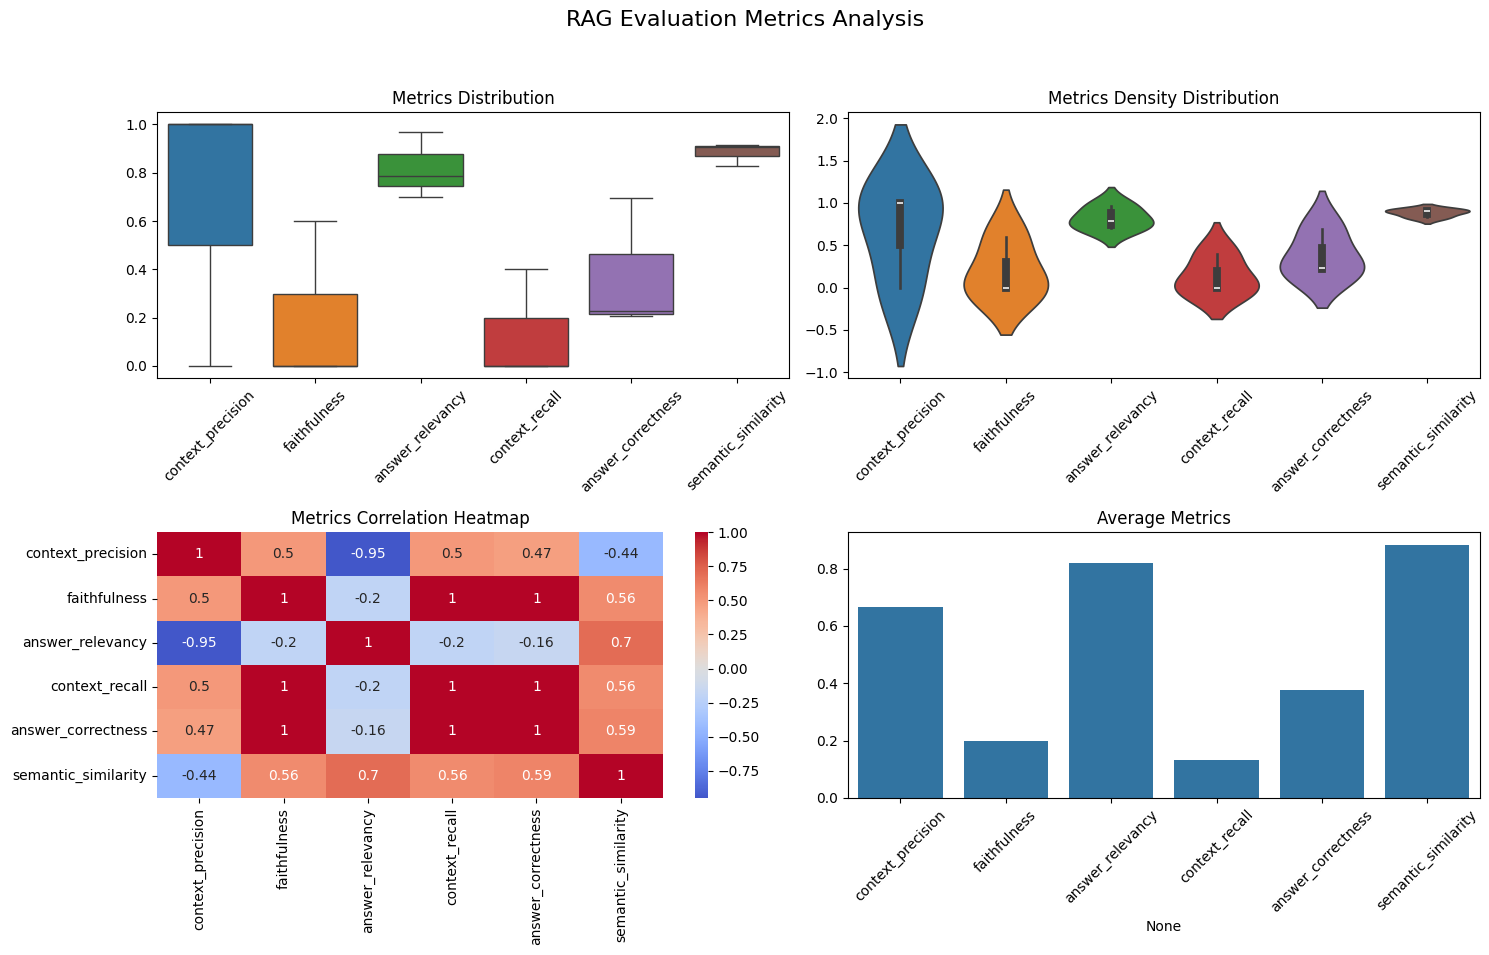

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle('RAG Evaluation Metrics Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig('rag_metrics_analysis', dpi=300, bbox_inches='tight')


In [92]:

# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())

Metrics Summary:

context_precision:
count    3.000000
mean     0.666667
std      0.577350
min      0.000000
25%      0.500000
50%      1.000000
75%      1.000000
max      1.000000
Name: context_precision, dtype: float64

faithfulness:
count    3.00000
mean     0.20000
std      0.34641
min      0.00000
25%      0.00000
50%      0.00000
75%      0.30000
max      0.60000
Name: faithfulness, dtype: float64

answer_relevancy:
count    3.000000
mean     0.818400
std      0.136307
min      0.700321
25%      0.743818
50%      0.787315
75%      0.877440
max      0.967564
Name: answer_relevancy, dtype: float64

context_recall:
count    3.000000
mean     0.133333
std      0.230940
min      0.000000
25%      0.000000
50%      0.000000
75%      0.200000
max      0.400000
Name: context_recall, dtype: float64

answer_correctness:
count    3.000000
mean     0.376944
std      0.277323
min      0.207325
25%      0.216927
50%      0.226530
75%      0.461754
max      0.696977
Name: answer_correctness, dt

# non factual 

In [179]:
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

<class 'ragas.dataset_schema.EvaluationResult'>
Metrics Summary:

context_precision:
count    4.000000
mean     0.722222
std      0.251538
min      0.416667
25%      0.583333
50%      0.736111
75%      0.875000
max      1.000000
Name: context_precision, dtype: float64

faithfulness:
count    4.000000
mean     0.511364
std      0.273113
min      0.166667
25%      0.416667
50%      0.522727
75%      0.617424
max      0.833333
Name: faithfulness, dtype: float64

answer_relevancy:
count    4.000000
mean     0.826482
std      0.173148
min      0.578723
25%      0.790898
50%      0.872924
75%      0.908508
max      0.981358
Name: answer_relevancy, dtype: float64

context_recall:
count    4.000000
mean     0.250000
std      0.319142
min      0.000000
25%      0.000000
50%      0.166667
75%      0.416667
max      0.666667
Name: context_recall, dtype: float64

answer_correctness:
count    4.000000
mean     0.570112
std      0.084442
min      0.517943
25%      0.525141
50%      0.533189
75%     

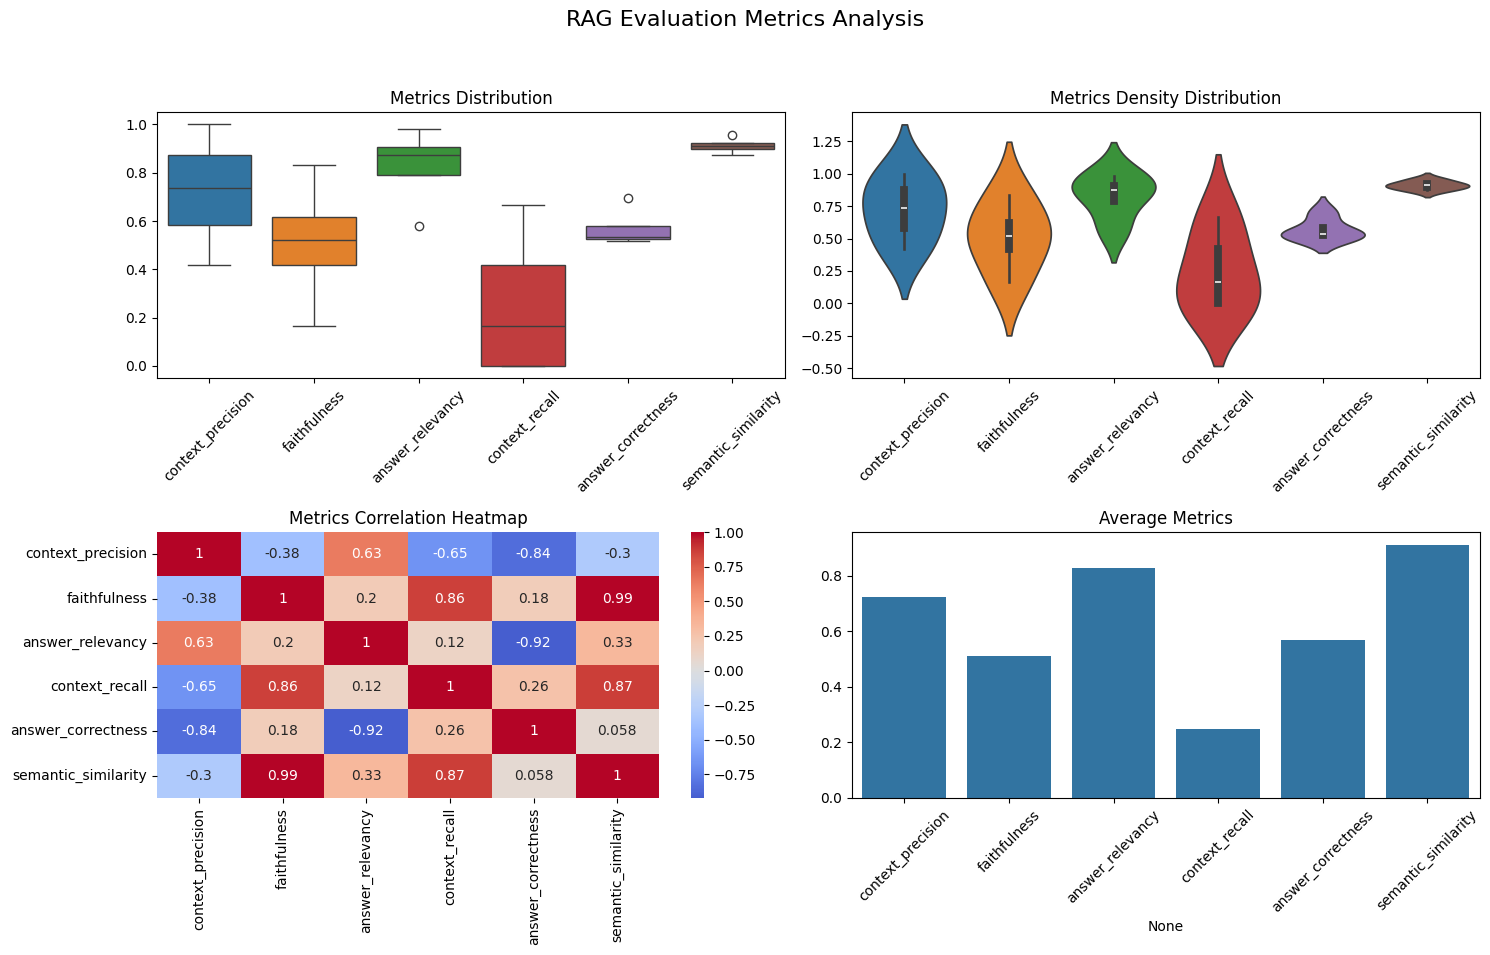

In [177]:
# Usage

results_df = evaluate_rag(input_file, output_file)

input_file = 'Non Factual.xlsx' 
output_file = f'rag_evaluation_results_ragas'+input_file
# Read input file
df = pd.read_excel(input_file)

# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle('RAG Evaluation Metrics Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())


# Comparative.xlsx

<class 'ragas.dataset_schema.EvaluationResult'>
Metrics Summary:

context_precision:
count    4.000000
mean     0.722222
std      0.251538
min      0.416667
25%      0.583333
50%      0.736111
75%      0.875000
max      1.000000
Name: context_precision, dtype: float64

faithfulness:
count    4.000000
mean     0.653571
std      0.169884
min      0.400000
25%      0.635714
50%      0.732143
75%      0.750000
max      0.750000
Name: faithfulness, dtype: float64

answer_relevancy:
count    4.000000
mean     0.825832
std      0.172376
min      0.578723
25%      0.790898
50%      0.872924
75%      0.907858
max      0.978757
Name: answer_relevancy, dtype: float64

context_recall:
count    4.000000
mean     0.250000
std      0.319142
min      0.000000
25%      0.000000
50%      0.166667
75%      0.416667
max      0.666667
Name: context_recall, dtype: float64

answer_correctness:
count    4.000000
mean     0.590081
std      0.106556
min      0.470756
25%      0.515325
50%      0.600255
75%     

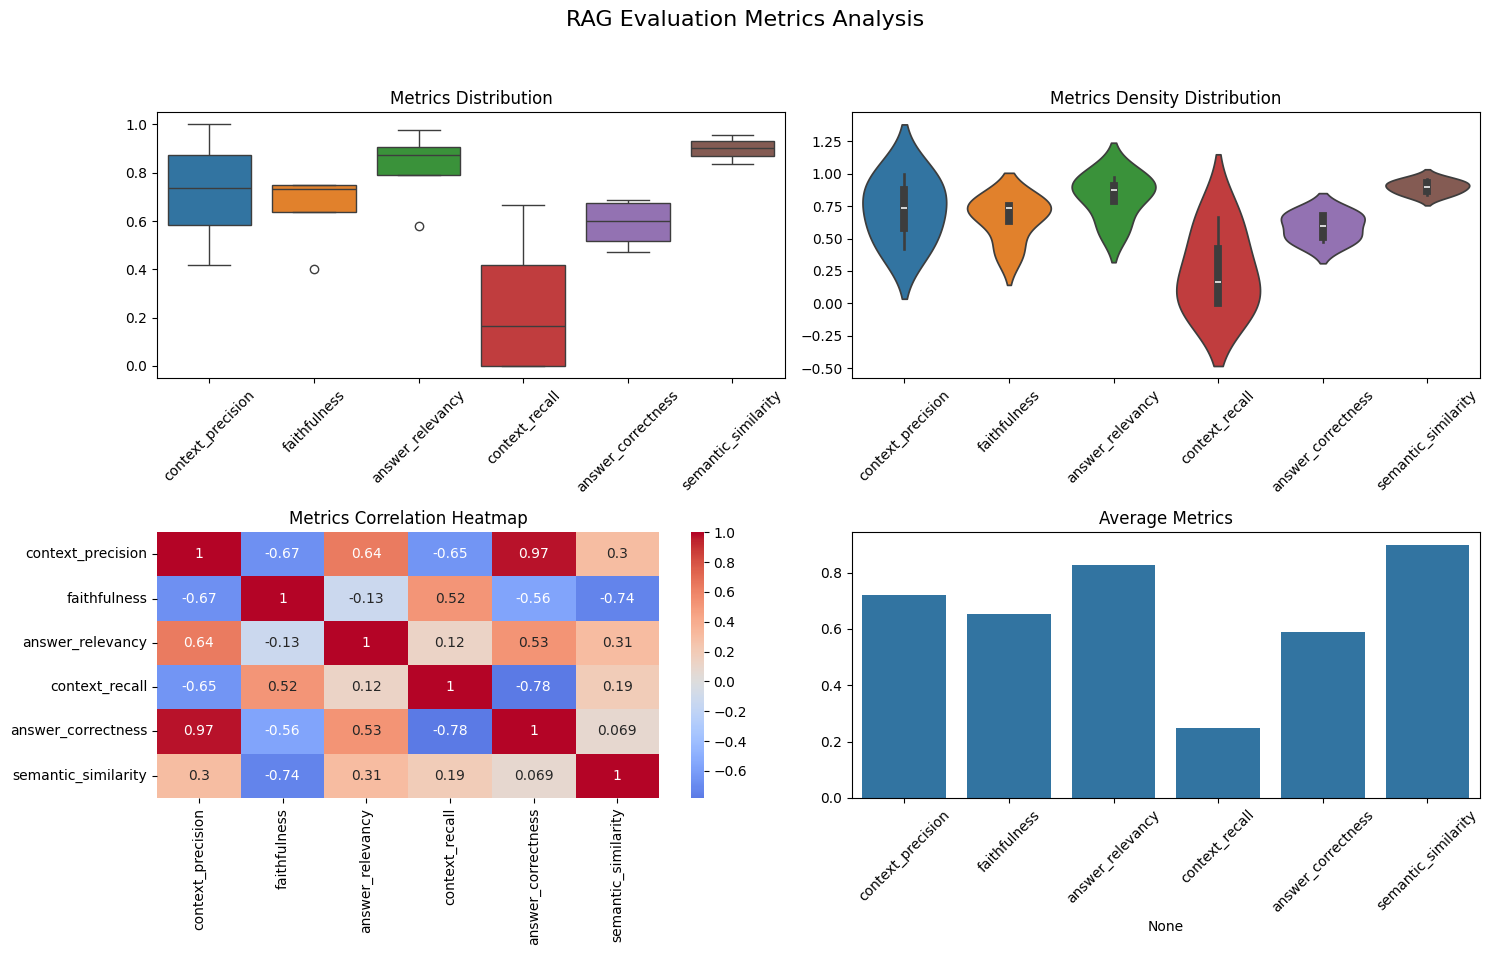

In [180]:
# Usage

results_df = evaluate_rag(input_file, output_file)

input_file = 'Comparative.xlsx' 
output_file = f'rag_evaluation_results_ragas'+input_file
# Read input file
df = pd.read_excel(input_file)

# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle('RAG Evaluation Metrics Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())


# Temporal.xlsx

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Evaluation attempt 1


<class 'list'>
["text: Again they regard each other without a word. MICHAEL turns, and continues on. DON CORLEONE watches a moment, and then follows. INT DAY: HOSPITAL ROOM (SUMMER 1945) DON CORLEONE enters the hospital room, moving closest to OUR VIEW. He is followed by his SONS, JOHNNY and the WOMEN. DON CORLEONE (whispered) Genco, I've brought my sons to pay their respects. And look, even Johnny Fontane, all the way from Hollywood.", "text: INT DAY: HOSPITAL CORRIDOR (SUMMER 1945) A long white hospital corridor, at the end of which we can see a grouping of FIVE WOMEN, some old and some young, but all plump and dressed in black. DON CORLEONE and his SONS move toward the end. But then the DON slows, putting his hand on MICHAEL's shoulder. MICHAEL stops and turns toward his FATHER. The two looks at one another for some time. SILENCE. DON CORLEONE then lifts his hand, and slowly touches a particular medal on MICHAEL's uniform."]
['text: FADE IN: EXT DAY: ESTABLISHING SICILY SHOT A CLOSE

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Batch 1/24:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

<class 'ragas.dataset_schema.EvaluationResult'>
Metrics Summary:

context_precision:
count    4.000000e+00
mean     1.000000e+00
std      2.886752e-11
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: context_precision, dtype: float64

faithfulness:
count    3.000000
mean     0.572222
std      0.286906
min      0.250000
25%      0.458333
50%      0.666667
75%      0.733333
max      0.800000
Name: faithfulness, dtype: float64

answer_relevancy:
count    4.000000
mean     0.430410
std      0.497003
min      0.000000
25%      0.000000
50%      0.428639
75%      0.859049
max      0.864361
Name: answer_relevancy, dtype: float64

context_recall:
count    4.000000
mean     0.416667
std      0.500000
min      0.000000
25%      0.000000
50%      0.333333
75%      0.750000
max      1.000000
Name: context_recall, dtype: float64

answer_correctness:
count    4.000000
mean     0.289220
std      0.164929
min      0.188829
25%      0.2

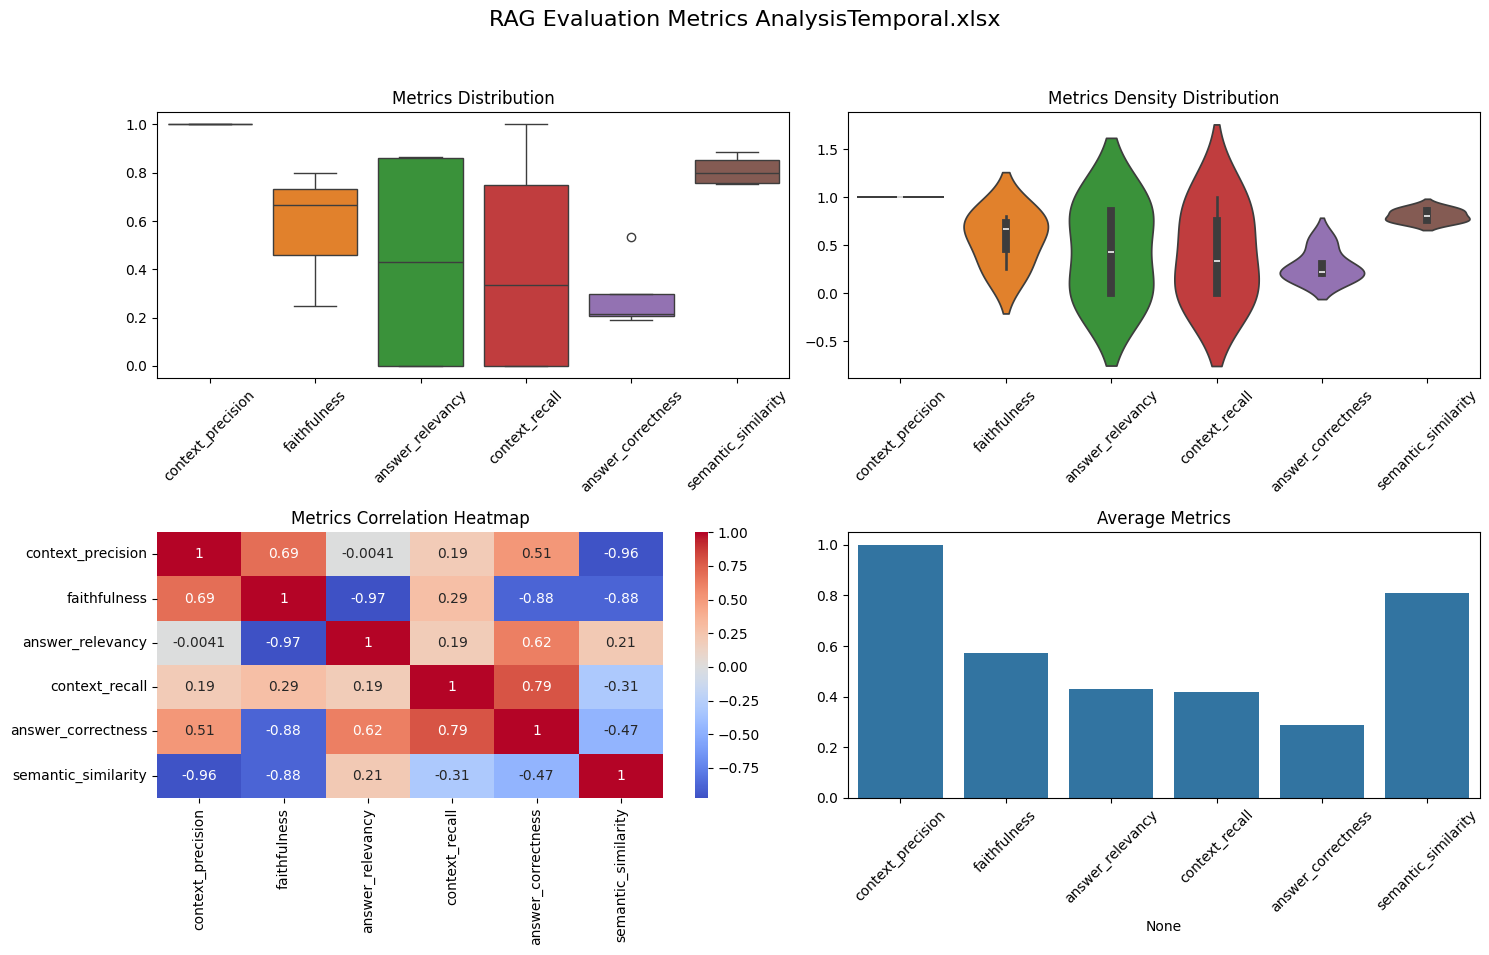

In [96]:
# Usage



input_file = 'Temporal.xlsx' 
output_file = f'rag_evaluation_results_ragasyopkk'+input_file

df,results_df = evaluate_rag(input_file, output_file)

# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle(f'RAG Evaluation Metrics Analysis{input_file}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Evaluation att

<class 'list'>
["text: MICHAEL I'll make him an offer he can't refuse. MICHAEL turns to JOHNNY. MICHAEL Johnny, the Don wants you to help us get started. We figure entertainment will be the big factor in drawing gamblers. We hope you'll sign a contract to appear five times a year for maybe a week long engagement. We hope your friends in the movies will do the same. We count on you to convince them. JOHNNY Sure, I'll do anything for my Godfather. You know that, Mike.", "text: The DON is silent, stern. DON CORLEONE You take care of your family? JOHNNY Sure. He glances at SONNY, who makes himself as inconspicuous as he can. DON CORLEONE You look terrible. I want you to eat well, to rest. And spend time with your family. And then, at the end of the month, this big shot will give you the part you want. JOHNNY It's too late. All the contracts have been signed, they're almost ready to shoot. DON CORLEONE I'll make him an offer he can't refuse."]
["text: MICHAEL Is my credit good enough to buy

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Batch 1/36:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

<class 'ragas.dataset_schema.EvaluationResult'>
Metrics Summary:

context_precision:
count    4.000000e+00
mean     1.000000e+00
std      2.886752e-11
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: context_precision, dtype: float64

faithfulness:
count    3.000000
mean     0.572222
std      0.286906
min      0.250000
25%      0.458333
50%      0.666667
75%      0.733333
max      0.800000
Name: faithfulness, dtype: float64

answer_relevancy:
count    4.000000
mean     0.430410
std      0.497003
min      0.000000
25%      0.000000
50%      0.428639
75%      0.859049
max      0.864361
Name: answer_relevancy, dtype: float64

context_recall:
count    4.000000
mean     0.416667
std      0.500000
min      0.000000
25%      0.000000
50%      0.333333
75%      0.750000
max      1.000000
Name: context_recall, dtype: float64

answer_correctness:
count    4.000000
mean     0.289220
std      0.164929
min      0.188829
25%      0.2

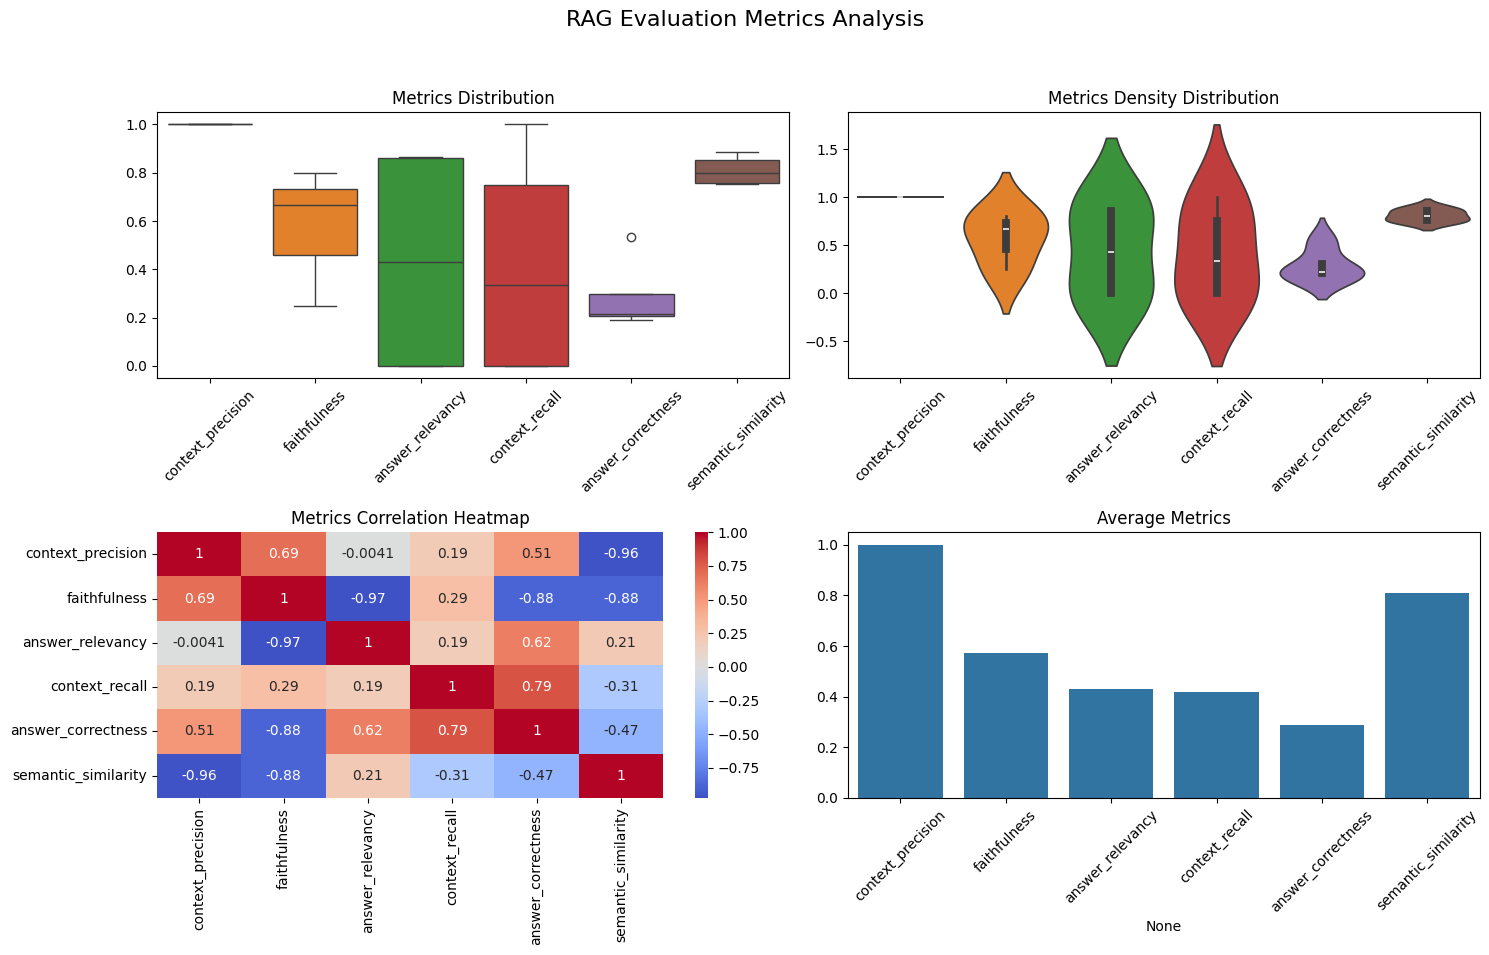

In [97]:
# Usage



input_file = 'Dialogue.xlsx' 
output_file = f'rag_evaluation_results_ragas'+input_file
# Read input file

df,esults_df = evaluate_rag(input_file, output_file)
# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle('RAG Evaluation Metrics Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POS

<class 'list'>
['text: DON CORLEONE stands at the Gate, flanked on either side by a son: FREDO and SONNY, all dressed in the formal attire of the wedding party. He warmly shakes the hands, squeezes the hands of the friends and guests, pinches the cheeks of the children, and makes them all welcome. They in turn carry with them gallons of homemade wine, cartons of freshly baked bread and pastries, and enormous trays of Italian delicacies.']
['text: DON CORLEONE stands at the Gate, flanked on either side by a son: FREDO and SONNY, all dressed in the formal attire of the wedding party. He warmly shakes the hands, squeezes the hands of the friends and guests, pinches the cheeks of the children, and makes them all welcome. They in turn carry with them gallons of homemade wine, cartons of freshly baked bread and pastries, and enormous trays of Italian delicacies.']
["text: DON CORLEONE It is Johnny. He came all the way from California to be at the wedding. HAGEN Should I bring him in. DON COR

Evaluating:   0%|          | 0/246 [00:00<?, ?it/s]

Batch 1/246:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

<class 'ragas.dataset_schema.EvaluationResult'>
Metrics Summary:

context_precision:
count    4.000000e+00
mean     1.000000e+00
std      2.886752e-11
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: context_precision, dtype: float64

faithfulness:
count    3.000000
mean     0.572222
std      0.286906
min      0.250000
25%      0.458333
50%      0.666667
75%      0.733333
max      0.800000
Name: faithfulness, dtype: float64

answer_relevancy:
count    4.000000
mean     0.430410
std      0.497003
min      0.000000
25%      0.000000
50%      0.428639
75%      0.859049
max      0.864361
Name: answer_relevancy, dtype: float64

context_recall:
count    4.000000
mean     0.416667
std      0.500000
min      0.000000
25%      0.000000
50%      0.333333
75%      0.750000
max      1.000000
Name: context_recall, dtype: float64

answer_correctness:
count    4.000000
mean     0.289220
std      0.164929
min      0.188829
25%      0.2

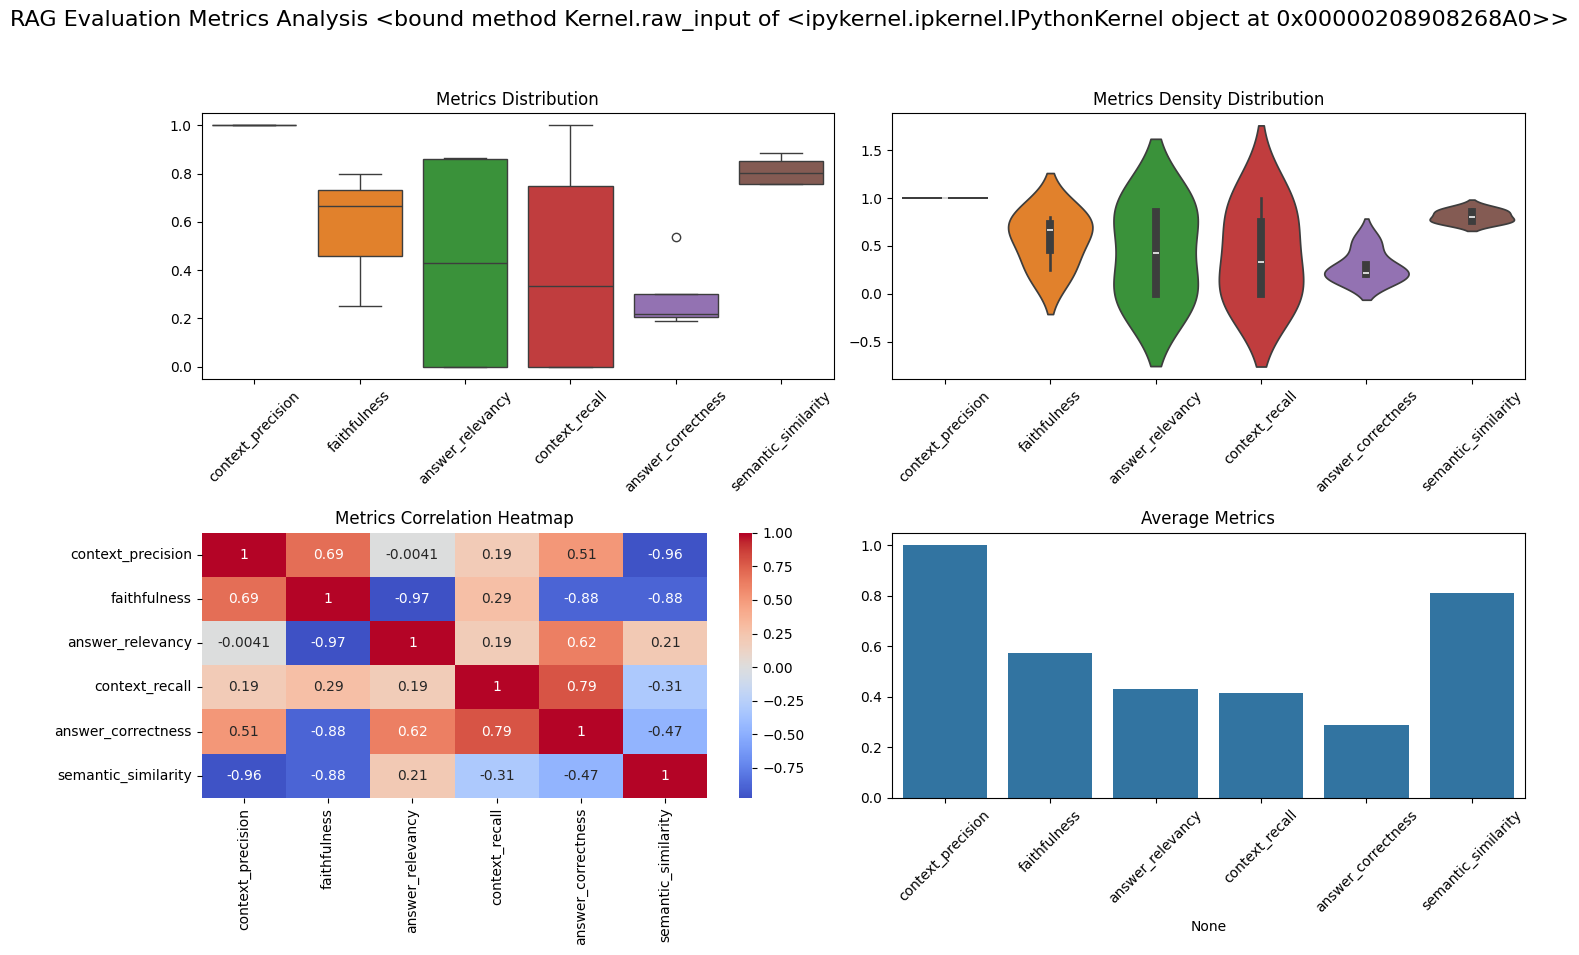

In [102]:
# Usage
input_file = 'ALL.xlsx' 
output_file = f'rag_evaluation_results_ragas'+input_file
# Read input file

df,esults_df = evaluate_rag(input_file, output_file)
# Write results to Excel
metrics_df = write_ragas_results_to_excel(df, results_df, output_file)

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in results_df.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle(f'RAG Evaluation Metrics Analysis {input}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())


In [106]:
results_df

{'context_precision': 1.0000, 'faithfulness': 0.5722, 'answer_relevancy': 0.4304, 'context_recall': 0.4167, 'answer_correctness': 0.2892, 'semantic_similarity': 0.8107}

In [154]:
import pandas as pd
import numpy as np
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_correctness,
    answer_similarity
)
from datasets import Dataset
import os
import logging
from dotenv import load_dotenv
from langchain_community.vectorstores import Neo4jVector
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.output_parsers import StrOutputParser

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()

# Initialize Local Ollama LLM and Embeddings for both RAG and Evaluation
llm = OllamaFunctions(model="llama3.1", temperature=0.2, format="json")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")
eval_llm = ChatOllama(model="mistral", temperature=0.0, format="json")

# Vector Retriever Setup
vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)
vector_retriever = vector_index.as_retriever()

# Retrieval Function (Vector Only)
def vector_only_retriever(question: str, top_k=1):
    """Retrieve top K relevant contexts."""
    vector_data = vector_retriever.invoke(question)[:top_k]  # Get top-k contexts
    return [el.page_content for el in vector_data]  # Return list of top contexts

# Function to break the context into smaller chunks
def chunk_context(context, chunk_size=150):
    """Break the context into chunks of specified size."""
    words = context.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

# RAG Chain Setup
template = """Answer the question based only on the following context:
{context}

If the context does not provide enough information, respond with "The context does not contain sufficient information to answer the question."

Use natural language, be concise but detailed where necessary, and do not repeat the question in the answer.

Question: {question}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

# Modify chain to handle list context
chain = (
    {
        "context": lambda x: " ".join(vector_only_retriever(x)),  # Retrieve and merge top contexts
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

def evaluate_single_ragas(question, ground_truth, model_answer, contexts):
    """Evaluate RAGAS for a single question."""
    try:
        data = {
            'question': [question],
            'ground_truth': [ground_truth],
            'answer': [model_answer],
            'contexts': [contexts]
        }
        dataset = Dataset.from_dict(data)

        result = evaluate(
            dataset,
            metrics=[
                context_precision, faithfulness, answer_relevancy,
                context_recall, answer_correctness, answer_similarity
            ],
            llm=eval_llm,
            embeddings=embeddings,
            show_progress=False,
            batch_size=1
        )

        # ✅ Correctly extract scores from EvaluationResult
        return result.scores  # This is already a dictionary

    except Exception as e:
        logger.error(f"Error during RAGAS evaluation: {str(e)}")
        return None


# Main Evaluation Function
def evaluate_rag(input_file, output_file):
    # Read input Excel file
    df = pd.read_excel(input_file)

    # Generate answers and contexts
    for index, row in df.iterrows():
        question = row['questions']
        ground_truth = row['ground_truths']

        # Get retrieved context (top K relevant) - now a list
        top_contexts = vector_only_retriever(question, top_k=1)

        print(top_contexts)
        print(type(top_contexts))

        
        
        # Get model's answer using the final context
        model_answer = chain.invoke(question)

        # Evaluate RAGAS metrics
        metrics = evaluate_single_ragas(question, ground_truth, model_answer, top_contexts)

        #print(metrics)
        #print(type(metrics))

        for k,v in metrics[0].items():
            df.at[index, k] = v

        df.at[index, 'model_answers'] = model_answer
        df.at[index, 'retrieved_contexts'] = str(top_contexts)  # Convert list to string for saving

        
    
    df.to_excel(output_file, index=False)

    return df


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [155]:
input_file = 'ALL.xlsx' 
output_file = f'bhadve38_rag_evaluation_results_ragasNEWALL560'+input_file
# Read input file
dff=evaluate_rag(input_file,output_file)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


['\ntext: DON CORLEONE stands at the Gate, flanked on either side by a\nson: FREDO and SONNY, all dressed in the formal attire of\nthe wedding party. He warmly shakes the hands, squeezes the\nhands of the friends and guests, pinches the cheeks of the\nchildren, and makes them all welcome. They in turn carry\nwith them gallons of homemade wine, cartons of freshly baked\nbread and pastries, and enormous trays of Italian delicacies.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: DON CORLEONE stands at the Gate, flanked on either side by a\nson: FREDO and SONNY, all dressed in the formal attire of\nthe wedding party. He warmly shakes the hands, squeezes the\nhands of the friends and guests, pinches the cheeks of the\nchildren, and makes them all welcome. They in turn carry\nwith them gallons of homemade wine, cartons of freshly baked\nbread and pastries, and enormous trays of Italian delicacies.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: DON CORLEONE\nIt is Johnny. He came all the way\nfrom California to be at the wedding.\n\n HAGEN\nShould I bring him in.\n\n DON CORLEONE\nNo. Let the people enjoy him. You\nsee? He is a good godson.\n\n  HAGEN\nIt's been two years. He's probably\nin trouble again.\n\nEXT DAY: MALL (SUMMER 1945)\n\nJOHNNY FONTANE on the bandstand, singing to the delight and\nexcitement of the wedding GUESTS.\n\n  KAY\nI didn't know your family knew\nJohnny Fontane.\n\n MICHAEL\nSure."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: HIGH ANGLE VIEW of THE CORLEONE MALL. The gateway now has a\nlong black car blocking it. There are more BUTTON MEN\nstationed more formally; and some of them visibly carrying\nrifles; those of the houses close to the courtyard have MEN\nstanding by open windows. It is clear that the war is\nescalating. A car pulls up and out get CLEMENZA, LAMPONE,\nMICHAEL and HAGEN. MICHAEL's jaw is wired and bandaged. He\nstops and looks up at the open window. We can see MEN\nholding rifles."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: EXT DAY: CORLEONE HILL\n\nThey continue their long hike, high on a promentory; until\nthey hesitate, and look down.\n\n CALO\nCorleone.\n\nThey can see a grim Sicilian village, almost devoid of people.\n\nEXT DAY: CORLEONE STREET\n\nMICHAEL and his bodyguards move through the empty streets of\nthe village. They walk behind him, and spread to either\nside about fifteen feet away from him.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
ERROR:ragas.prompt.pydantic_prompt:Pro

["\ntext: CONNIE\nKiss your Godfather.\n\nThe infant turns its head, and MICHAEL uses that as an\nexcuse to back away.\n\n  MICHAEL\nCarlo...we've had a change in the\nplans. Mama, Connie, Kay and the\nkids will have to take the trip out\nto Vegas without us.\n\n  CONNIE\nOh Mike, it's our first vacation\ntogether.\n\x0c CARLO\n  (anxious to please)\nJesus, Connie...Sure, Mike...\n\n MICHAEL\nGo back to your house and wait for\nme...\n\nHe kisses KAY.\n\n  MICHAEL\n    (to KAY)\nI'll just be a couple of days..."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: INT NITE: FLAMINGO SUITE (1955)\n\nThey are seated around the lavish table in Michael's suite.\nMICHAEL is speaking to JOHNNY.\n\x0c  MICHAEL\nJohnny, the Corleone family is\nthinking of selling out all our\ninterests in the Olive Oil business\nand settling here. Moe Greene will\nsell us his interest so it can be\nwholly owned by friends of the\nfamily.\n\nFREDDIE seems anxious.\n\n  FREDO\nMike, you sure about Moe selling.\nHe never mentioned it to me and he\nloves the business."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: The OLD MAN glances at SONNY.\n\n SONNY\n\x0cPop, they hit us and we hit them\nback.\n\n  HAGEN\nWe put out a lot of material\nthrough our contacts in the\nNewspapers...about McCluskey's\nbeing tied up with Sollozzo in the\nDrug Rackets...things are starting\nto loosen up.\n\nThe OLD MAN nods.\n\n SONNY\nFreddie's gonna go to Las\nVegas...under the protection of Don\nFrancesco of L.A. I want him to\nrest...\n\n  FREDO\nI'm goin' to learn the casino\nbusiness."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: INT NITE: FLAMINGO SUITE (1955)\n\nThey are seated around the lavish table in Michael's suite.\nMICHAEL is speaking to JOHNNY.\n\x0c  MICHAEL\nJohnny, the Corleone family is\nthinking of selling out all our\ninterests in the Olive Oil business\nand settling here. Moe Greene will\nsell us his interest so it can be\nwholly owned by friends of the\nfamily.\n\nFREDDIE seems anxious.\n\n  FREDO\nMike, you sure about Moe selling.\nHe never mentioned it to me and he\nloves the business."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: DON CORLEONE is not pleased.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: By now, THE VIEW is full, and we see Don Corleone's office\nin his home.\n\nThe blinds are closed, and so the room is dark, and with\npatterned shadows. We are watching BONASERA over the\nshoulder of DON CORLEONE. TOM HAGEN sits near a small\ntable, examining some paperwork, and SONNY CORLEONE stands\nimpatiently by the window nearest his father, sipping from a\nglass of wine. We can HEAR music, and the laughter and\nvoices of many people outside."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: DON CORLEONE stands at the Gate, flanked on either side by a\nson: FREDO and SONNY, all dressed in the formal attire of\nthe wedding party. He warmly shakes the hands, squeezes the\nhands of the friends and guests, pinches the cheeks of the\nchildren, and makes them all welcome. They in turn carry\nwith them gallons of homemade wine, cartons of freshly baked\nbread and pastries, and enormous trays of Italian delicacies.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: SOLLOZZO is intuitively suspicious. He studies MICHAEL with\nhis dark eyes. Then he thrusts his hand onto MICHAEL's\nthigh feeling in and around, searching for a weapon.\n\n  MCCLUSKEY\nI frisked him; I've frisked\nthousands of young punks; he's clean.\n\nHe looks at a MAN sitting at a table opposite them;\nindicating the bathroom with his eyes. The MAN nods,\nindicating no one is there.\n\n SOLLOZZO\nDon't take too long.\n\nMICHAEL gets up and calmly walks to the bathroom, and\ndisappears inside."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: CLEMENZA whispers into the ear of LAMPONE. LAMPONE\nimmediately arranges for the members of the Five New York\nFamilies to pay their respects.\n\nFirst CUNEO, then STRACHI and then ZALUCHI. Then PHILIP\nTATTAGLIA, who merely passes by the Coffin.\n\nThen BARZINI in a black homburg, standing a long time.\n\nMICHAEL watches the scene.\n\nBARZINI crosses himself and passes on, immediately rejoined\nby his men.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: His arms, shoulders are riddled by the fire, and still it\ncontinues, as though the ASSASSINS cannot take a chance that\nhe will survive it.\n\nSuddenly, he lets out an enormous ROAR, like a bull, and\nactually, opens the door, and steps out of the car, UNDER\nfire.\n\nHis face is hit; and finally he falls to the ground.\n\nA FULL SHOT...as the ASSASSINS scramble for their cars and\nmake off in the distance.\n\nSONNY's BODYGUARDS stop a safe distance away, realizing they\nare too late."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
ERROR:ragas.prompt.pydantic_prompt:Pro

['\ntext: CALO and FABRIZZIO are impressed.\n\n VITELLI\n\x0c  (shrugs)\nWho are you and what do you want\nfrom my daughter?\n\n  MICHAEL\nI am an American hiding in Sicily\nfrom the police of my country. My\nname is Michael. You can inform\nthe police and make your fortune\nbut then your daughter would lose a\nfather rather than gain a husband.\nIn any case, I want to meet your\ndaughter. With your permission and\nunder the supervision of your\nfamily. With all decorum. With\nall respect. I am an honorable man.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: MICHAEL\nChrist, Sonny really means business.\n\nThey continue walking. TESSIO joins them. The various\nBODYGUARDS make no acknowledgment.\n\n CLEMENZA\nHow come all the new men?\n\n  TESSIO\nWe'll need them now. After the\nhospital incident, Sonny got mad.\nWe hit Bruno Tattaglia four o'clock\nthis morning.\n\nINT DAY: DON'S HALLWAY\n\nThey enter the house past the scores of new and strange faces.\n\nINT DAY: DON'S OFFICE (WINTER 1945)\n\nSONNY is in the DON's office; he is excited and exuberant."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: Again they regard each other without a word. MICHAEL turns,\nand continues on. DON CORLEONE watches a moment, and then\nfollows.\n\nINT DAY: HOSPITAL ROOM (SUMMER 1945)\n\nDON CORLEONE enters the hospital room, moving closest to OUR\nVIEW. He is followed by his SONS, JOHNNY and the WOMEN.\n\n  DON CORLEONE\n  (whispered)\nGenco, I've brought my sons to pay\ntheir respects. And look, even\nJohnny Fontane, all the way from\nHollywood."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: DON CORLEONE stands at the Gate, flanked on either side by a\nson: FREDO and SONNY, all dressed in the formal attire of\nthe wedding party. He warmly shakes the hands, squeezes the\nhands of the friends and guests, pinches the cheeks of the\nchildren, and makes them all welcome. They in turn carry\nwith them gallons of homemade wine, cartons of freshly baked\nbread and pastries, and enormous trays of Italian delicacies.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt n_l_i_statement_prompt failed to p

['\ntext: DON CORLEONE\nFredo, Fredo!\n\nThe paper bag has hit the ground, and the fruit begins\nrolling along the sidewalk, as we HEAR gunshots.\n\nFive bullets catch the DON in the back; he arches in pain,\n\x0cand continues toward the car.\n\nThe PROPRIETOR of the fruit stand rushes for cover, knocking\nover an entire case of fruit.\n\nThe TWO GUNMEN move in quickly, anxious to finish him off.\n\nTheir feet careful to avoid the rolling fruit. There are\nmore GUNSHOTS.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt n_l_i_statement_prompt failed to p

["\ntext: Again they regard each other without a word. MICHAEL turns,\nand continues on. DON CORLEONE watches a moment, and then\nfollows.\n\nINT DAY: HOSPITAL ROOM (SUMMER 1945)\n\nDON CORLEONE enters the hospital room, moving closest to OUR\nVIEW. He is followed by his SONS, JOHNNY and the WOMEN.\n\n  DON CORLEONE\n  (whispered)\nGenco, I've brought my sons to pay\ntheir respects. And look, even\nJohnny Fontane, all the way from\nHollywood."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: FADE IN:\n\nEXT DAY: ESTABLISHING SICILY SHOT\n\nA CLOSE VIEW OF MICHAEL, moving as he walks, sullen and\ndowncast, the left side of his face healed, but left\ngrotesque and misshapen.\n\nGRADUALLY, THE VIEW LOOSENS, he wears a warm navy Pea\njacket, and walks with his hands in his pockets.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: WOLTZ tries to scream; but cannot. No sound comes out.\nThen, finally and suddenly an ear-splitting scream of pure\nterror escapes from WOLTZ, who is rocking on his hands and\nknees in an uncontrolled fit, blood all over him.\n\nINT DAY: OLIVE OIL OFFICES (SUMMER 1945)\n\nCLOSE VIEW on the GODFATHER. Nodding.\n\n DON CORLEONE\nSend Johnny my congratulations.\n\n----------------------------------------FADE OUT--------\n\n(SCENES 12 & 12 OMITTED)\n\nFADE IN:\n\nEXT DAY: FIFTH AVENUE (WINTER 1945)']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: FADE IN:\n\nEXT DAY: ESTABLISHING SICILY SHOT\n\nA CLOSE VIEW OF MICHAEL, moving as he walks, sullen and\ndowncast, the left side of his face healed, but left\ngrotesque and misshapen.\n\nGRADUALLY, THE VIEW LOOSENS, he wears a warm navy Pea\njacket, and walks with his hands in his pockets.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: SONNY\nWhere the hell was Paulie, why\nwasn't he with the Don?\n\n CLEMENZA\nPaulie's been a little sick all\nwinter...he was home.\n\n  SONNY\nHow many times did he stay home the\nlast couple of months?\n\n CLEMENZA\nMaybe three, four times. I always\nasked Freddie if he wanted another\nbodyguard, but he said no. Things\nhave been so smooth the last ten\nyears...\n\n SONNY\nGo get Paulie, I don't care how\nsick he is. Pick him up yourself,\nand bring him to my father's house."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt context_precision_prompt failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.executor:Exception raised in Job[0]: RagasOutputParserException(The o

['\ntext: FADE IN:\n\nEXT DAY: ESTABLISHING SICILY SHOT\n\nA CLOSE VIEW OF MICHAEL, moving as he walks, sullen and\ndowncast, the left side of his face healed, but left\ngrotesque and misshapen.\n\nGRADUALLY, THE VIEW LOOSENS, he wears a warm navy Pea\njacket, and walks with his hands in his pockets.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: CONNIE CORLEONE, the Bride, is pressing the bodice of her\noverly-fluffy white gown against the groom, CARLO RIZZI. He\nis bronzed, with curly blondish hair and lovely dimples.\nShe absolutely adores him and can barely take her eyes from\nhim long enough to thank the various GUESTS for the white\nenvelopes they are putting into the large white purse she\nholds. In fact, if we watch carefully, we can see that one\nof her hands is slid under his jacket, and into his shirt,']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: Looking toward the staircase we can hear SOLLOZZO's footsteps\nbefore he actually rises into view. He is a small man, very\ndark, with curly black hair. But wiry, and tight and hard,\nand obviously very dangerous. He is greeted at the head of\nthe stairs by SONNY, who takes his hand and shakes it,\nintroducing himself. For a moment, there is a complex of\nhandshaking quite formal, and whispered respectful\nintroductions. Finally, SOLLOZZO is taken into the DON's"]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: MICHAEL\nI'll make him an offer he can't\nrefuse.\n\nMICHAEL turns to JOHNNY.\n\n  MICHAEL\nJohnny, the Don wants you to help\nus get started. We figure\nentertainment will be the big\nfactor in drawing gamblers. We\nhope you'll sign a contract to\nappear five times a year for maybe\na week long engagement.\nWe hope your friends in the movies\nwill do the same. We count on you\nto convince them.\n\n JOHNNY\nSure, I'll do anything for my\nGodfather. You know that, Mike."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: MICHAEL\nIs my credit good enough to buy you\nout?\n\nMOE laughs.\n\n MOE\nBuy me out?...\n\n  MICHAEL\nThe hotel, the casino. The Corleone\nfamily wants to buy you out.\n\nGREENE stops laughing; the room becomes tense. NERI eyes\nthe BODYGUARDS.\n\n MOE\n  (furious)\nThe Corleone family wants to buy me\nout. I buy you out. You don't buy\nme out.\n\n MICHAEL\nYour casino loses money. Maybe we\ncan do better.\n\n MOE\nYou think I scam?\n\x0c MICHAEL\n (the worst insult)\nYou're unlucky."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: They enter the DON's glass-panelled office.\n\n  DON CORLEONE\nHave you thought about a wife? A\nfamily?\n\n MICHAEL\n (pained)\nNo.\n\n  DON CORLEONE\nI understand, Michael. But you\nmust make a family, you know.\n\n  MICHAEL\nI want children, I want a family.\nBut I don't know when.\n\n DON CORLEONE\nAccept what's happened, Michael.\n\n  MICHAEL\nI could accept everything that's\nhappened; I could accept it, but\nthat I never had a choice. From\nthe time I was born, you had laid\nthis all out for me."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: SONNY\nI know I'm not the man he was. But\nI'll tell you this and he'll tell\n\x0cyou too. When it comes to real\naction, I can operate as good as\nanybody short range.\n\n MICHAEL\n  (calmly)\nAll right, Sonny. All right.\n\n SONNY\nChrist, if I could only contact Luca.\n\n  MICHAEL\nIs it like they say? Is he that\ngood?\n\nOutside, we HEAR THERESA cry out, almost a scream of relief.\nThen open the door and rush out.\n\nEveryone is standing: in the doorway, TOM HAGEN is wrapped\nin a tight embrace with his WIFE."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

['\ntext: DON CORLEONE\nThere are men in this world who\ndemand to be killed. They argue in\ngambling games; they jump out of\ntheir cars in a rage if someone so\nmuch as scratches their fender.\nThese people wander through the\nstreets calling out "Kill me, kill\nme." Luca Brasi was like that.\nAnd since he wasn\'t scared of\ndeath, and in fact, looked for\nit...I made him my weapon. Because\n\x0cI was the only person in the world\nthat he truly hoped would not kill\nhim. I think you have done the\nsame with this man.']
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: DON CORLEONE\nYou never think to protect yourself\nwith real friends. You think it's\nenough to be an American. All\nright, the Police protects you,\nthere are Courts of Law, so you\ndon't need a friend like me.\nBut now you come to me and say Don\nCorleone, you must give me justice.\nAnd you don't ask in respect or\nfriendship. And you don't think to\ncall me Godfather; instead you come\nto my house on the day my daughter\nis to be married and you ask me to\ndo murder...for money."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: DON CORLEONE\n (shaking his head)\nBarzini.\n\n HAGEN\n (a revelation)\nHe was the one behind Sollozzo?\n\n  DON CORLEONE\nTattaglia is a pimp. He could\nnever have outfought Santino. But\nI wasn't sure until this day. No,\nit was Barzini all along.\n\nThe black limousine speeds away from us in the night.\n\n------------------------------------------FADE OUT------\n\nFADE IN:\n\nEXT DAY: ESTABLISHING SICILY SHOT"]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: The entire family poses for a family portrait: DON CORLEONE,\nMAMA, SONNY, his wife, SANDRA, and their children, TOM HAGEN\nand his wife, THERESA, and their BABY; CONSTANZIA, the\nbride, and her bridegroom, CARLO RIZZI. As they move into\nthe pose, THE DON seems preoccupied.\n\n DON CORLEONE\nWhere's Michael?\n\n SONNY\nHe'll be here Pop, it's still early.\n\n DON CORLEONE\nThen the picture will wait for him."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: INT NITE: FLAMINGO SUITE (1955)\n\nThey are seated around the lavish table in Michael's suite.\nMICHAEL is speaking to JOHNNY.\n\x0c  MICHAEL\nJohnny, the Corleone family is\nthinking of selling out all our\ninterests in the Olive Oil business\nand settling here. Moe Greene will\nsell us his interest so it can be\nwholly owned by friends of the\nfamily.\n\nFREDDIE seems anxious.\n\n  FREDO\nMike, you sure about Moe selling.\nHe never mentioned it to me and he\nloves the business."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: INT DAY: DON'S OFFICE (SUMMER 1945)\n\nDON CORLEONE at the window. He has seen the intimacy of the\nYOUNG COUPLE.\n\n LUCA (O.S.)\nDon Corleone...\n\nTHE DON turns to the stiffly formal LUCA, and he moves\nforward to kiss his hand. He takes the envelope from his\njacket, holds it out, but does not release it until he makes\na formal speech."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: INT DAY: HOSPITAL CORRIDOR (SUMMER 1945)\n\nA long white hospital corridor, at the end of which we can\nsee a grouping of FIVE WOMEN, some old and some young, but\nall plump and dressed in black.\n\nDON CORLEONE and his SONS move toward the end. But then the\nDON slows, putting his hand on MICHAEL's shoulder. MICHAEL\n\x0cstops and turns toward his FATHER. The two looks at one\nanother for some time. SILENCE. DON CORLEONE then lifts\nhis hand, and slowly touches a particular medal on MICHAEL's\nuniform."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: The entire family poses for a family portrait: DON CORLEONE,\nMAMA, SONNY, his wife, SANDRA, and their children, TOM HAGEN\nand his wife, THERESA, and their BABY; CONSTANZIA, the\nbride, and her bridegroom, CARLO RIZZI. As they move into\nthe pose, THE DON seems preoccupied.\n\n DON CORLEONE\nWhere's Michael?\n\n SONNY\nHe'll be here Pop, it's still early.\n\n DON CORLEONE\nThen the picture will wait for him."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

["\ntext: HAGEN\nWithout your father's political\ncontacts and personal influence,\nthe Corleone family loses half its\nstrength. Without your father, the\nother New York families might wind\nup supporting Sollozzo, and the\nTattaglias just to make sure there\nisn't a long destructive war. The\nold days are over, this is 1946;\nnobody wants bloodshed anymore. If\nyour father dies...make the deal,\nSonny.\n\n  SONNY\n  (angry)\nThat's easy to say; it's not your\nfather."]
<class 'list'>


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://1

In [132]:
ml

[[{'context_precision': 0.999999999975,
   'faithfulness': 1.0,
   'answer_relevancy': 0.9514720049241783,
   'context_recall': 0.5,
   'answer_correctness': 0.4643065436888645,
   'semantic_similarity': 0.857226174755458}],
 [{'context_precision': 0.9999999999666667,
   'faithfulness': 1.0,
   'answer_relevancy': 0.0,
   'context_recall': 0.0,
   'answer_correctness': 0.1768781460461683,
   'semantic_similarity': 0.7075125841846732}],
 [{'context_precision': 0.9166666666361111,
   'faithfulness': 1.0,
   'answer_relevancy': 0.7118272910493416,
   'context_recall': 1.0,
   'answer_correctness': 0.44933569696029924,
   'semantic_similarity': 0.7973427878411969}],
 [{'context_precision': 0.0,
   'faithfulness': 0.0,
   'answer_relevancy': 0.9668066064385865,
   'context_recall': 0.0,
   'answer_correctness': 0.18571114847170153,
   'semantic_similarity': 0.7428445938868061}],
 [{'context_precision': 0.999999999975,
   'faithfulness': 0.6666666666666666,
   'answer_relevancy': 0.0,
   'co

In [128]:
def write_ragas_results_to_excel(df, results, output_file):
    # Convert results to a DataFrame
    
    
    metrics_df = pd.DataFrame(results)
    
    # Combine original dataframe with metrics
    combined_df = pd.concat([df, metrics_df], axis=1)
    
    # Write to Excel
    with pd.ExcelWriter(output_file) as writer:
        combined_df.to_excel(writer, sheet_name='Combined Results', index=False)
    
    return metrics_df



metrics_df = write_ragas_results_to_excel(df, ml, output_file)


In [129]:

print(type(results_df))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the results from the previous RAGAS evaluation
# If not, you'll need to load or recreate the results

# Metrics to plot
metrics = [
    'context_precision', 
    'faithfulness', 
    'answer_relevancy', 
    'context_recall', 
    'answer_correctness', 
    'semantic_similarity'
]

# Create a DataFrame to store the metrics
metrics_data = []
for score in ml.scores:
    metrics_data.append(score)

metrics_df = pd.DataFrame(metrics_data)

# Set up the visualization
plt.figure(figsize=(15, 10))

# 1. Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(data=metrics_df[metrics])
plt.title('Metrics Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Violin Plot
plt.subplot(2, 2, 2)
sns.violinplot(data=metrics_df[metrics])
plt.title('Metrics Density Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Heatmap of Correlations
plt.subplot(2, 2, 3)
sns.heatmap(metrics_df[metrics].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')
plt.tight_layout()

# 4. Bar Plot of Mean Metrics
plt.subplot(2, 2, 4)
metrics_means = metrics_df[metrics].mean()
sns.barplot(x=metrics_means.index, y=metrics_means.values)
plt.title('Average Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

# Overall layout adjustments
plt.suptitle(f'RAG Evaluation Metrics Analysis {input}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plt.savefig(f'rag_metrics_analysis_{input_file}.png', dpi=300, bbox_inches='tight')



# Print individual metric statistics
print("Metrics Summary:")
for metric in metrics:
    print(f"\n{metric}:")
    print(metrics_df[metric].describe())

<class 'ragas.dataset_schema.EvaluationResult'>


AttributeError: 'list' object has no attribute 'scores'

C:\Users\offic\AppData\Local\Temp\ipykernel_25904\1701307481.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_25904\1701307481.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)


Comprehensive Metrics Summary:
                     Count    Mean  Std Dev     Min     Max
context_precision       40  0.8250   0.3848  0.0000  1.0000
faithfulness            39  0.6115   0.4293  0.0000  1.0000
answer_relevancy        41  0.5192   0.3832  0.0000  0.9777
context_recall          38  0.4096   0.4483  0.0000  1.0000
answer_correctness      41  0.2880   0.2199  0.0819  0.8574
semantic_similarity     41  0.6976   0.1762  0.3276  0.9294

Additional Insights:
Context Precision:
  Mean: 0.8250
  Standard Deviation: 0.3848
  Coefficient of Variation: 46.64%
Faithfulness:
  Mean: 0.6115
  Standard Deviation: 0.4293
  Coefficient of Variation: 70.20%
Answer Relevancy:
  Mean: 0.5192
  Standard Deviation: 0.3832
  Coefficient of Variation: 73.80%
Context Recall:
  Mean: 0.4096
  Standard Deviation: 0.4483
  Coefficient of Variation: 109.43%
Answer Correctness:
  Mean: 0.2880
  Standard Deviation: 0.2199
  Coefficient of Variation: 76.34%
Semantic Similarity:
  Mean: 0.6976
  Standa

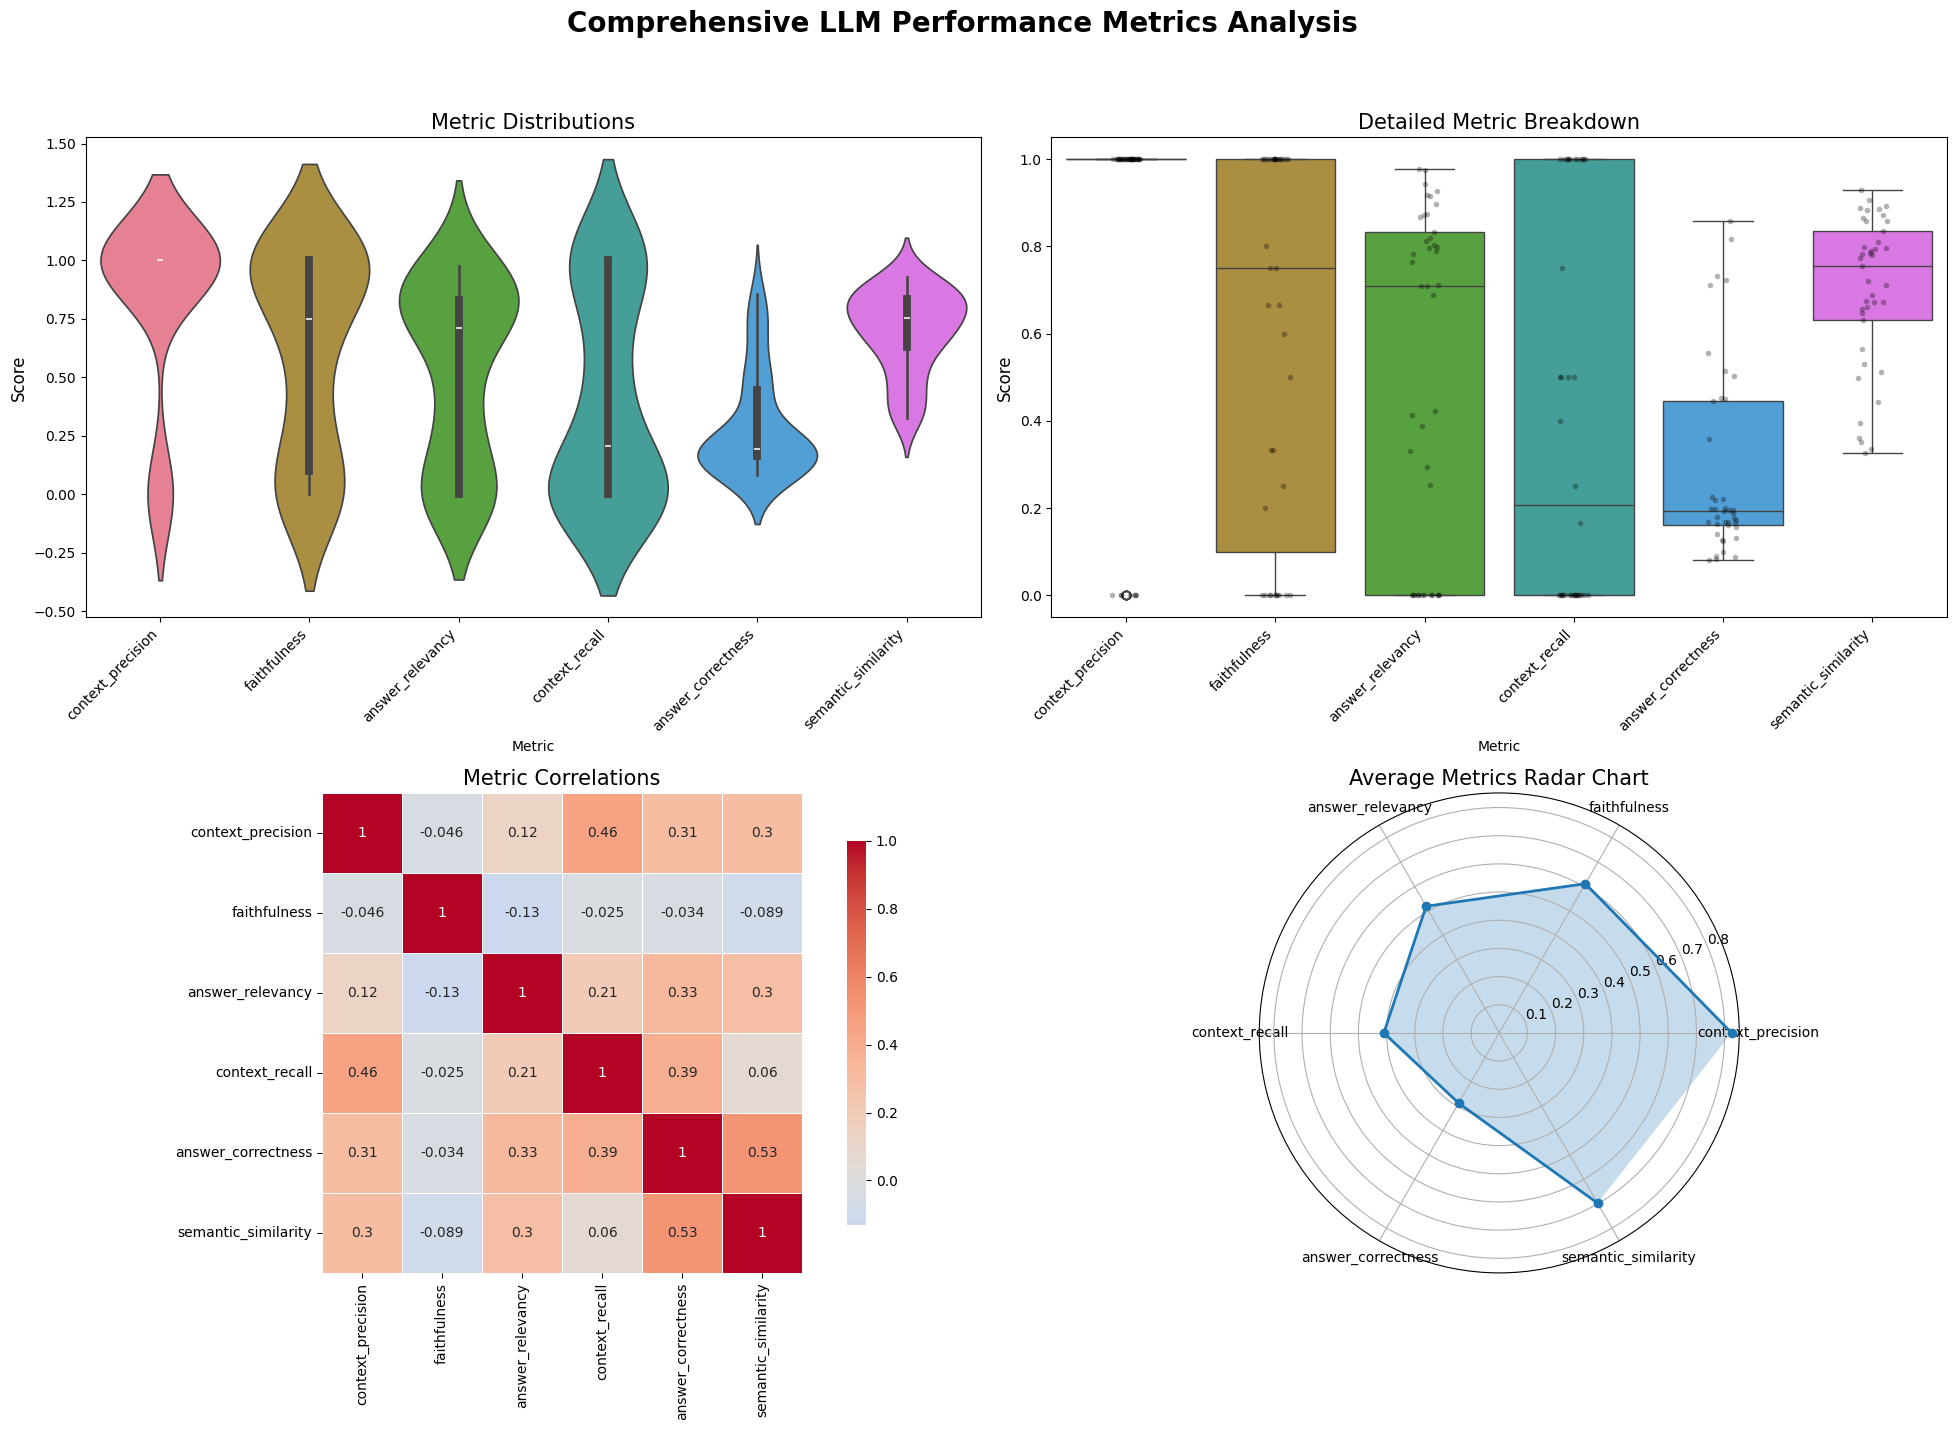

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_metrics(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Select metrics columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Set up a beautiful color palette
    palette = sns.color_palette("husl", 6)
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))
    plt.suptitle('Comprehensive LLM Performance Metrics Analysis', fontsize=20, fontweight='bold')
    
    # 1. Violin Plot (Distribution)
    plt.subplot(2, 2, 1)
    df_melted = df[metrics_columns].melt(var_name='Metric', value_name='Score')
    sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
    plt.title('Metric Distributions', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 2. Box Plot with Individual Points
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
    sns.stripplot(x='Metric', y='Score', data=df_melted, color='black', size=4, alpha=0.3)
    plt.title('Detailed Metric Breakdown', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 3. Correlation Heatmap
    plt.subplot(2, 2, 3)
    correlation_matrix = df[metrics_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Metric Correlations', fontsize=15)
    
    # 4. Radar Chart
    plt.subplot(2, 2, 4, polar=True)
    mean_metrics = df[metrics_columns].mean()
    
    # Radar chart setup
    angles = [n / float(len(metrics_columns)) * 2 * np.pi for n in range(len(metrics_columns))]
    angles += angles[:1]
    
    values = mean_metrics.tolist()
    values += values[:1]
    
    plt.polar(angles[:-1], values[:-1], 'o-', linewidth=2, label='Mean Metrics')
    plt.fill(angles, values, alpha=0.25)
    plt.xticks(angles[:-1], metrics_columns)
    plt.title('Average Metrics Radar Chart', fontsize=15)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Detailed Summary Statistics
    print("Comprehensive Metrics Summary:")
    summary = pd.DataFrame({
        'Count': df[metrics_columns].count(),
        'Mean': df[metrics_columns].mean(),
        'Std Dev': df[metrics_columns].std(),
        'Min': df[metrics_columns].min(),
        'Max': df[metrics_columns].max()
    })
    print(summary.round(4))
    
    # Additional Insights
    print("\nAdditional Insights:")
    for metric in metrics_columns:
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {df[metric].mean():.4f}")
        print(f"  Standard Deviation: {df[metric].std():.4f}")
        print(f"  Coefficient of Variation: {(df[metric].std() / df[metric].mean() * 100):.2f}%")
    
    plt.show()

# Usage
# plot_comprehensive_metrics('your_excel_file.xlsx')
file_path = 'bhadve38_rag_evaluation_results_ragasNEWALL560ALL.xlsx'
plot_comprehensive_metrics(file_path)

C:\Users\offic\AppData\Local\Temp\ipykernel_25904\3689815746.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_25904\3689815746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)


ValueError: num must be an integer with 1 <= num <= 4, not 5

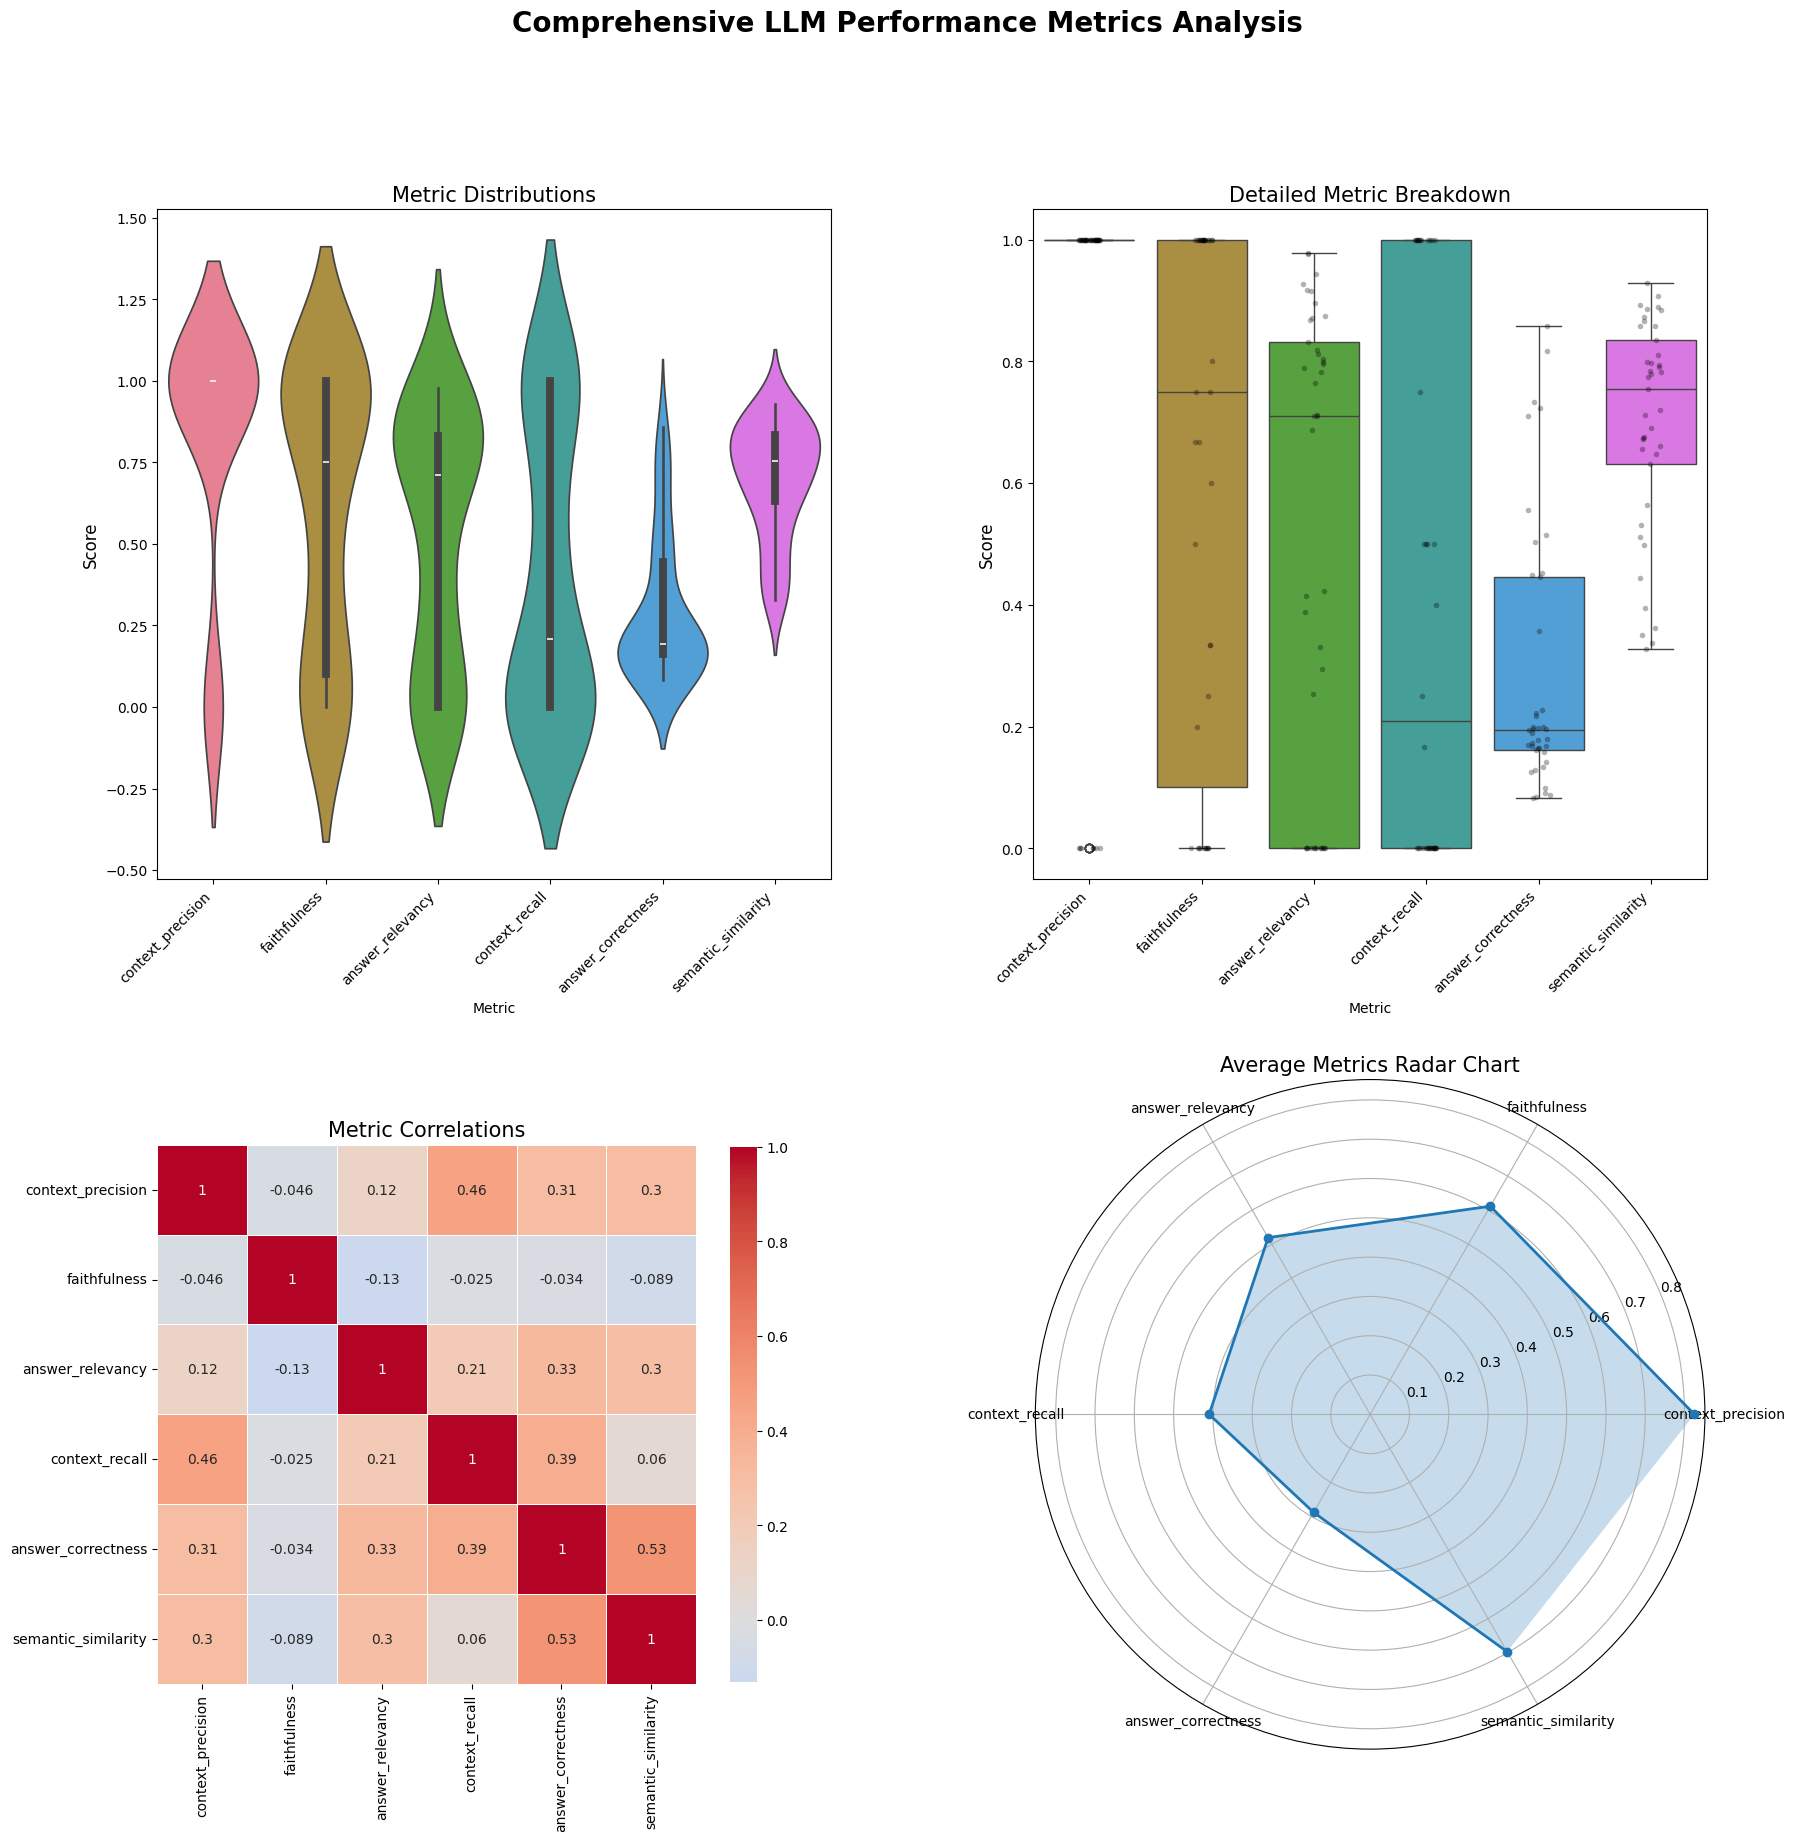

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_metrics(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Select metrics columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Set up a beautiful color palette
    palette = sns.color_palette("husl", 6)
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 20))
    plt.suptitle('Comprehensive LLM Performance Metrics Analysis', fontsize=20, fontweight='bold')
    
    # Adjust subplot layout to make room for the new mean bar plot
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 1. Violin Plot (Distribution)
    plt.subplot(2, 2, 1)
    df_melted = df[metrics_columns].melt(var_name='Metric', value_name='Score')
    sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
    plt.title('Metric Distributions', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 2. Box Plot with Individual Points
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
    sns.stripplot(x='Metric', y='Score', data=df_melted, color='black', size=4, alpha=0.3)
    plt.title('Detailed Metric Breakdown', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 3. Correlation Heatmap
    plt.subplot(2, 2, 3)
    correlation_matrix = df[metrics_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Metric Correlations', fontsize=15)
    
    # 4. Radar Chart
    plt.subplot(2, 2, 4, polar=True)
    mean_metrics = df[metrics_columns].mean()
    
    # Radar chart setup
    angles = [n / float(len(metrics_columns)) * 2 * np.pi for n in range(len(metrics_columns))]
    angles += angles[:1]
    
    values = mean_metrics.tolist()
    values += values[:1]
    
    plt.polar(angles[:-1], values[:-1], 'o-', linewidth=2, label='Mean Metrics')
    plt.fill(angles, values, alpha=0.25)
    plt.xticks(angles[:-1], metrics_columns)
    plt.title('Average Metrics Radar Chart', fontsize=15)
    
    # 5. Mean Values Bar Plot (New subplot)
    plt.subplot(2, 2, 5)
    mean_values = df[metrics_columns].mean()
    plt.bar(metrics_columns, mean_values, color=palette)
    plt.title('Mean Values of Metrics', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Score', fontsize=12)
    
    # Add value labels on top of each bar
    for i, v in enumerate(mean_values):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Detailed Summary Statistics
    print("Comprehensive Metrics Summary:")
    summary = pd.DataFrame({
        'Count': df[metrics_columns].count(),
        'Mean': df[metrics_columns].mean(),
        'Std Dev': df[metrics_columns].std(),
        'Min': df[metrics_columns].min(),
        'Max': df[metrics_columns].max()
    })
    print(summary.round(4))
    
    # Additional Insights
    print("\nAdditional Insights:")
    for metric in metrics_columns:
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {df[metric].mean():.4f}")
        print(f"  Standard Deviation: {df[metric].std():.4f}")
        print(f"  Coefficient of Variation: {(df[metric].std() / df[metric].mean() * 100):.2f}%")
    
    plt.show()

# Usage
plot_comprehensive_metrics('bhadve38_rag_evaluation_results_ragasNEWALL560ALL.xlsx')

C:\Users\offic\AppData\Local\Temp\ipykernel_25904\2554213529.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_25904\2554213529.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)


Comprehensive Metrics Summary:
                     Count    Mean  Std Dev     Min     Max
context_precision       40  0.8250   0.3848  0.0000  1.0000
faithfulness            39  0.6115   0.4293  0.0000  1.0000
answer_relevancy        41  0.5192   0.3832  0.0000  0.9777
context_recall          38  0.4096   0.4483  0.0000  1.0000
answer_correctness      41  0.2880   0.2199  0.0819  0.8574
semantic_similarity     41  0.6976   0.1762  0.3276  0.9294

Additional Insights:
Context Precision:
  Mean: 0.8250
  Standard Deviation: 0.3848
  Coefficient of Variation: 46.64%
Faithfulness:
  Mean: 0.6115
  Standard Deviation: 0.4293
  Coefficient of Variation: 70.20%
Answer Relevancy:
  Mean: 0.5192
  Standard Deviation: 0.3832
  Coefficient of Variation: 73.80%
Context Recall:
  Mean: 0.4096
  Standard Deviation: 0.4483
  Coefficient of Variation: 109.43%
Answer Correctness:
  Mean: 0.2880
  Standard Deviation: 0.2199
  Coefficient of Variation: 76.34%
Semantic Similarity:
  Mean: 0.6976
  Standa

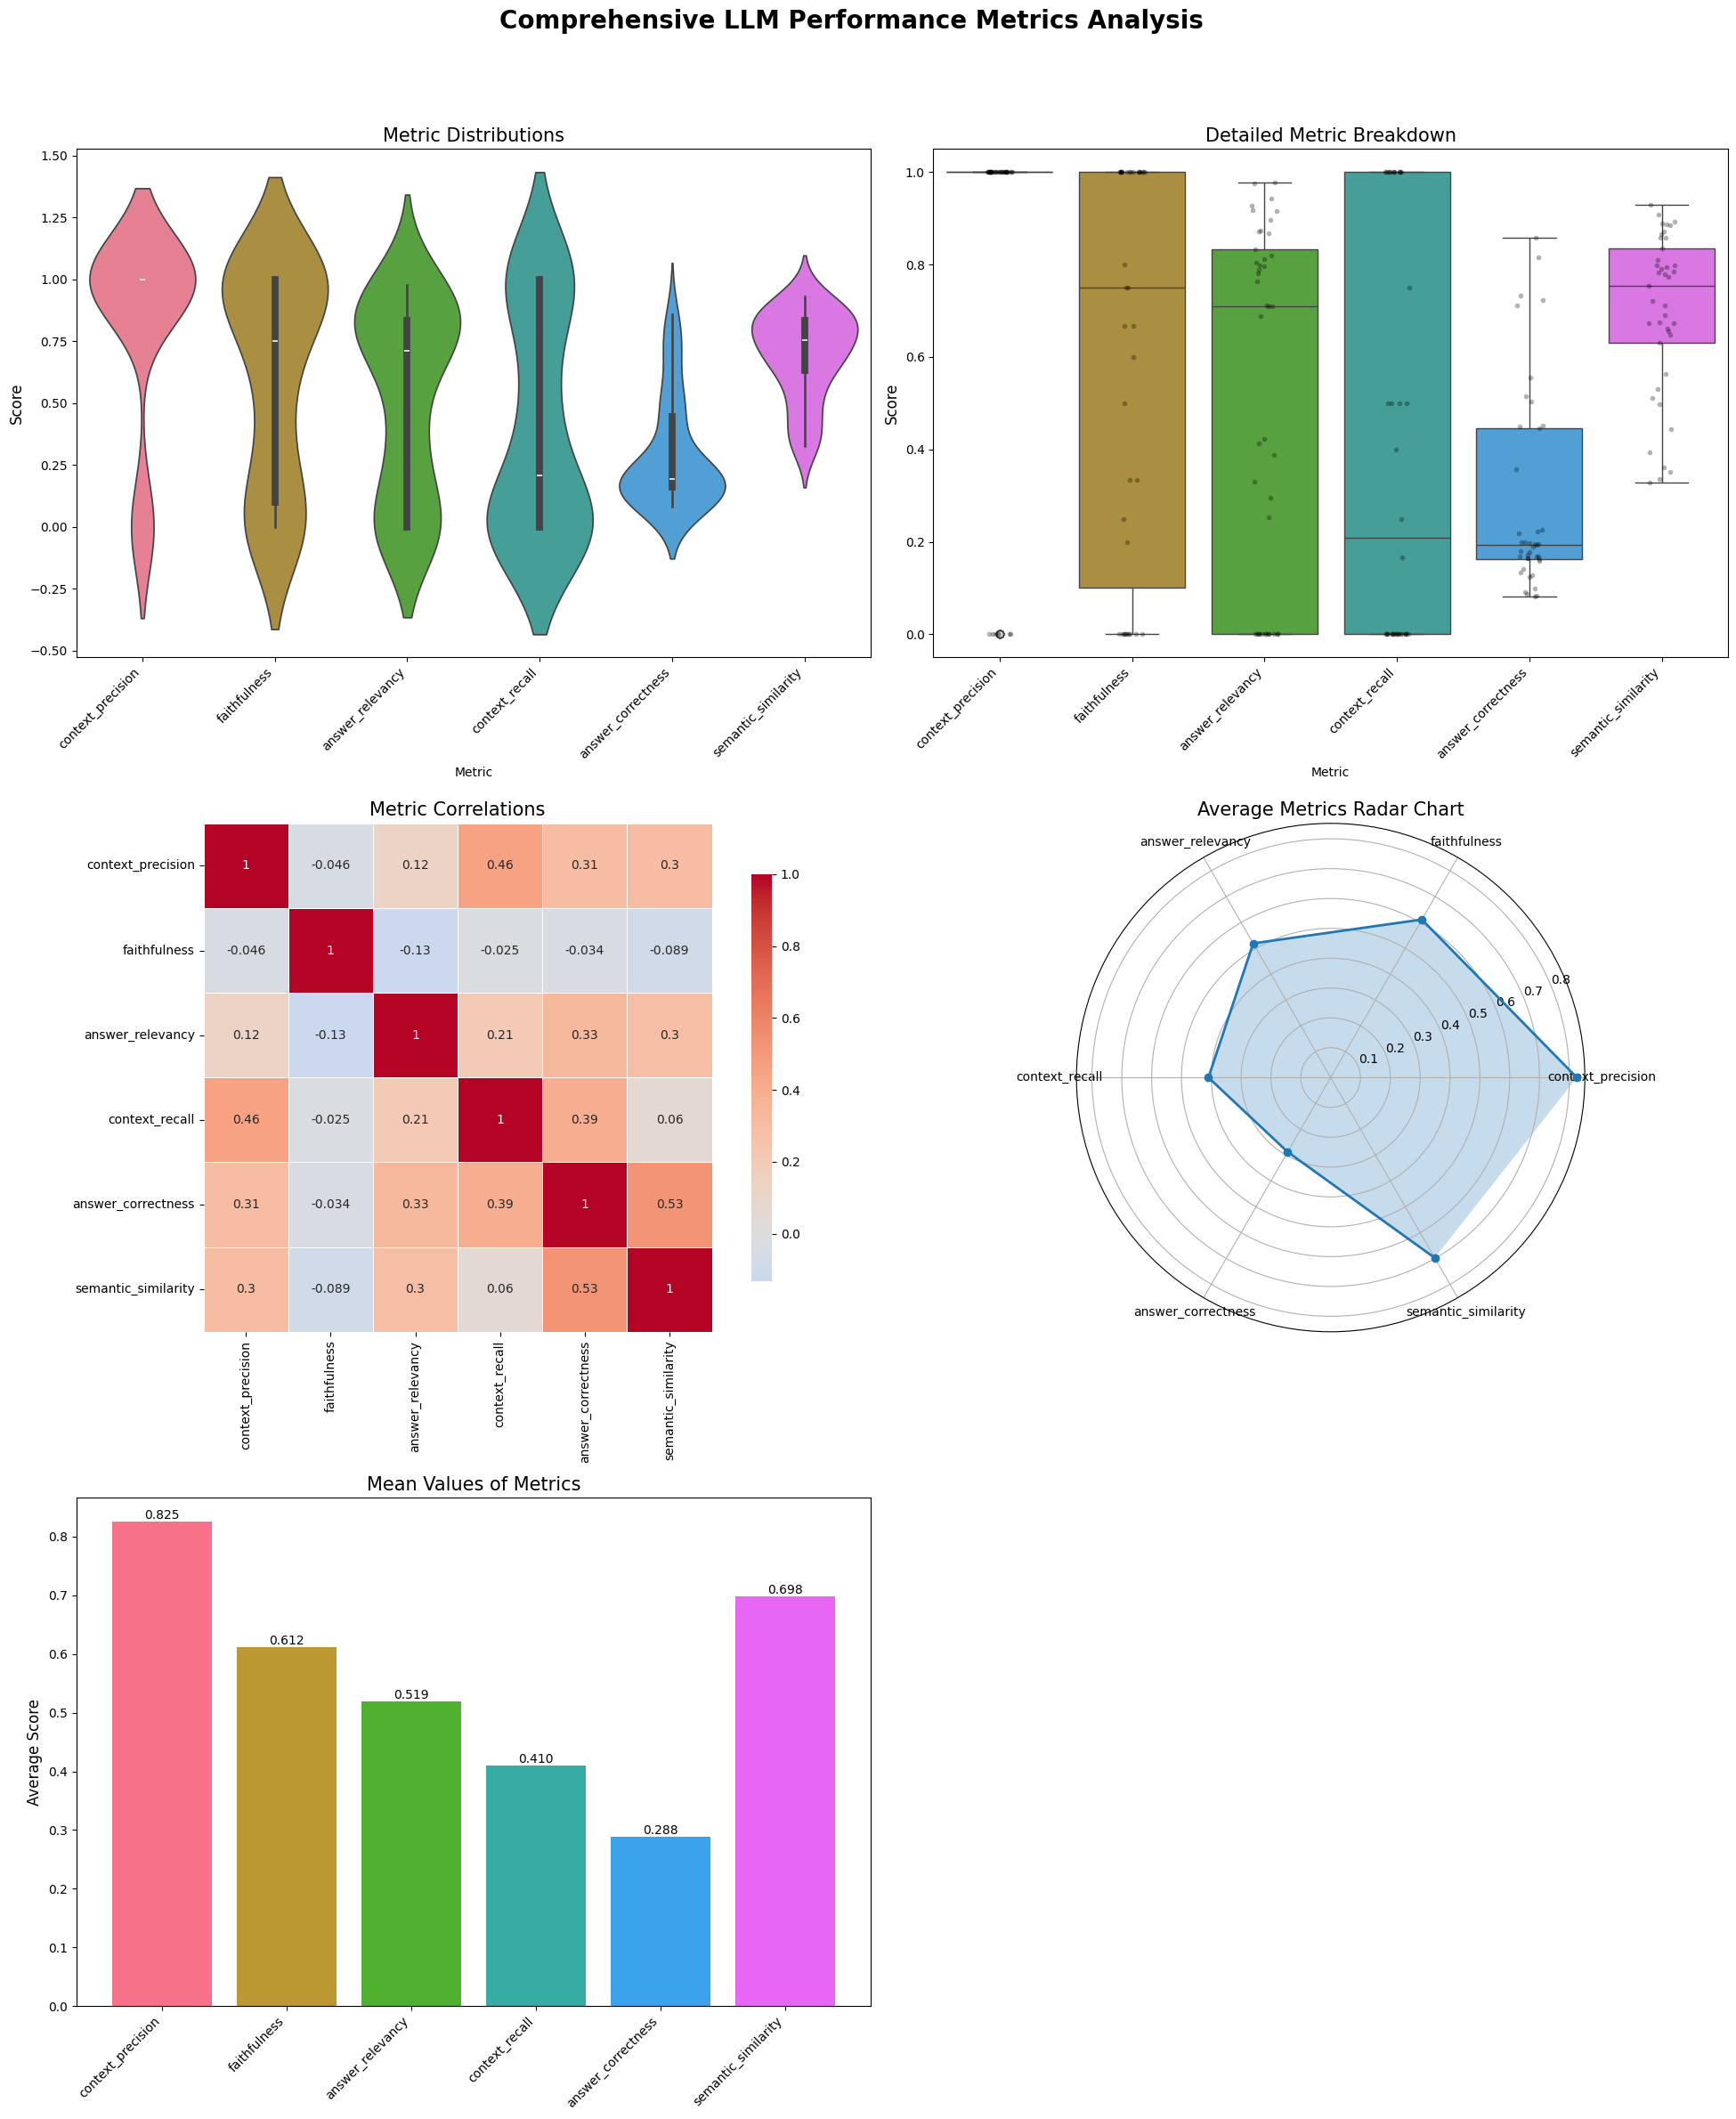

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_metrics(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Select metrics columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Set up a beautiful color palette
    palette = sns.color_palette("husl", 6)
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 25))
    plt.suptitle('Comprehensive LLM Performance Metrics Analysis', fontsize=20, fontweight='bold')
    
    # Adjust subplot layout
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # 1. Violin Plot (Distribution)
    plt.subplot(3, 2, 1)
    df_melted = df[metrics_columns].melt(var_name='Metric', value_name='Score')
    sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
    plt.title('Metric Distributions', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 2. Box Plot with Individual Points
    plt.subplot(3, 2, 2)
    sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
    sns.stripplot(x='Metric', y='Score', data=df_melted, color='black', size=4, alpha=0.3)
    plt.title('Detailed Metric Breakdown', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 3. Correlation Heatmap
    plt.subplot(3, 2, 3)
    correlation_matrix = df[metrics_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Metric Correlations', fontsize=15)
    
    # 4. Radar Chart
    plt.subplot(3, 2, 4, polar=True)
    mean_metrics = df[metrics_columns].mean()
    
    # Radar chart setup
    angles = [n / float(len(metrics_columns)) * 2 * np.pi for n in range(len(metrics_columns))]
    angles += angles[:1]
    
    values = mean_metrics.tolist()
    values += values[:1]
    
    plt.polar(angles[:-1], values[:-1], 'o-', linewidth=2, label='Mean Metrics')
    plt.fill(angles, values, alpha=0.25)
    plt.xticks(angles[:-1], metrics_columns)
    plt.title('Average Metrics Radar Chart', fontsize=15)
    
    # 5. Mean Values Bar Plot
    plt.subplot(3, 2, 5)
    mean_values = df[metrics_columns].mean()
    plt.bar(metrics_columns, mean_values, color=palette)
    plt.title('Mean Values of Metrics', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Score', fontsize=12)
    
    # Add value labels on top of each bar
    for i, v in enumerate(mean_values):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Detailed Summary Statistics
    print("Comprehensive Metrics Summary:")
    summary = pd.DataFrame({
        'Count': df[metrics_columns].count(),
        'Mean': df[metrics_columns].mean(),
        'Std Dev': df[metrics_columns].std(),
        'Min': df[metrics_columns].min(),
        'Max': df[metrics_columns].max()
    })
    print(summary.round(4))
    
    # Additional Insights
    print("\nAdditional Insights:")
    for metric in metrics_columns:
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {df[metric].mean():.4f}")
        print(f"  Standard Deviation: {df[metric].std():.4f}")
        print(f"  Coefficient of Variation: {(df[metric].std() / df[metric].mean() * 100):.2f}%")
    
    plt.show()

# Usage
df = pd.read_excel(file_path)
plot_comprehensive_metrics('bhadve38_rag_evaluation_results_ragasNEWALL560ALL.xlsx')

C:\Users\offic\AppData\Local\Temp\ipykernel_25904\2320562851.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_25904\2320562851.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_25904\2320562851.py:62: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Comprehensive Metrics Summary:
                     Count    Mean  Median  Std Dev     Min     Max
context_precision       40  0.8250  1.0000   0.3848  0.0000  1.0000
faithfulness            39  0.6115  0.7500   0.4293  0.0000  1.0000
answer_relevancy        41  0.5192  0.7103   0.3832  0.0000  0.9777
context_recall          38  0.4096  0.2083   0.4483  0.0000  1.0000
answer_correctness      41  0.2880  0.1935   0.2199  0.0819  0.8574
semantic_similarity     41  0.6976  0.7546   0.1762  0.3276  0.9294

Additional Insights:
Context Precision:
  Mean: 0.8250
  Median: 1.0000
  Standard Deviation: 0.3848
  Coefficient of Variation: 46.64%
Faithfulness:
  Mean: 0.6115
  Median: 0.7500
  Standard Deviation: 0.4293
  Coefficient of Variation: 70.20%
Answer Relevancy:
  Mean: 0.5192
  Median: 0.7103
  Standard Deviation: 0.3832
  Coefficient of Variation: 73.80%
Context Recall:
  Mean: 0.4096
  Median: 0.2083
  Standard Deviation: 0.4483
  Coefficient of Variation: 109.43%
Answer Correctness:

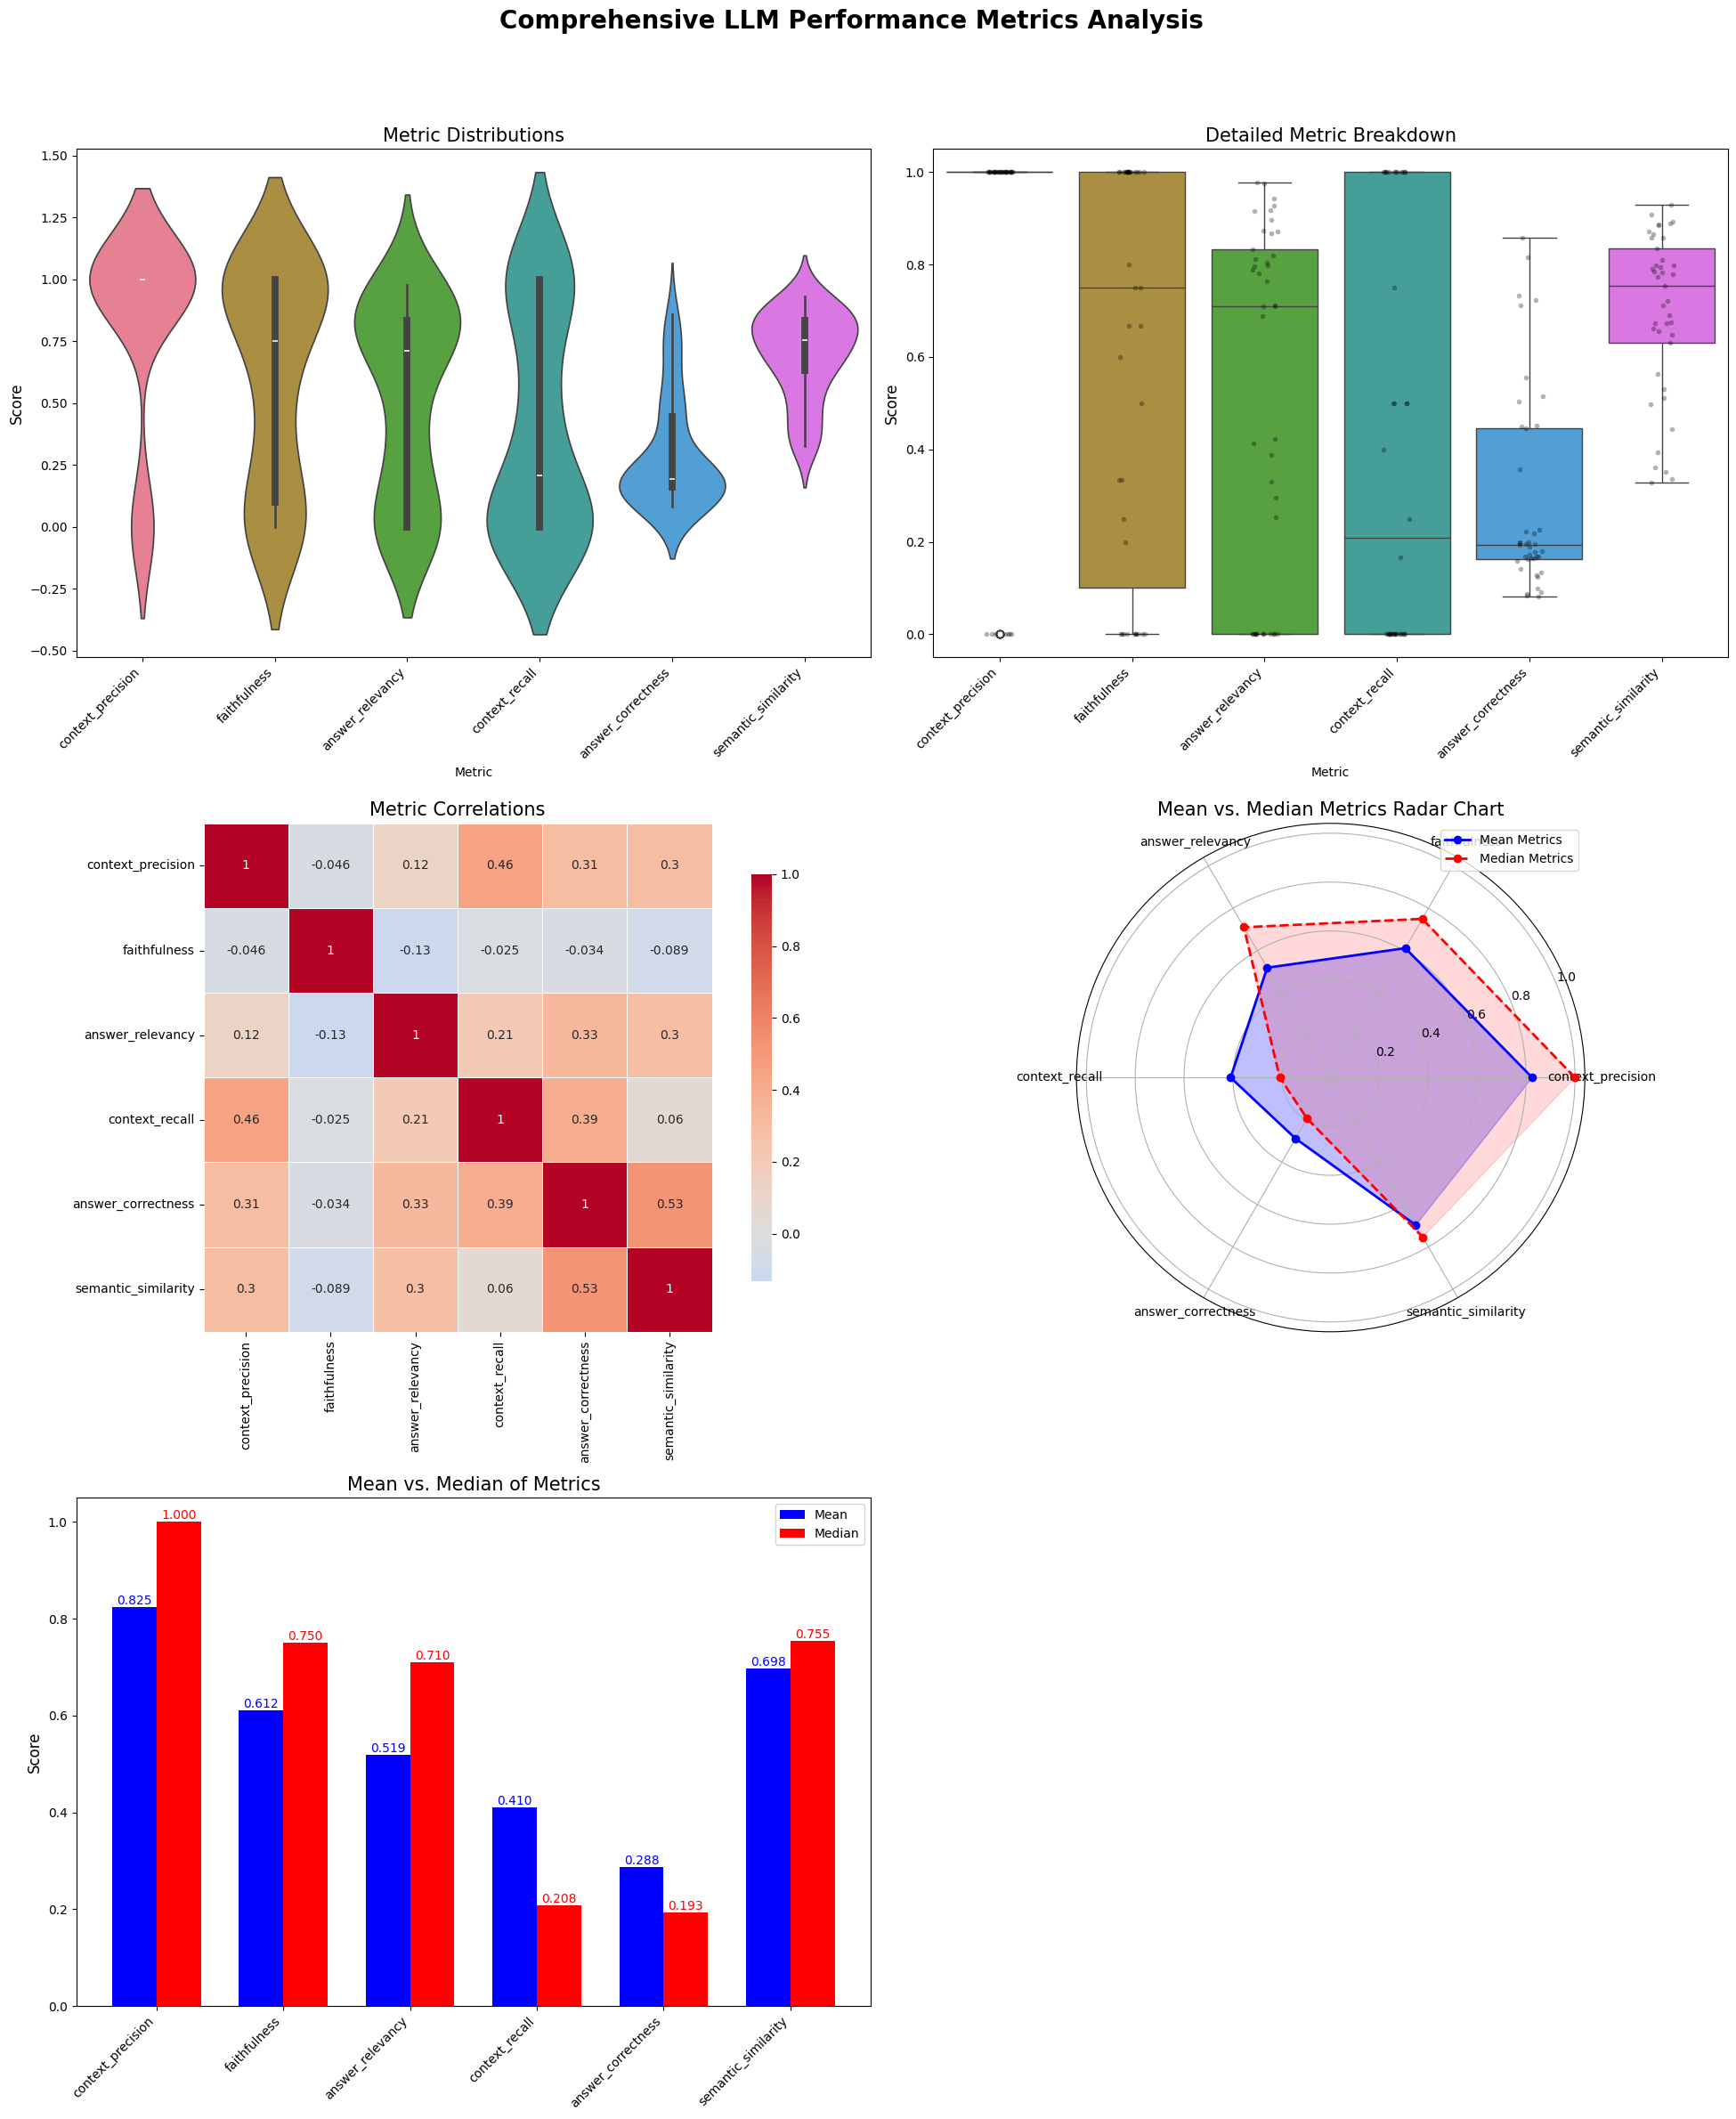

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_metrics(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Select metrics columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Set up a beautiful color palette
    palette = sns.color_palette("husl", 6)
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 25))
    plt.suptitle('Comprehensive LLM Performance Metrics Analysis', fontsize=20, fontweight='bold')
    
    # Adjust subplot layout
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # 1. Violin Plot (Distribution)
    plt.subplot(3, 2, 1)
    df_melted = df[metrics_columns].melt(var_name='Metric', value_name='Score')
    sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
    plt.title('Metric Distributions', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 2. Box Plot with Individual Points
    plt.subplot(3, 2, 2)
    sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
    sns.stripplot(x='Metric', y='Score', data=df_melted, color='black', size=4, alpha=0.3)
    plt.title('Detailed Metric Breakdown', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score', fontsize=12)
    
    # 3. Correlation Heatmap
    plt.subplot(3, 2, 3)
    correlation_matrix = df[metrics_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Metric Correlations', fontsize=15)
    
    # 4. Radar Chart
    plt.subplot(3, 2, 4, polar=True)
    mean_metrics = df[metrics_columns].mean()
    median_metrics = df[metrics_columns].median()
    
    # Radar chart setup
    angles = [n / float(len(metrics_columns)) * 2 * np.pi for n in range(len(metrics_columns))]
    angles += angles[:1]
    
    mean_values = mean_metrics.tolist() + mean_metrics.tolist()[:1]
    median_values = median_metrics.tolist() + median_metrics.tolist()[:1]
    
    plt.polar(angles[:-1], mean_values[:-1], 'o-', linewidth=2, label='Mean Metrics', color='blue')
    plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red')
    plt.fill(angles, mean_values, alpha=0.25, color='blue')
    plt.fill(angles, median_values, alpha=0.15, color='red')
    plt.xticks(angles[:-1], metrics_columns)
    plt.title('Mean vs. Median Metrics Radar Chart', fontsize=15)
    plt.legend()
    
    # 5. Mean & Median Bar Plot
    plt.subplot(3, 2, 5)
    mean_values = df[metrics_columns].mean()
    median_values = df[metrics_columns].median()
    
    x = np.arange(len(metrics_columns))
    width = 0.35  # Bar width
    
    plt.bar(x - width/2, mean_values, width, label='Mean', color='blue')
    plt.bar(x + width/2, median_values, width, label='Median', color='red')
    
    plt.xticks(x, metrics_columns, rotation=45, ha='right')
    plt.title('Mean vs. Median of Metrics', fontsize=15)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    
    # Add value labels
    for i, v in enumerate(mean_values):
        plt.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom', fontsize=10, color='blue')
    for i, v in enumerate(median_values):
        plt.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom', fontsize=10, color='red')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Detailed Summary Statistics
    print("Comprehensive Metrics Summary:")
    summary = pd.DataFrame({
        'Count': df[metrics_columns].count(),
        'Mean': df[metrics_columns].mean(),
        'Median': df[metrics_columns].median(),
        'Std Dev': df[metrics_columns].std(),
        'Min': df[metrics_columns].min(),
        'Max': df[metrics_columns].max()
    })
    print(summary.round(4))
    
    # Additional Insights
    print("\nAdditional Insights:")
    for metric in metrics_columns:
        mean_val = df[metric].mean()
        median_val = df[metric].median()
        std_dev = df[metric].std()
        coeff_var = (std_dev / mean_val * 100) if mean_val != 0 else 0
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Median: {median_val:.4f}")
        print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Coefficient of Variation: {coeff_var:.2f}%")
    
    plt.show()

# Usage
plot_comprehensive_metrics('bhadve38_rag_evaluation_results_ragasNEWALL560ALL.xlsx')


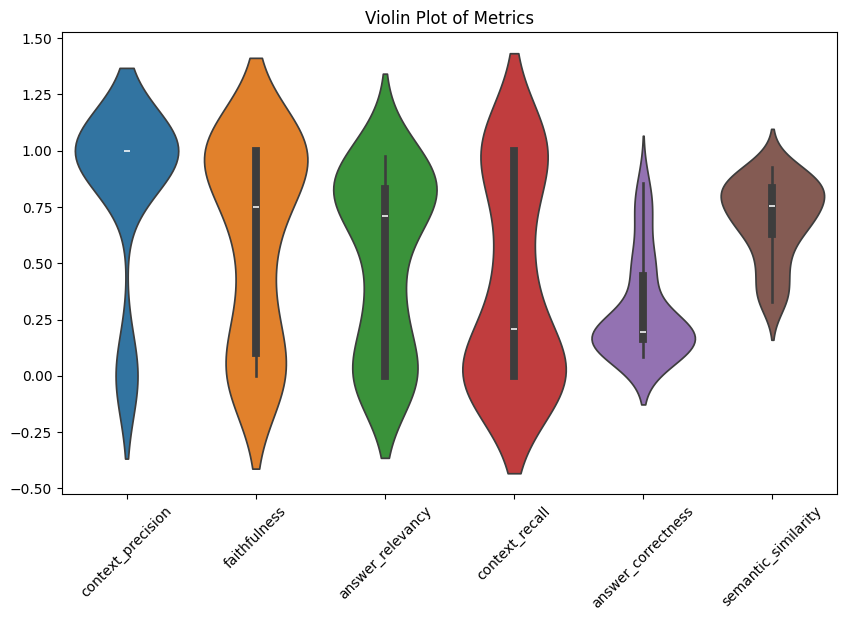

In [8]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[['context_precision', 'faithfulness', 'answer_relevancy', 
                        'context_recall', 'answer_correctness', 'semantic_similarity']])
plt.xticks(rotation=45)
plt.title('Violin Plot of Metrics')
plt.show()



Category-wise Metrics Summary:
             Category  Mean_context_precision  Mean_faithfulness  \
0         ### FACTUAL                  0.6667             0.8611   
1      ### NONFACTUAL                  1.0000             0.8125   
2       ### Inference                  1.0000             0.3333   
3  ### Counterfactual                  1.0000             0.3333   
4     ### COMPARITIVE                  1.0000             0.3000   
5        ### TEMPORAL                  0.7500             0.5500   
6       ### AMBIGUOUS                  0.0000             0.6667   
7       ### CAUSALITY                  1.0000             0.7500   
8        ### Dialogue                  1.0000             0.4667   
9             ### NER                  0.7143             0.7262   

   Mean_answer_relevancy  Mean_context_recall  Mean_answer_correctness  \
0                 0.3230               0.3000                   0.3137   
1                 0.5260               0.4375                   0.4744 

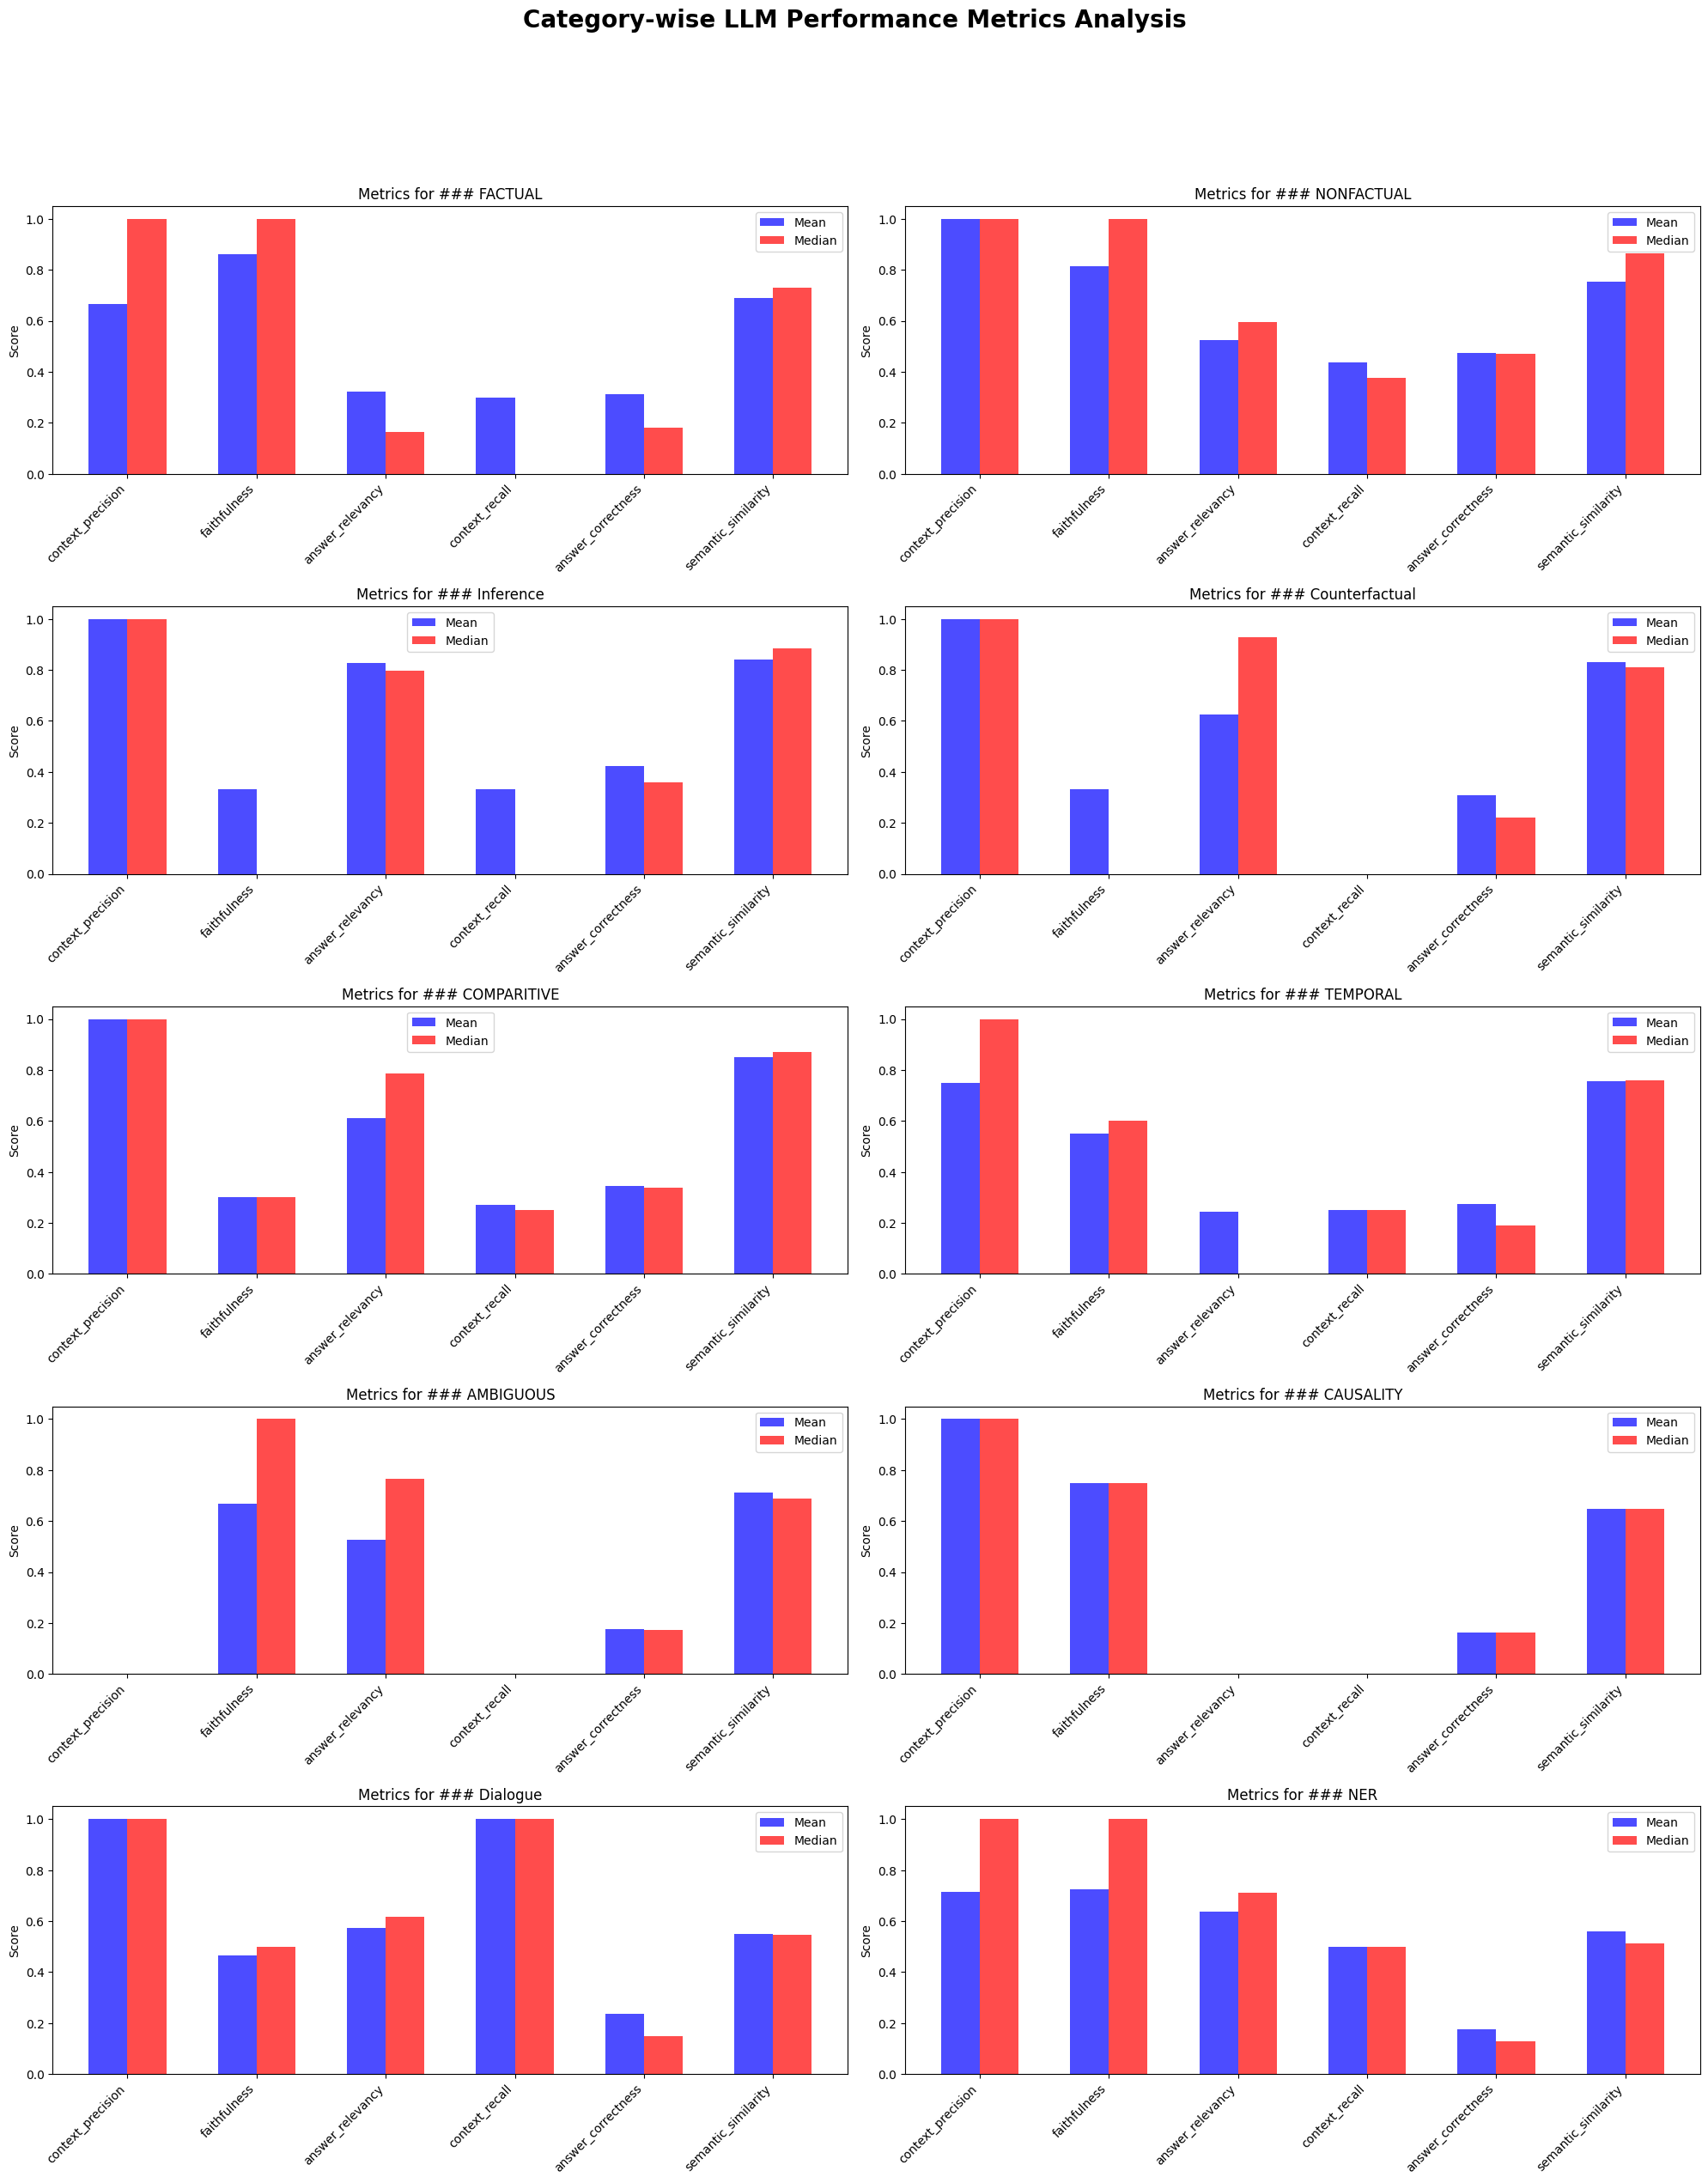

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_category_wise_metrics(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Select metric columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Identify unique categories in the first column
    df['Category'] = df.iloc[:, 0].where(df.iloc[:, 0].str.startswith('###')).ffill()
    categories = df['Category'].unique()
    
    # Prepare to store summary metrics
    summary_data = []
    
    # Create a figure for plots
    plt.figure(figsize=(20, len(categories) * 5))
    plt.suptitle('Category-wise LLM Performance Metrics Analysis', fontsize=20, fontweight='bold')
    
    # Iterate through categories
    for i, category in enumerate(categories, 1):
        category_df = df[df['Category'] == category]
        
        # Compute Mean & Median for category
        mean_values = category_df[metrics_columns].mean()
        median_values = category_df[metrics_columns].median()
        summary_data.append([category] + mean_values.tolist() + median_values.tolist())
        
        # Subplot for each category
        plt.subplot(len(categories), 2, i)
        x = np.arange(len(metrics_columns))
        width = 0.3
        
        plt.bar(x - width/2, mean_values, width, label='Mean', color='blue', alpha=0.7)
        plt.bar(x + width/2, median_values, width, label='Median', color='red', alpha=0.7)
        plt.xticks(x, metrics_columns, rotation=45, ha='right')
        plt.ylabel('Score')
        plt.title(f'Metrics for {category}')
        plt.legend()
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame(summary_data, columns=['Category'] + 
                              [f'Mean_{m}' for m in metrics_columns] + 
                              [f'Median_{m}' for m in metrics_columns])
    
    print("\nCategory-wise Metrics Summary:")
    print(summary_df.round(4))
    
    plt.show()
    
# Usage
plot_category_wise_metrics('seperated_bhadve.xlsx')



=== Processing Metrics for: ### FACTUAL ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### FACTUAL
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        6  0.6667  1.0000   0.5164  0.0000  1.0000
faithfulness             6  0.8611  1.0000   0.2215  0.5000  1.0000
answer_relevancy         6  0.3230  0.1650   0.3982  0.0000  0.8961
context_recall           5  0.3000  0.0000   0.4472  0.0000  1.0000
answer_correctness       6  0.3137  0.1821   0.2755  0.0878  0.8165
semantic_similarity      6  0.6880  0.7286   0.1831  0.3511  0.8660

Additional Insights:
Context Precision:
  Mean: 0.6667
  Median: 1.0000
  Standard Deviation: 0.5164
  Coefficient of Variation: 77.46%
Faithfulness:
  Mean: 0.8611
  Median: 1.0000
  Standard Deviation: 0.2215
  Coefficient of Variation: 25.73%
Answer Relevancy:
  Mean: 0.3230
  Median: 0.1650
  Standard Deviation: 0.3982
  Coefficient of Variation: 123.27%
Context Recall:
  Mean: 0.3000
  Median: 0.0000
  Standard Deviation: 0.4472
  Coefficient of Variation: 149.07%
Answer Correctne

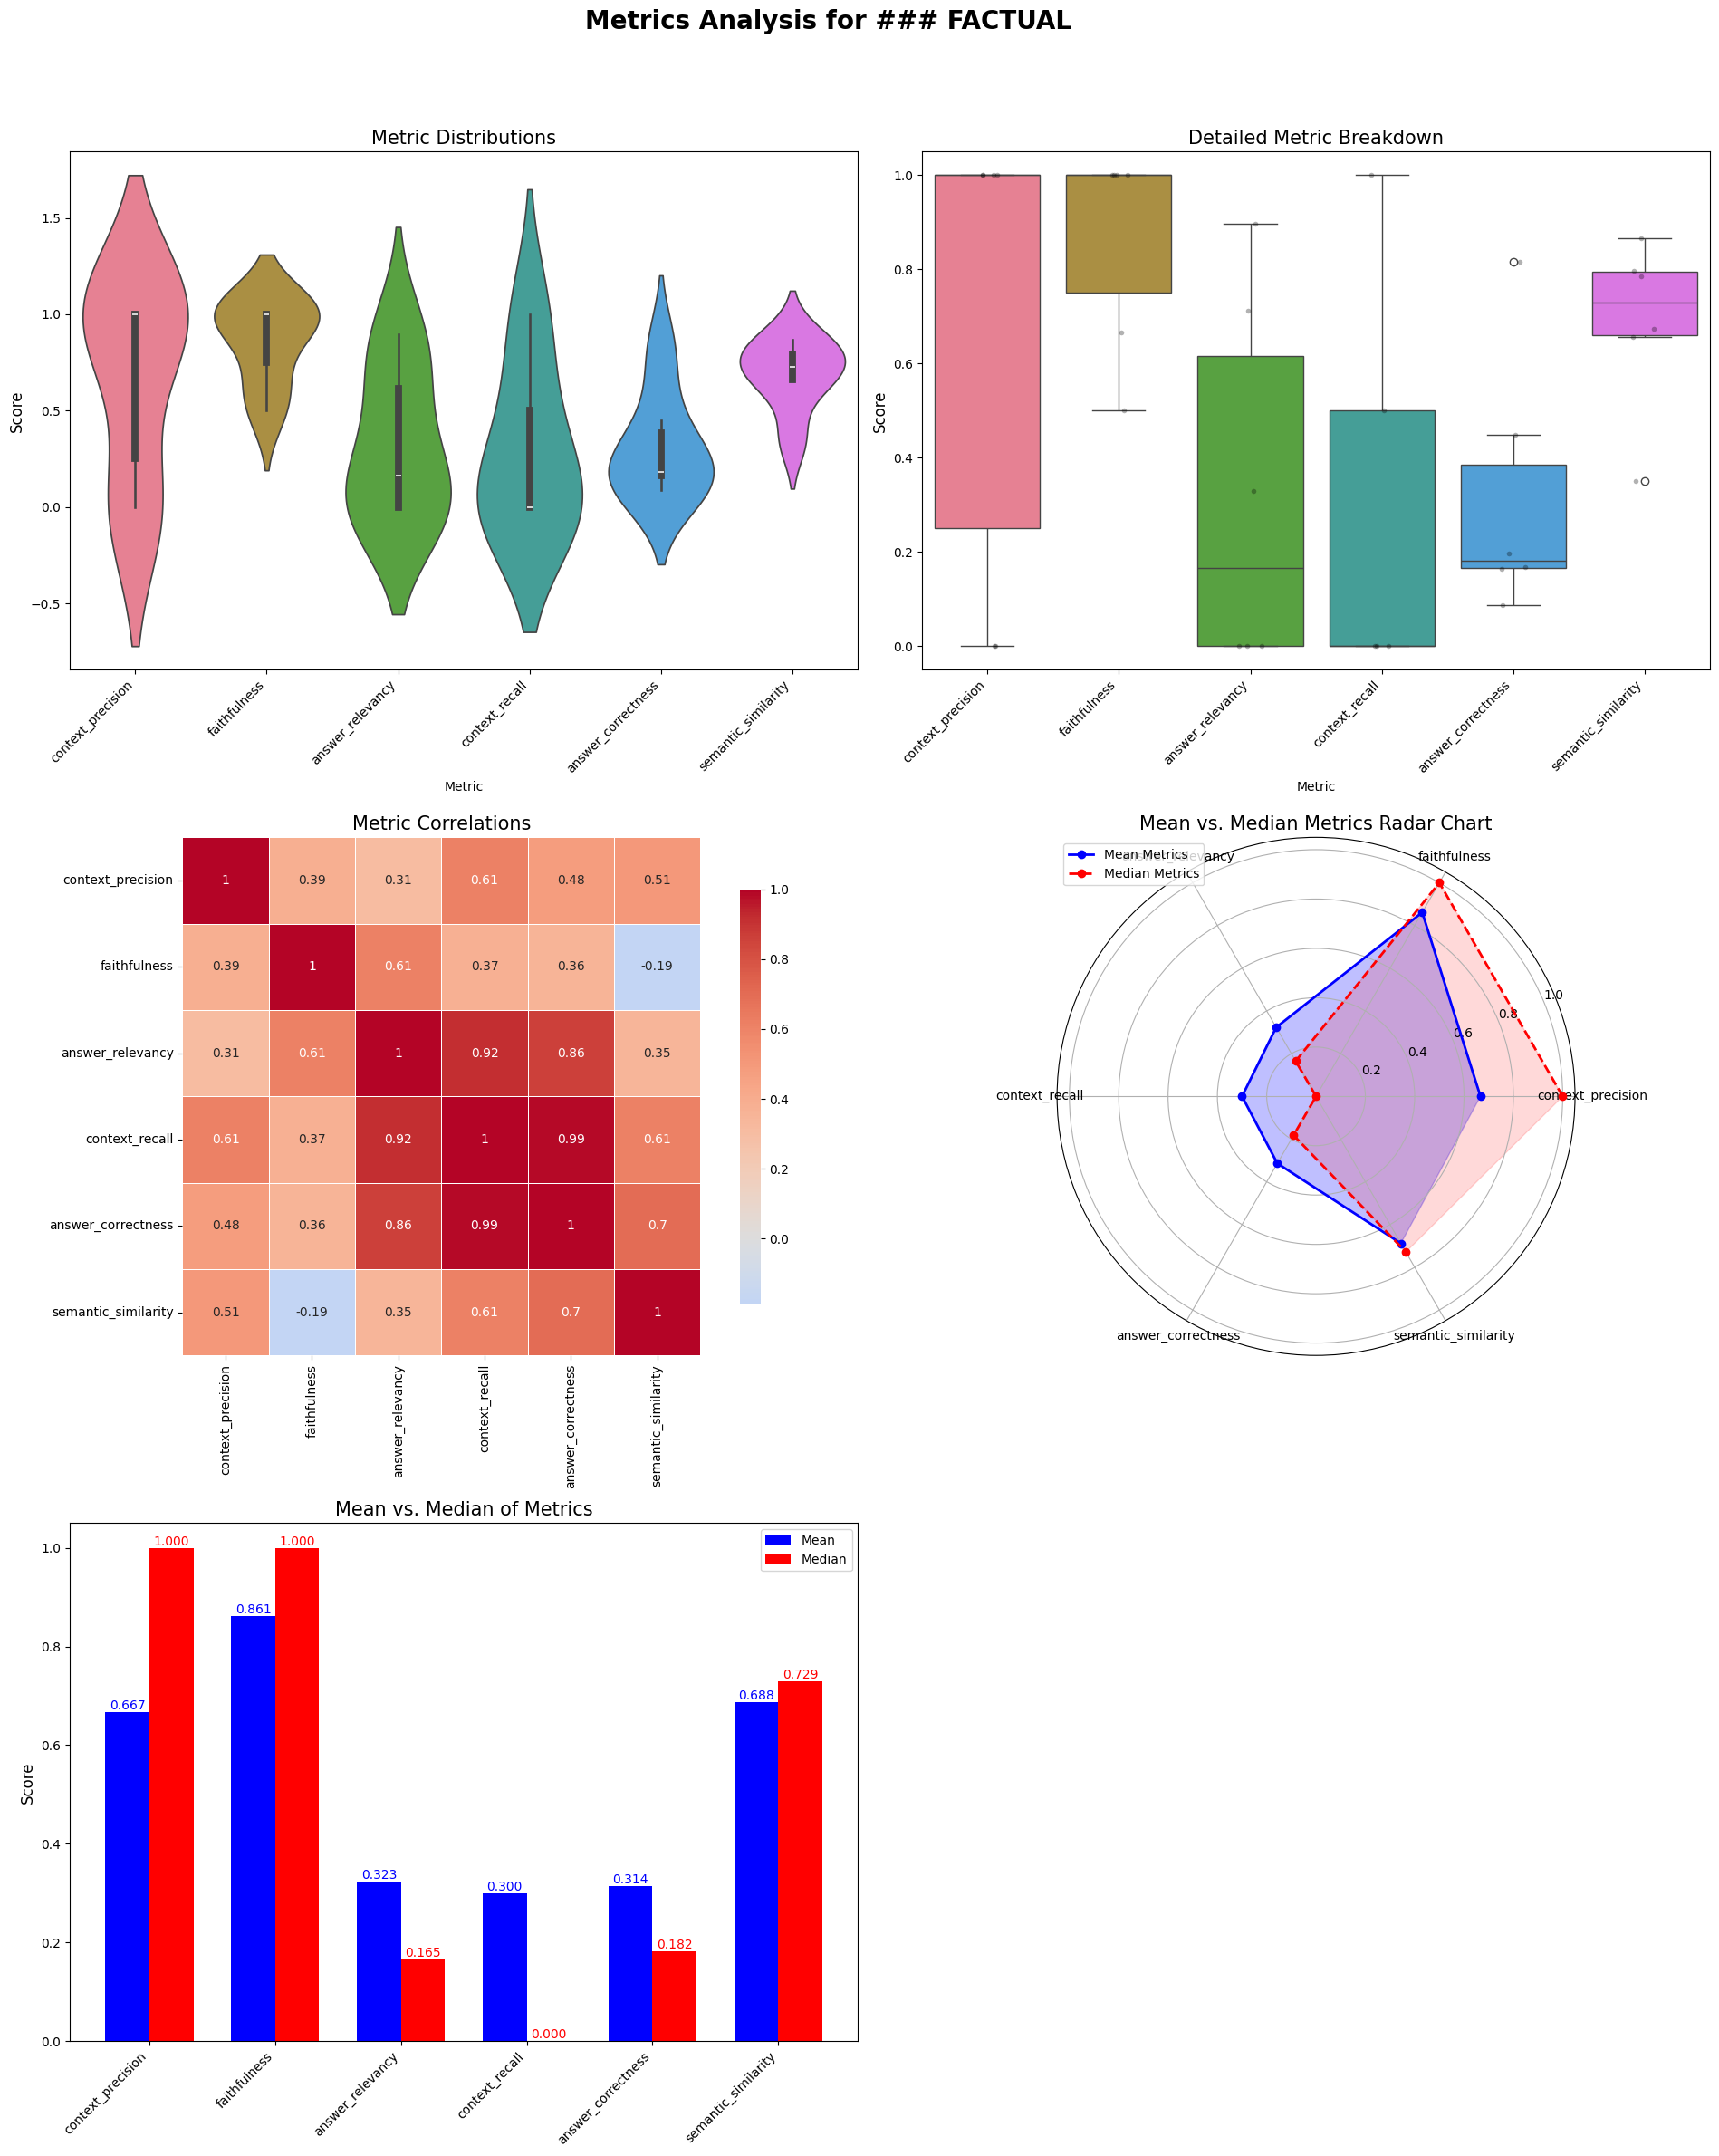


=== Processing Metrics for: ### NONFACTUAL ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### NONFACTUAL
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        4  1.0000  1.0000   0.0000  1.0000  1.0000
faithfulness             4  0.8125  1.0000   0.3750  0.2500  1.0000
answer_relevancy         4  0.5260  0.5938   0.4173  0.0000  0.9163
context_recall           4  0.4375  0.3750   0.5154  0.0000  1.0000
answer_correctness       4  0.4744  0.4707   0.3722  0.0987  0.8574
semantic_similarity      4  0.7546  0.8651   0.2403  0.3947  0.8933

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.8125
  Median: 1.0000
  Standard Deviation: 0.3750
  Coefficient of Variation: 46.15%
Answer Relevancy:
  Mean: 0.5260
  Median: 0.5938
  Standard Deviation: 0.4173
  Coefficient of Variation: 79.34%
Context Recall:
  Mean: 0.4375
  Median: 0.3750
  Standard Deviation: 0.5154
  Coefficient of Variation: 117.80%
Answer Correctn

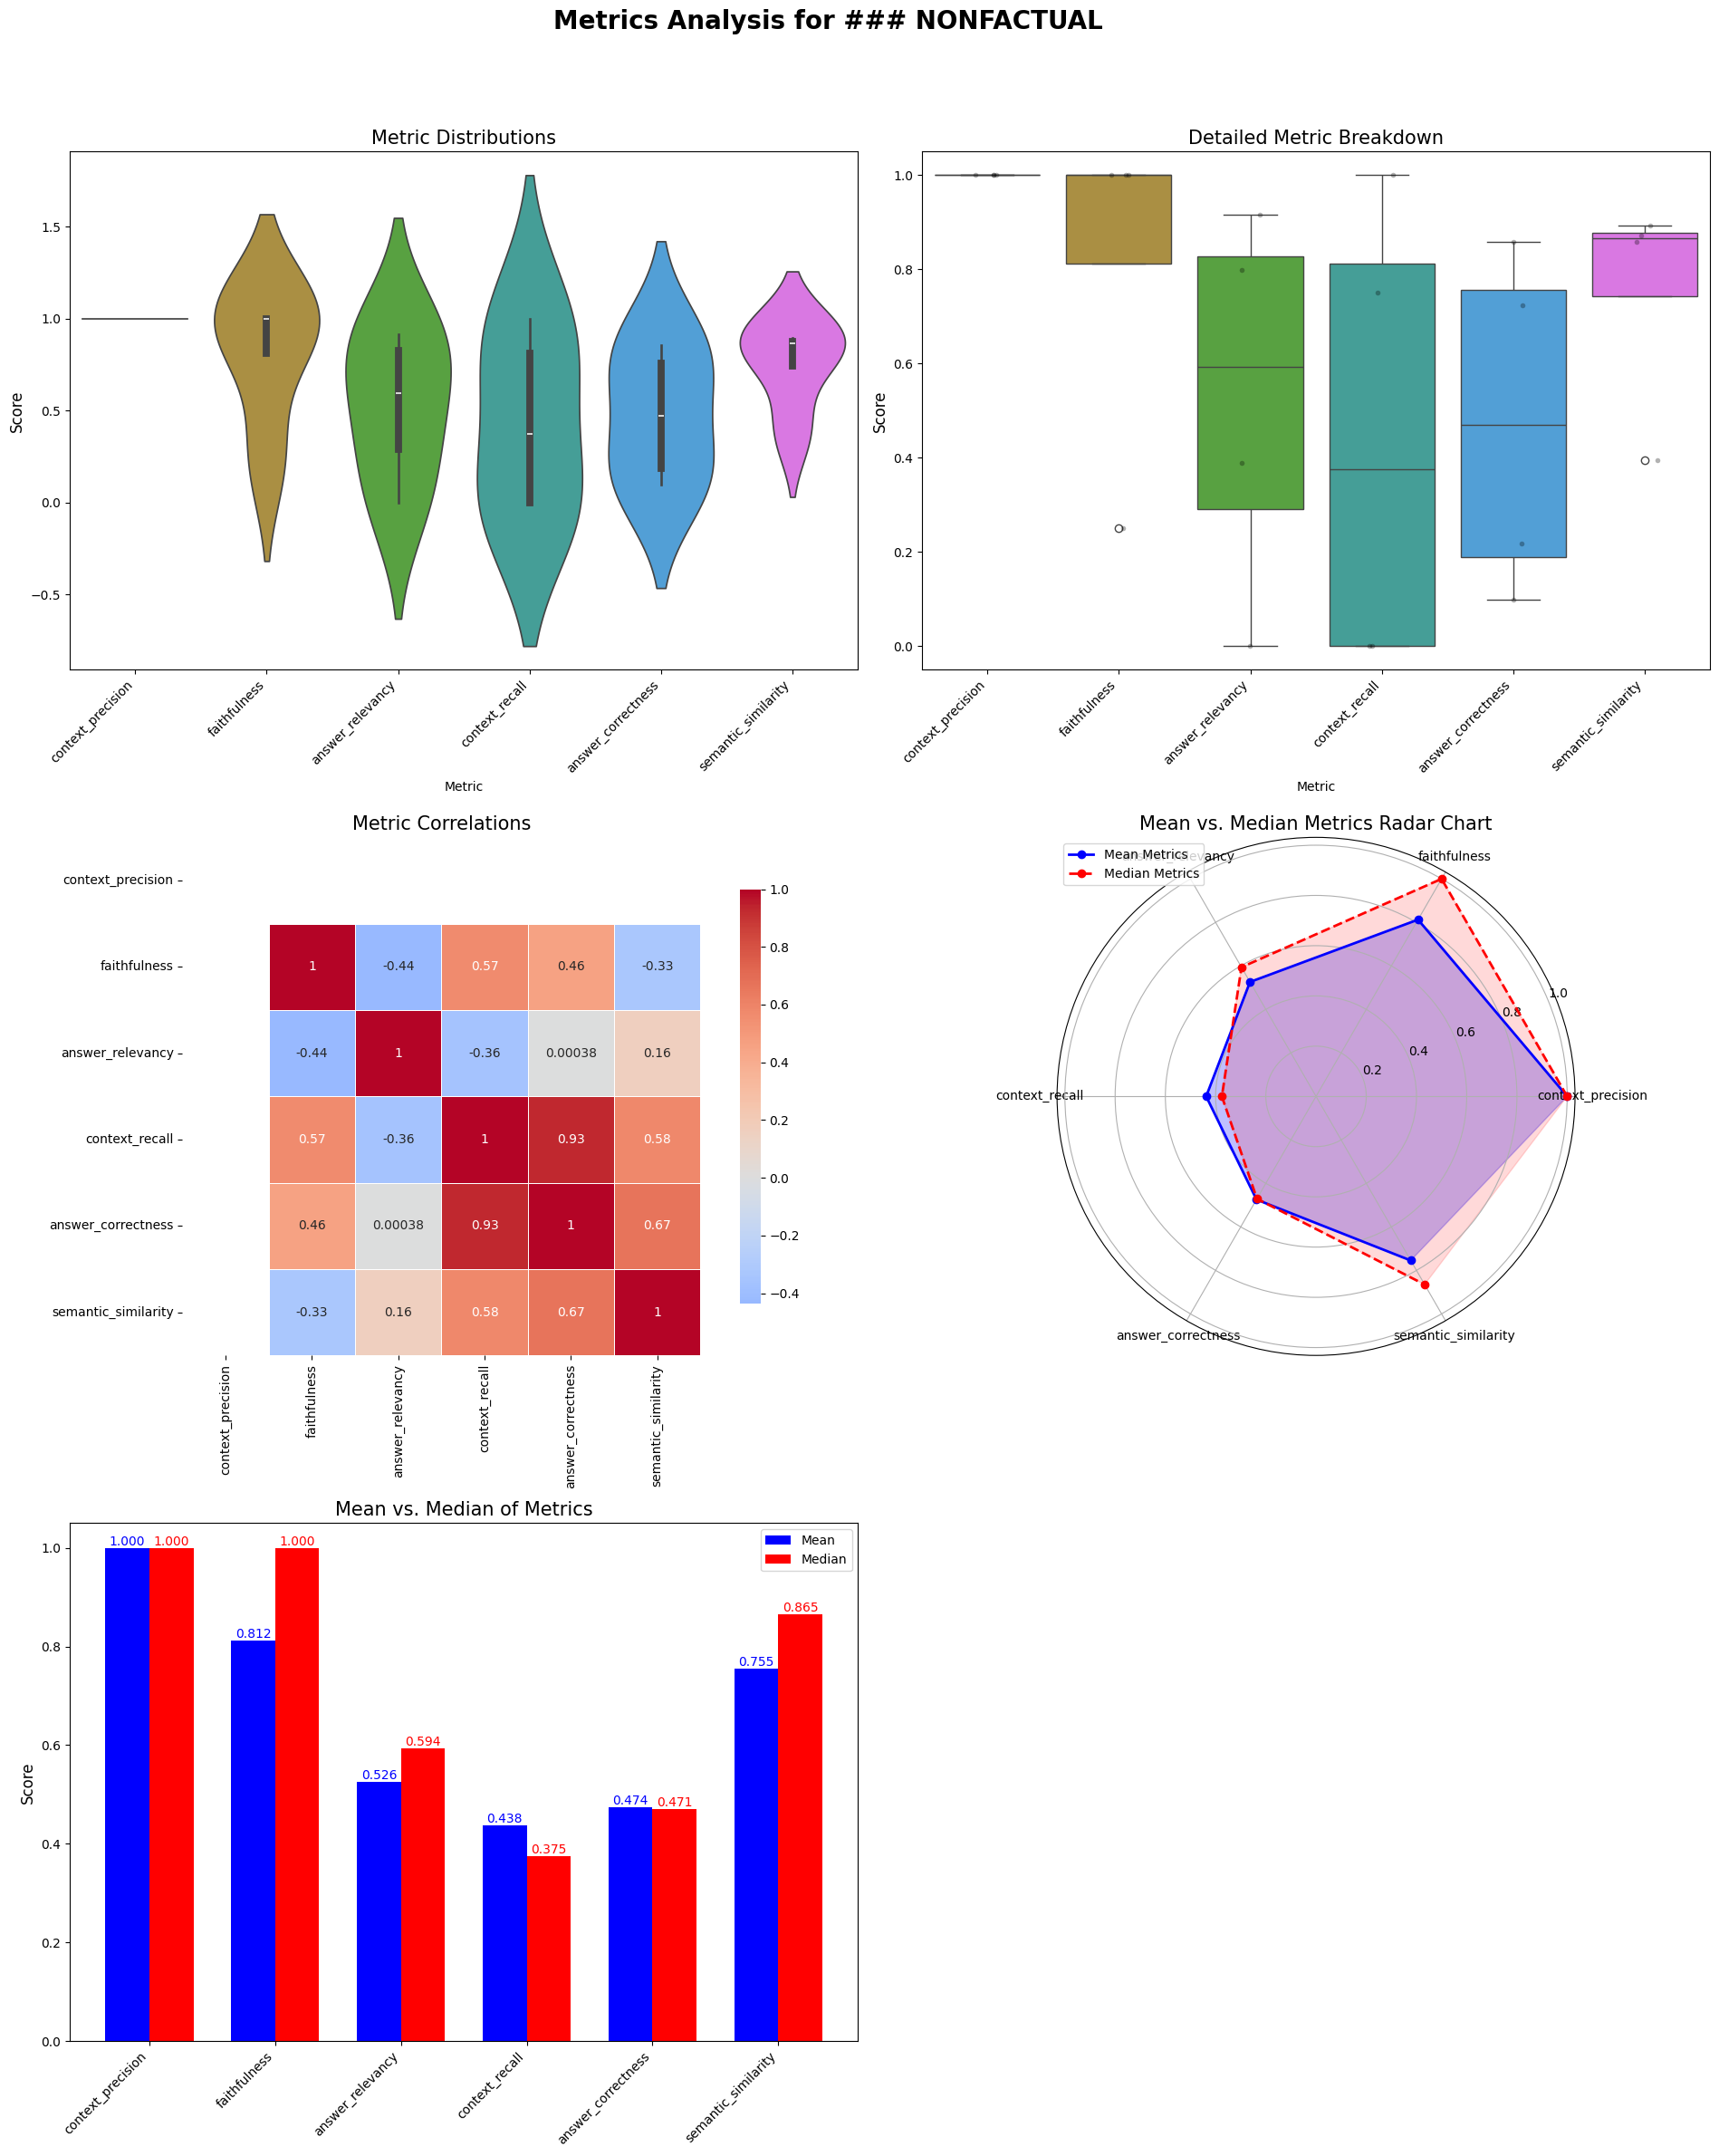


=== Processing Metrics for: ### Inference ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### Inference
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        3  1.0000  1.0000   0.0000  1.0000  1.0000
faithfulness             3  0.3333  0.0000   0.5774  0.0000  1.0000
answer_relevancy         3  0.8279  0.7958   0.1366  0.7103  0.9777
context_recall           3  0.3333  0.0000   0.5774  0.0000  1.0000
answer_correctness       3  0.4226  0.3575   0.2829  0.1779  0.7323
semantic_similarity      3  0.8418  0.8846   0.1151  0.7114  0.9294

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.3333
  Median: 0.0000
  Standard Deviation: 0.5774
  Coefficient of Variation: 173.21%
Answer Relevancy:
  Mean: 0.8279
  Median: 0.7958
  Standard Deviation: 0.1366
  Coefficient of Variation: 16.50%
Context Recall:
  Mean: 0.3333
  Median: 0.0000
  Standard Deviation: 0.5774
  Coefficient of Variation: 173.21%
Answer Correctn

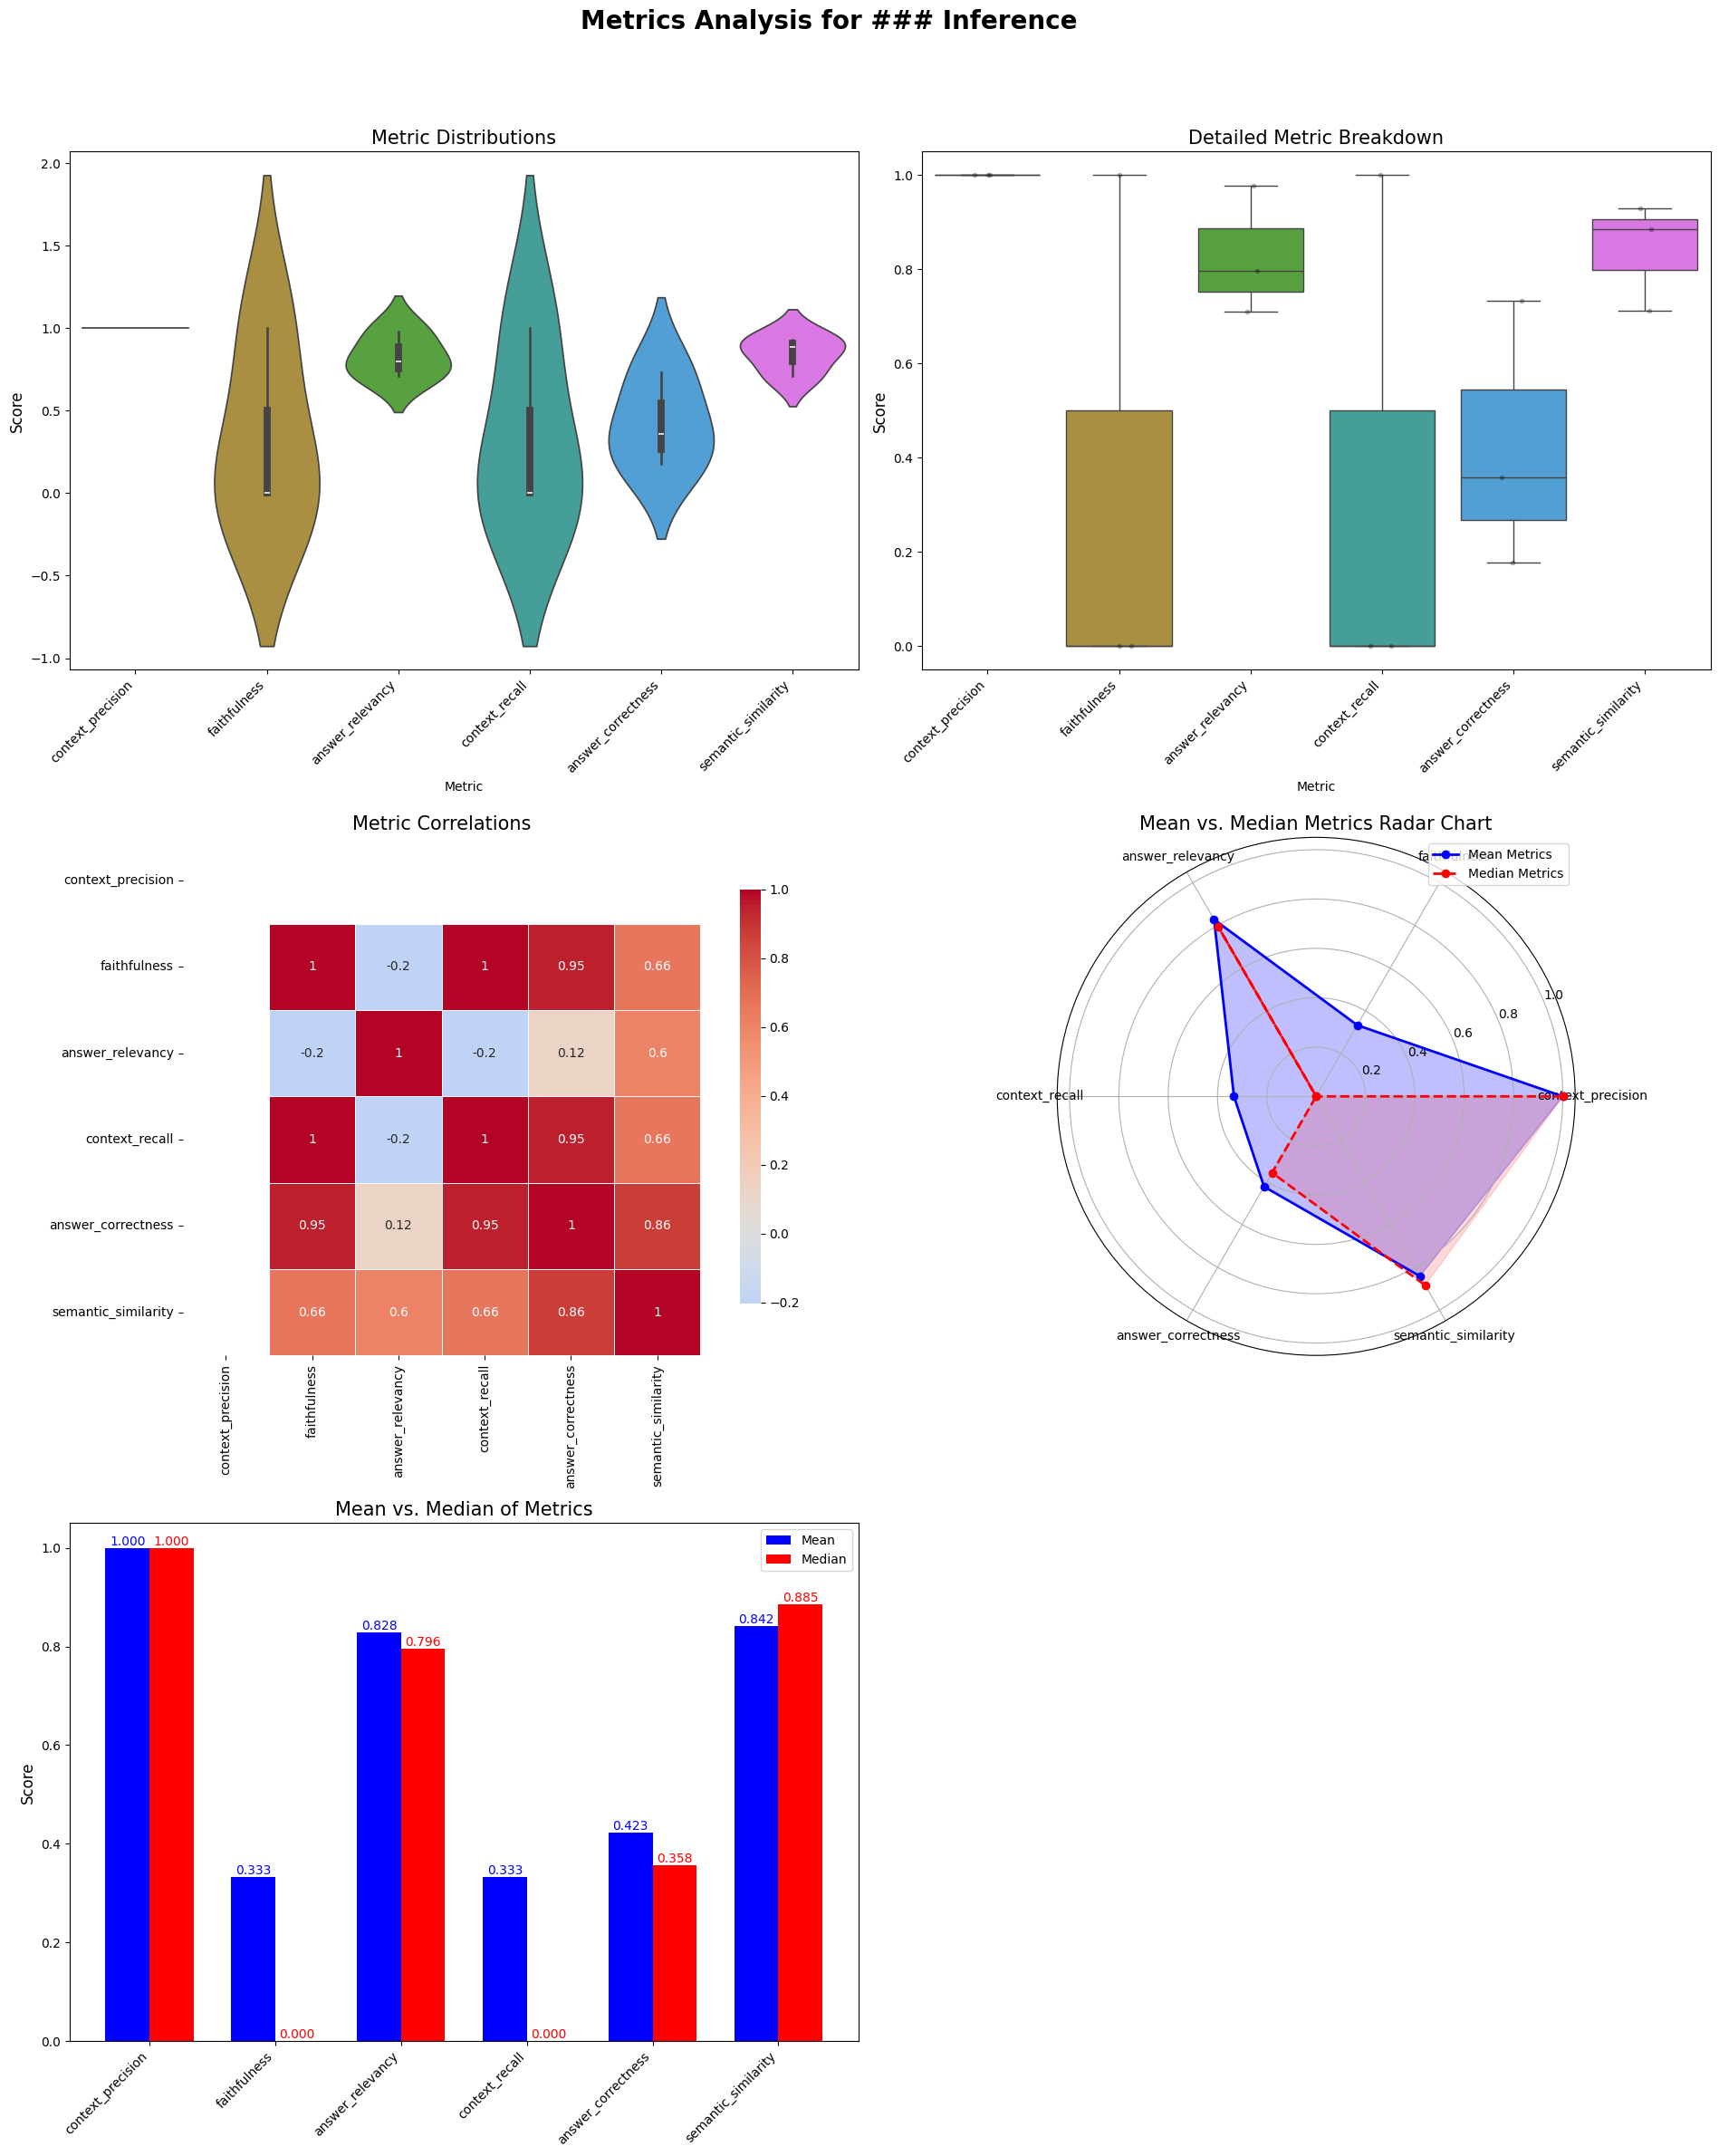


=== Processing Metrics for: ### Counterfactual ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### Counterfactual
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        3  1.0000  1.0000   0.0000  1.0000  1.0000
faithfulness             3  0.3333  0.0000   0.5774  0.0000  1.0000
answer_relevancy         3  0.6235  0.9276   0.5400  0.0000  0.9428
context_recall           2  0.0000  0.0000   0.0000  0.0000  0.0000
answer_correctness       3  0.3077  0.2221   0.1692  0.1984  0.5027
semantic_similarity      3  0.8310  0.8107   0.0506  0.7936  0.8886

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.3333
  Median: 0.0000
  Standard Deviation: 0.5774
  Coefficient of Variation: 173.21%
Answer Relevancy:
  Mean: 0.6235
  Median: 0.9276
  Standard Deviation: 0.5400
  Coefficient of Variation: 86.61%
Context Recall:
  Mean: 0.0000
  Median: 0.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Answer Corre

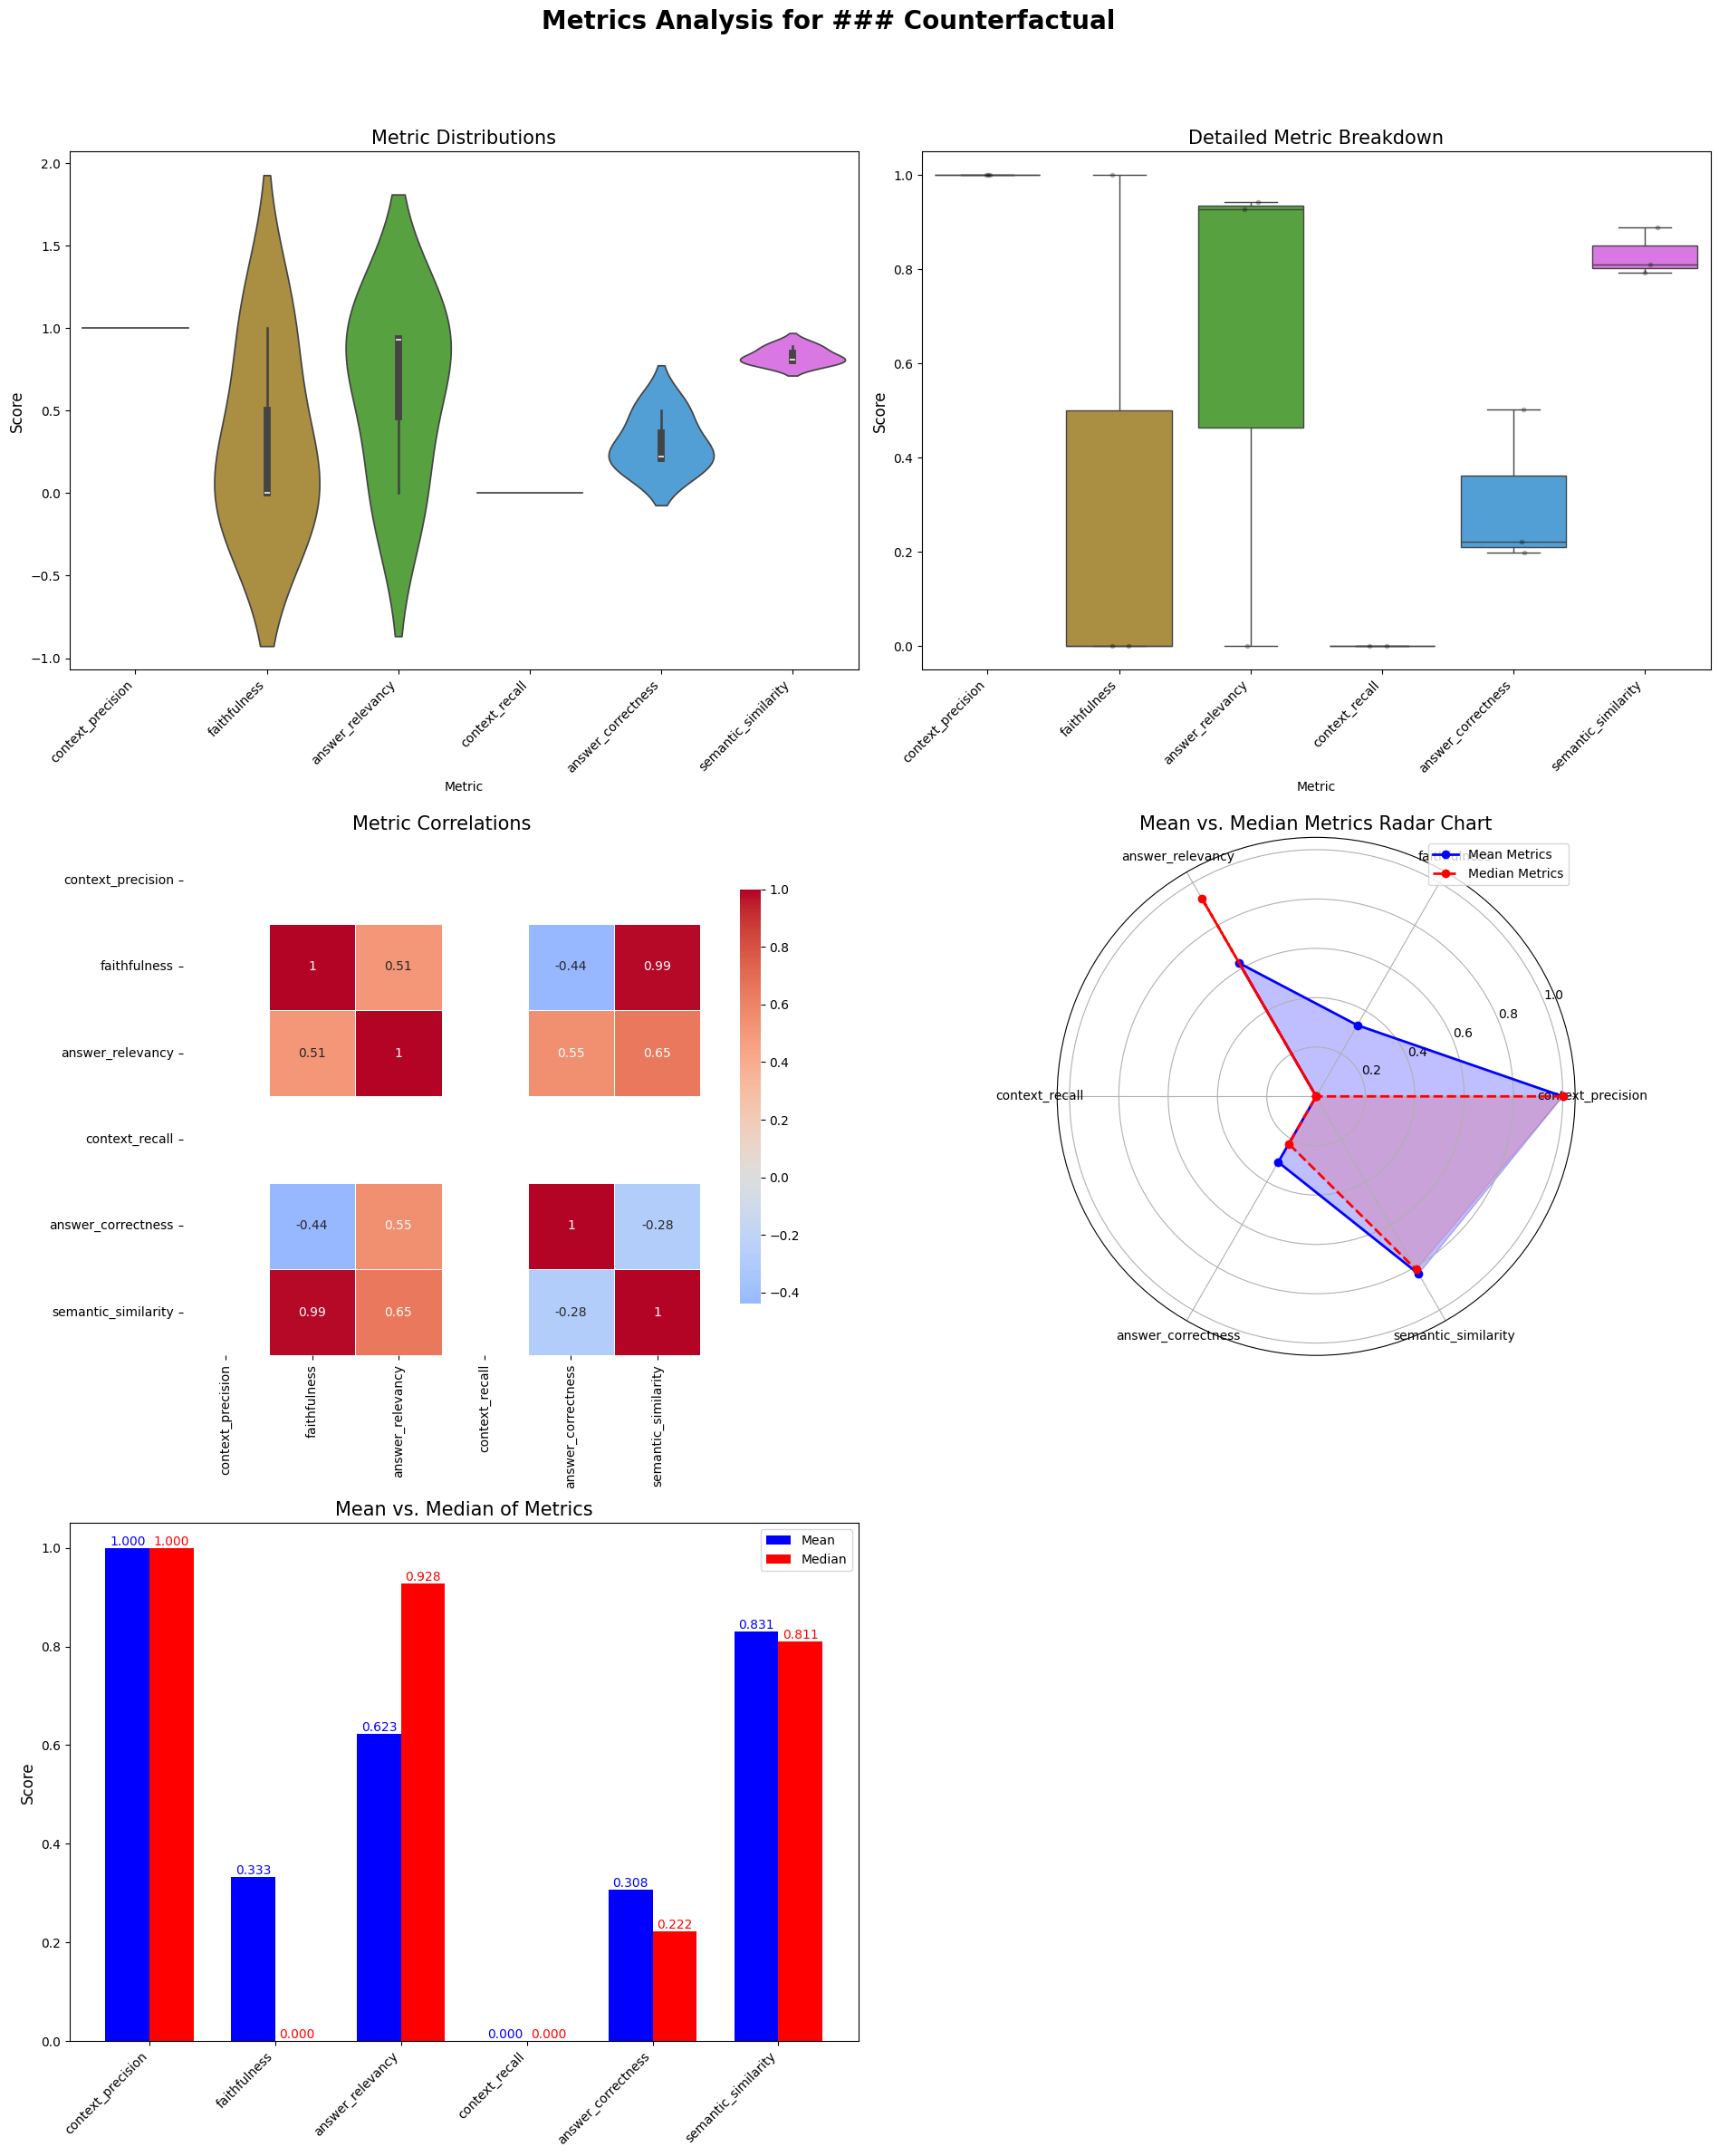


=== Processing Metrics for: ### COMPARITIVE ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### COMPARITIVE
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        4  1.0000  1.0000   0.0000  1.0000  1.0000
faithfulness             2  0.3000  0.3000   0.4243  0.0000  0.6000
answer_relevancy         4  0.6106  0.7852   0.4091  0.0000  0.8719
context_recall           3  0.2722  0.2500   0.1182  0.1667  0.4000
answer_correctness       4  0.3455  0.3395   0.1619  0.1886  0.5143
semantic_similarity      4  0.8513  0.8717   0.0676  0.7546  0.9072

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.3000
  Median: 0.3000
  Standard Deviation: 0.4243
  Coefficient of Variation: 141.42%
Answer Relevancy:
  Mean: 0.6106
  Median: 0.7852
  Standard Deviation: 0.4091
  Coefficient of Variation: 67.00%
Context Recall:
  Mean: 0.2722
  Median: 0.2500
  Standard Deviation: 0.1182
  Coefficient of Variation: 43.44%
Answer Correct

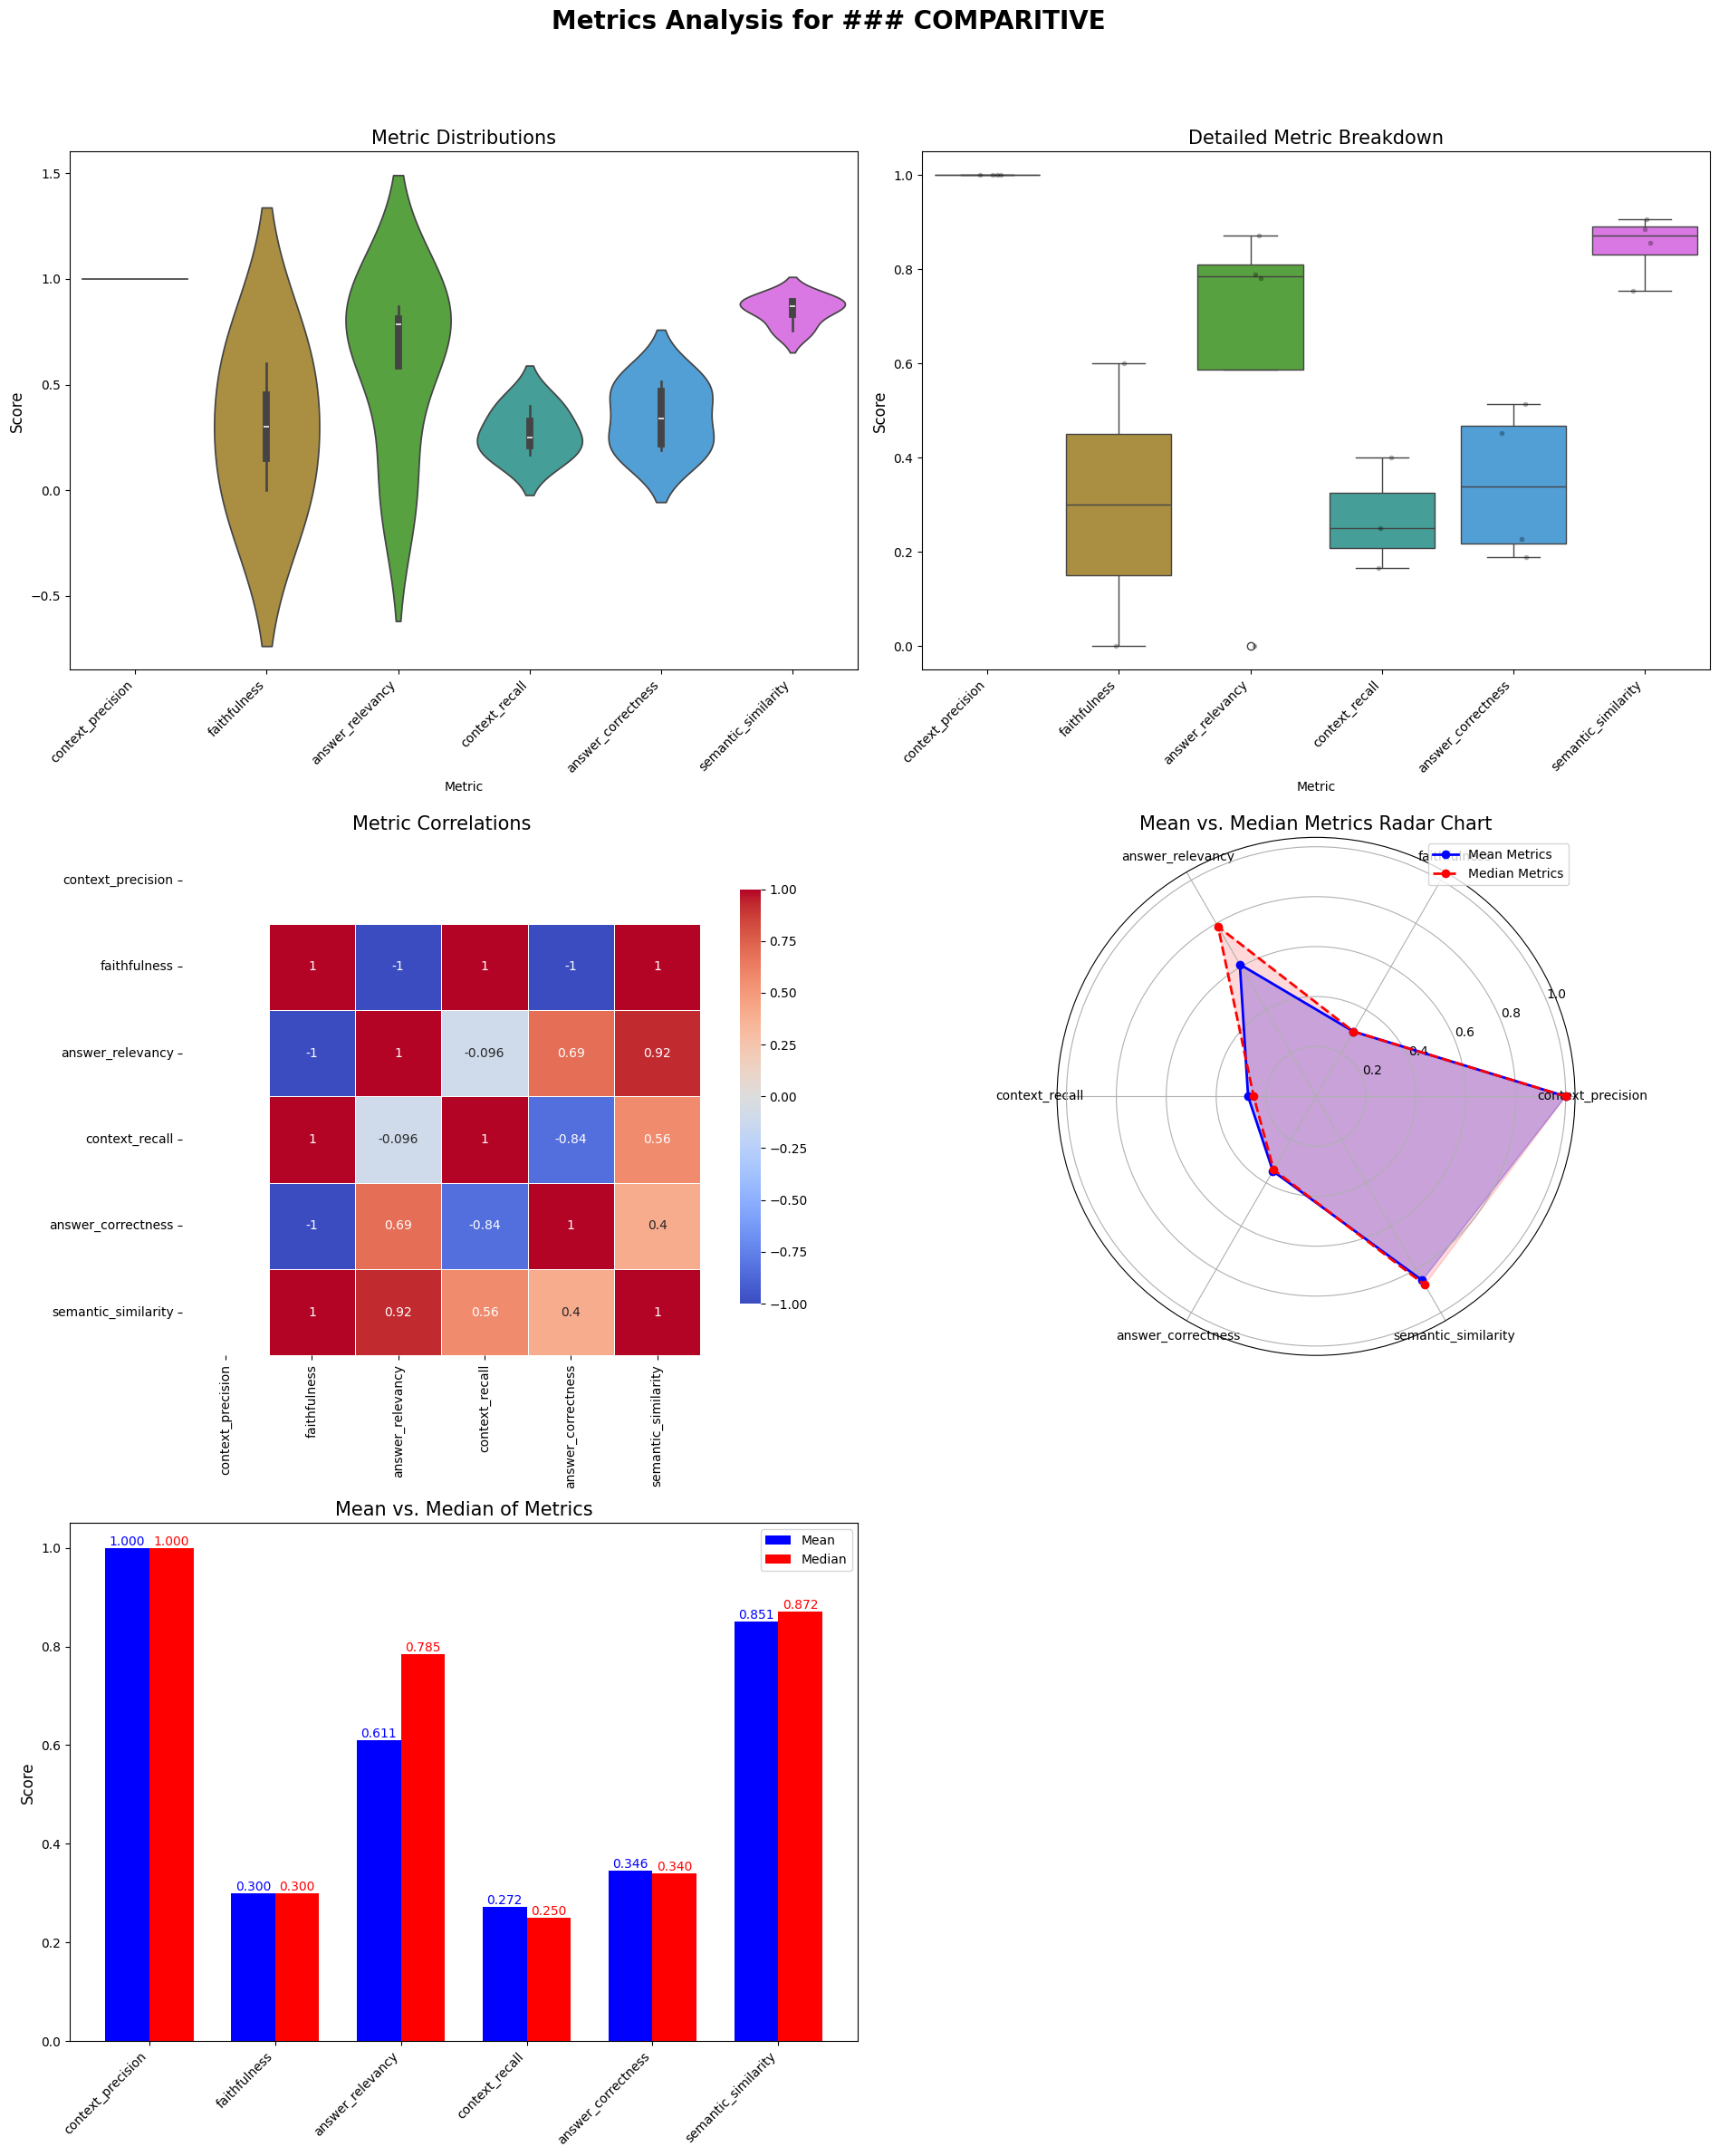


=== Processing Metrics for: ### TEMPORAL ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### TEMPORAL
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        4  0.7500  1.0000   0.5000  0.0000  1.0000
faithfulness             4  0.5500  0.6000   0.5260  0.0000  1.0000
answer_relevancy         4  0.2440  0.0000   0.4880  0.0000  0.9759
context_recall           4  0.2500  0.2500   0.2887  0.0000  0.5000
answer_correctness       4  0.2759  0.1898   0.1865  0.1688  0.5550
semantic_similarity      4  0.7573  0.7593   0.0727  0.6753  0.8353

Additional Insights:
Context Precision:
  Mean: 0.7500
  Median: 1.0000
  Standard Deviation: 0.5000
  Coefficient of Variation: 66.67%
Faithfulness:
  Mean: 0.5500
  Median: 0.6000
  Standard Deviation: 0.5260
  Coefficient of Variation: 95.63%
Answer Relevancy:
  Mean: 0.2440
  Median: 0.0000
  Standard Deviation: 0.4880
  Coefficient of Variation: 200.00%
Context Recall:
  Mean: 0.2500
  Median: 0.2500
  Standard Deviation: 0.2887
  Coefficient of Variation: 115.47%
Answer Correctn

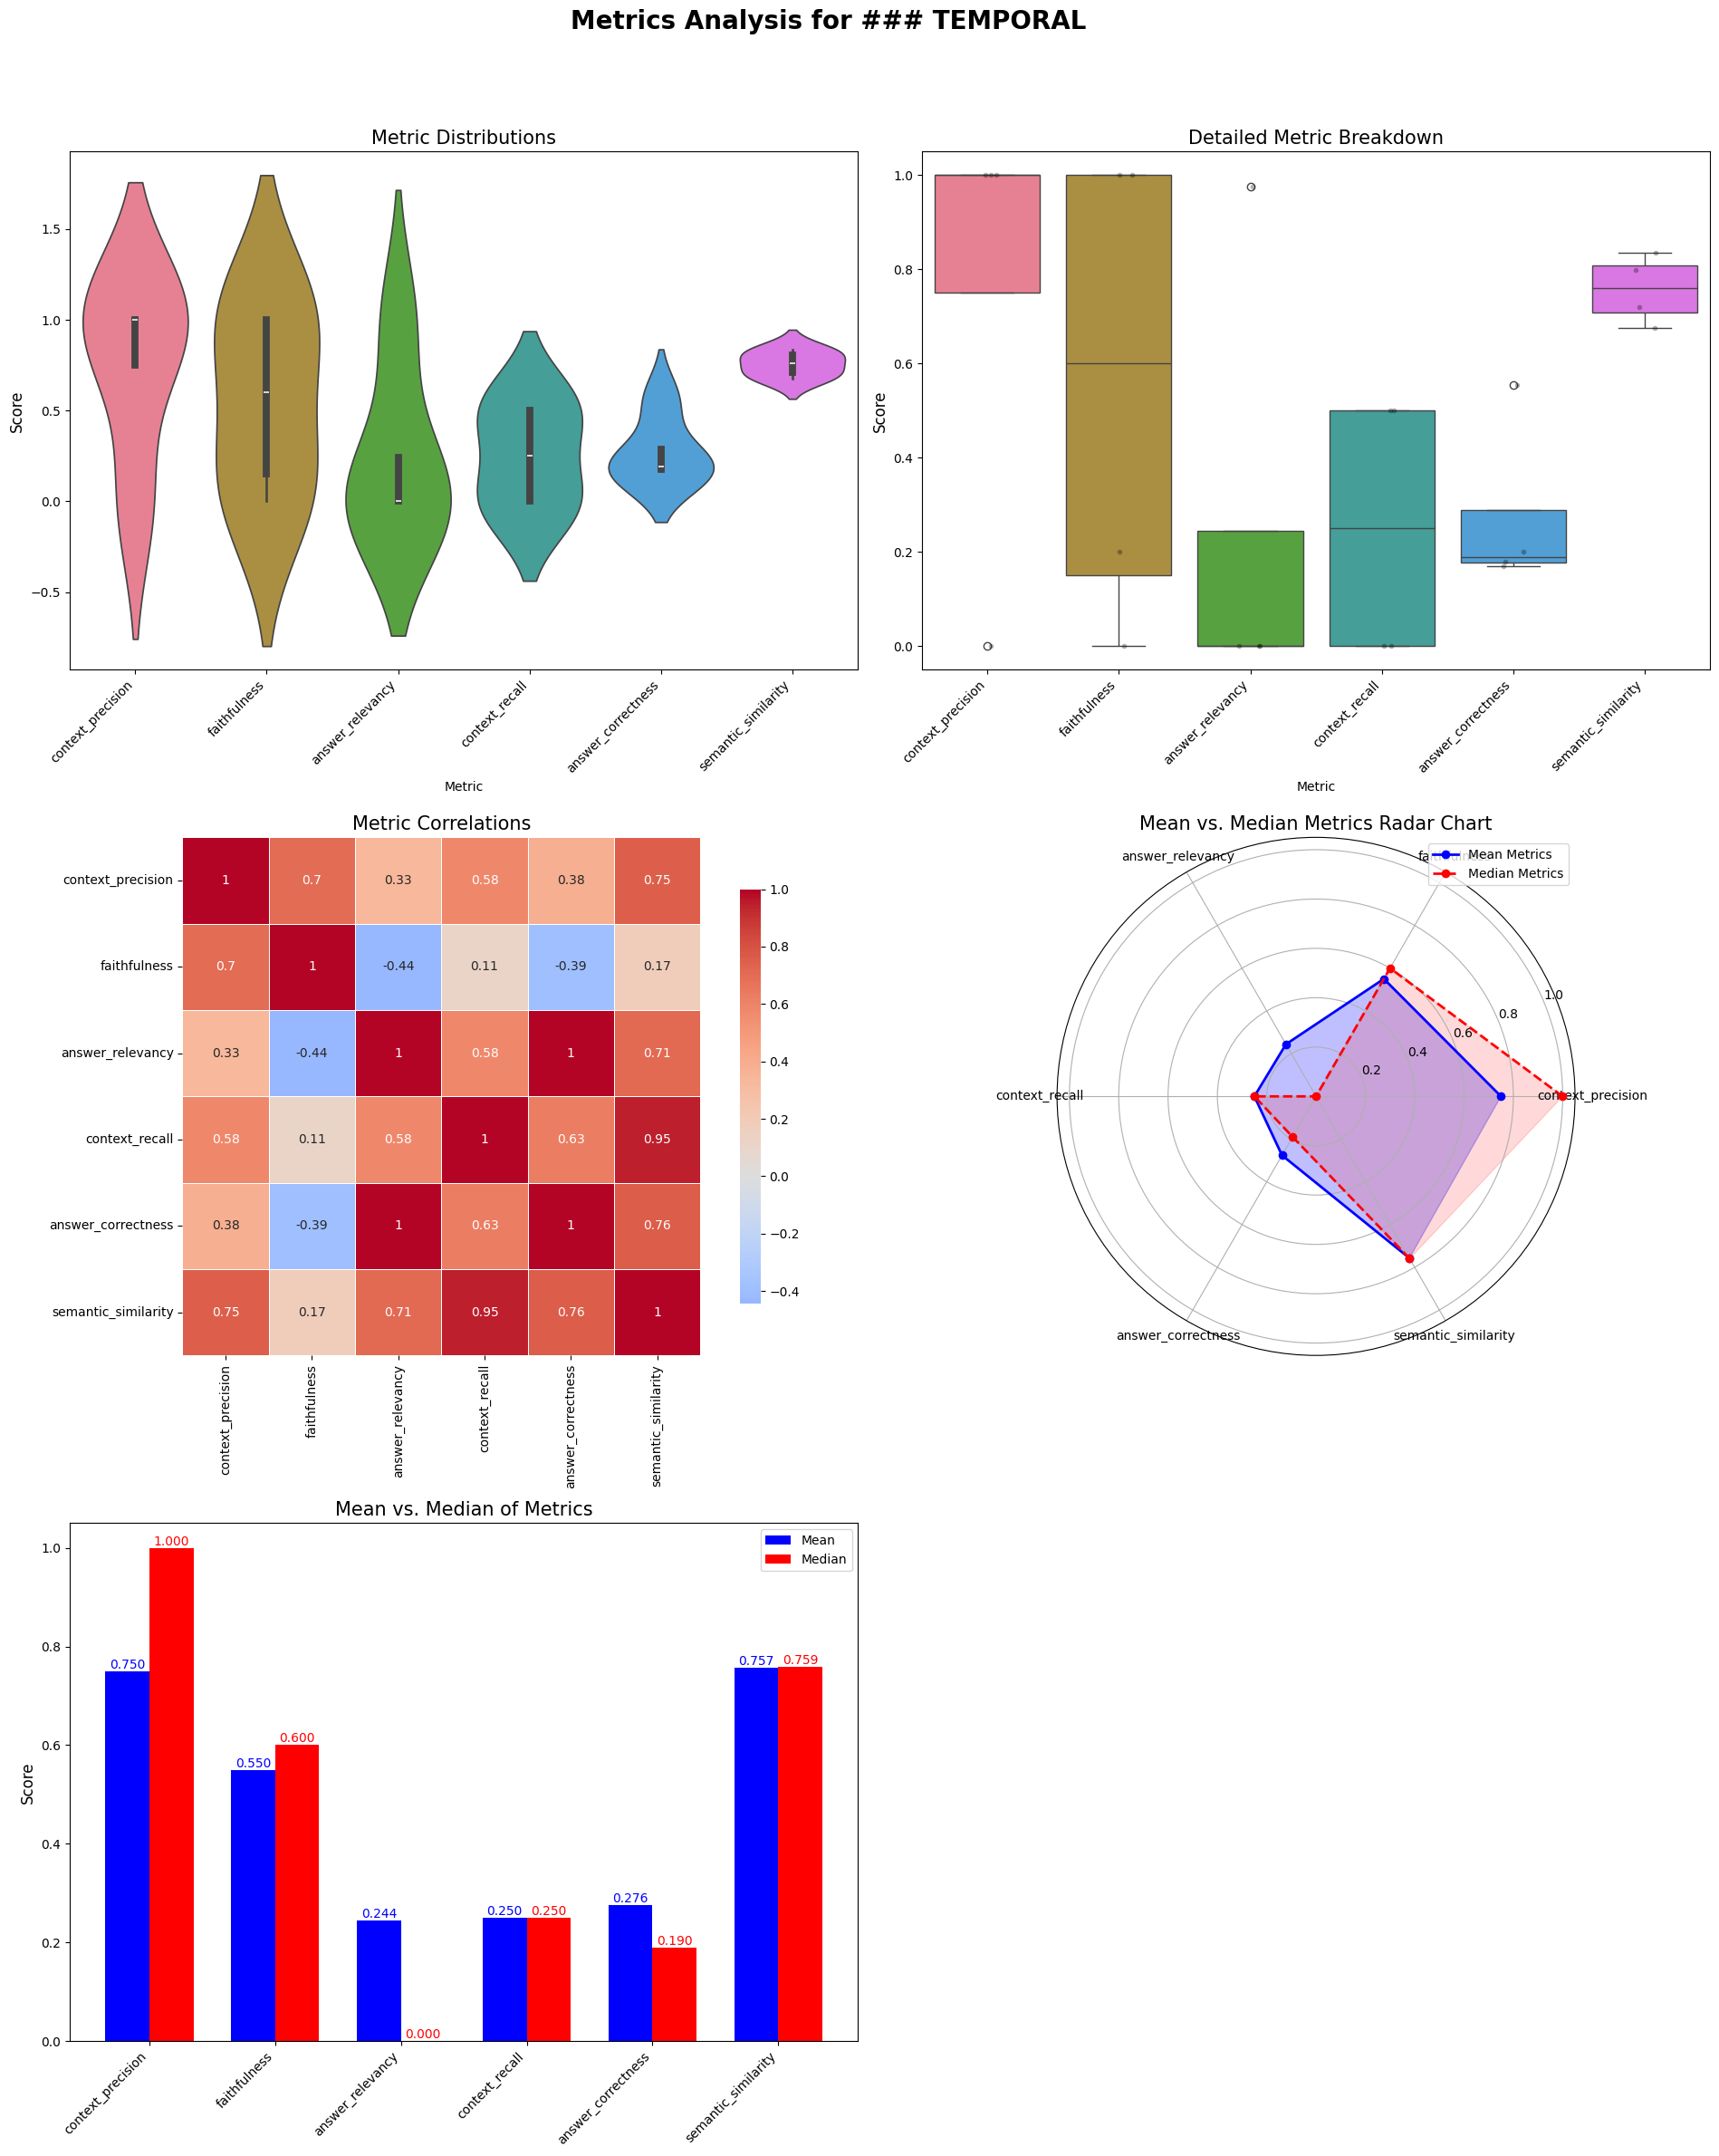


=== Processing Metrics for: ### AMBIGUOUS ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### AMBIGUOUS
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        2  0.0000  0.0000   0.0000  0.0000  0.0000
faithfulness             3  0.6667  1.0000   0.5774  0.0000  1.0000
answer_relevancy         3  0.5278  0.7643   0.4579  0.0000  0.8191
context_recall           3  0.0000  0.0000   0.0000  0.0000  0.0000
answer_correctness       3  0.1778  0.1724   0.0159  0.1653  0.1957
semantic_similarity      3  0.7112  0.6897   0.0635  0.6613  0.7827

Additional Insights:
Context Precision:
  Mean: 0.0000
  Median: 0.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.6667
  Median: 1.0000
  Standard Deviation: 0.5774
  Coefficient of Variation: 86.60%
Answer Relevancy:
  Mean: 0.5278
  Median: 0.7643
  Standard Deviation: 0.4579
  Coefficient of Variation: 86.76%
Context Recall:
  Mean: 0.0000
  Median: 0.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Answer Correctness

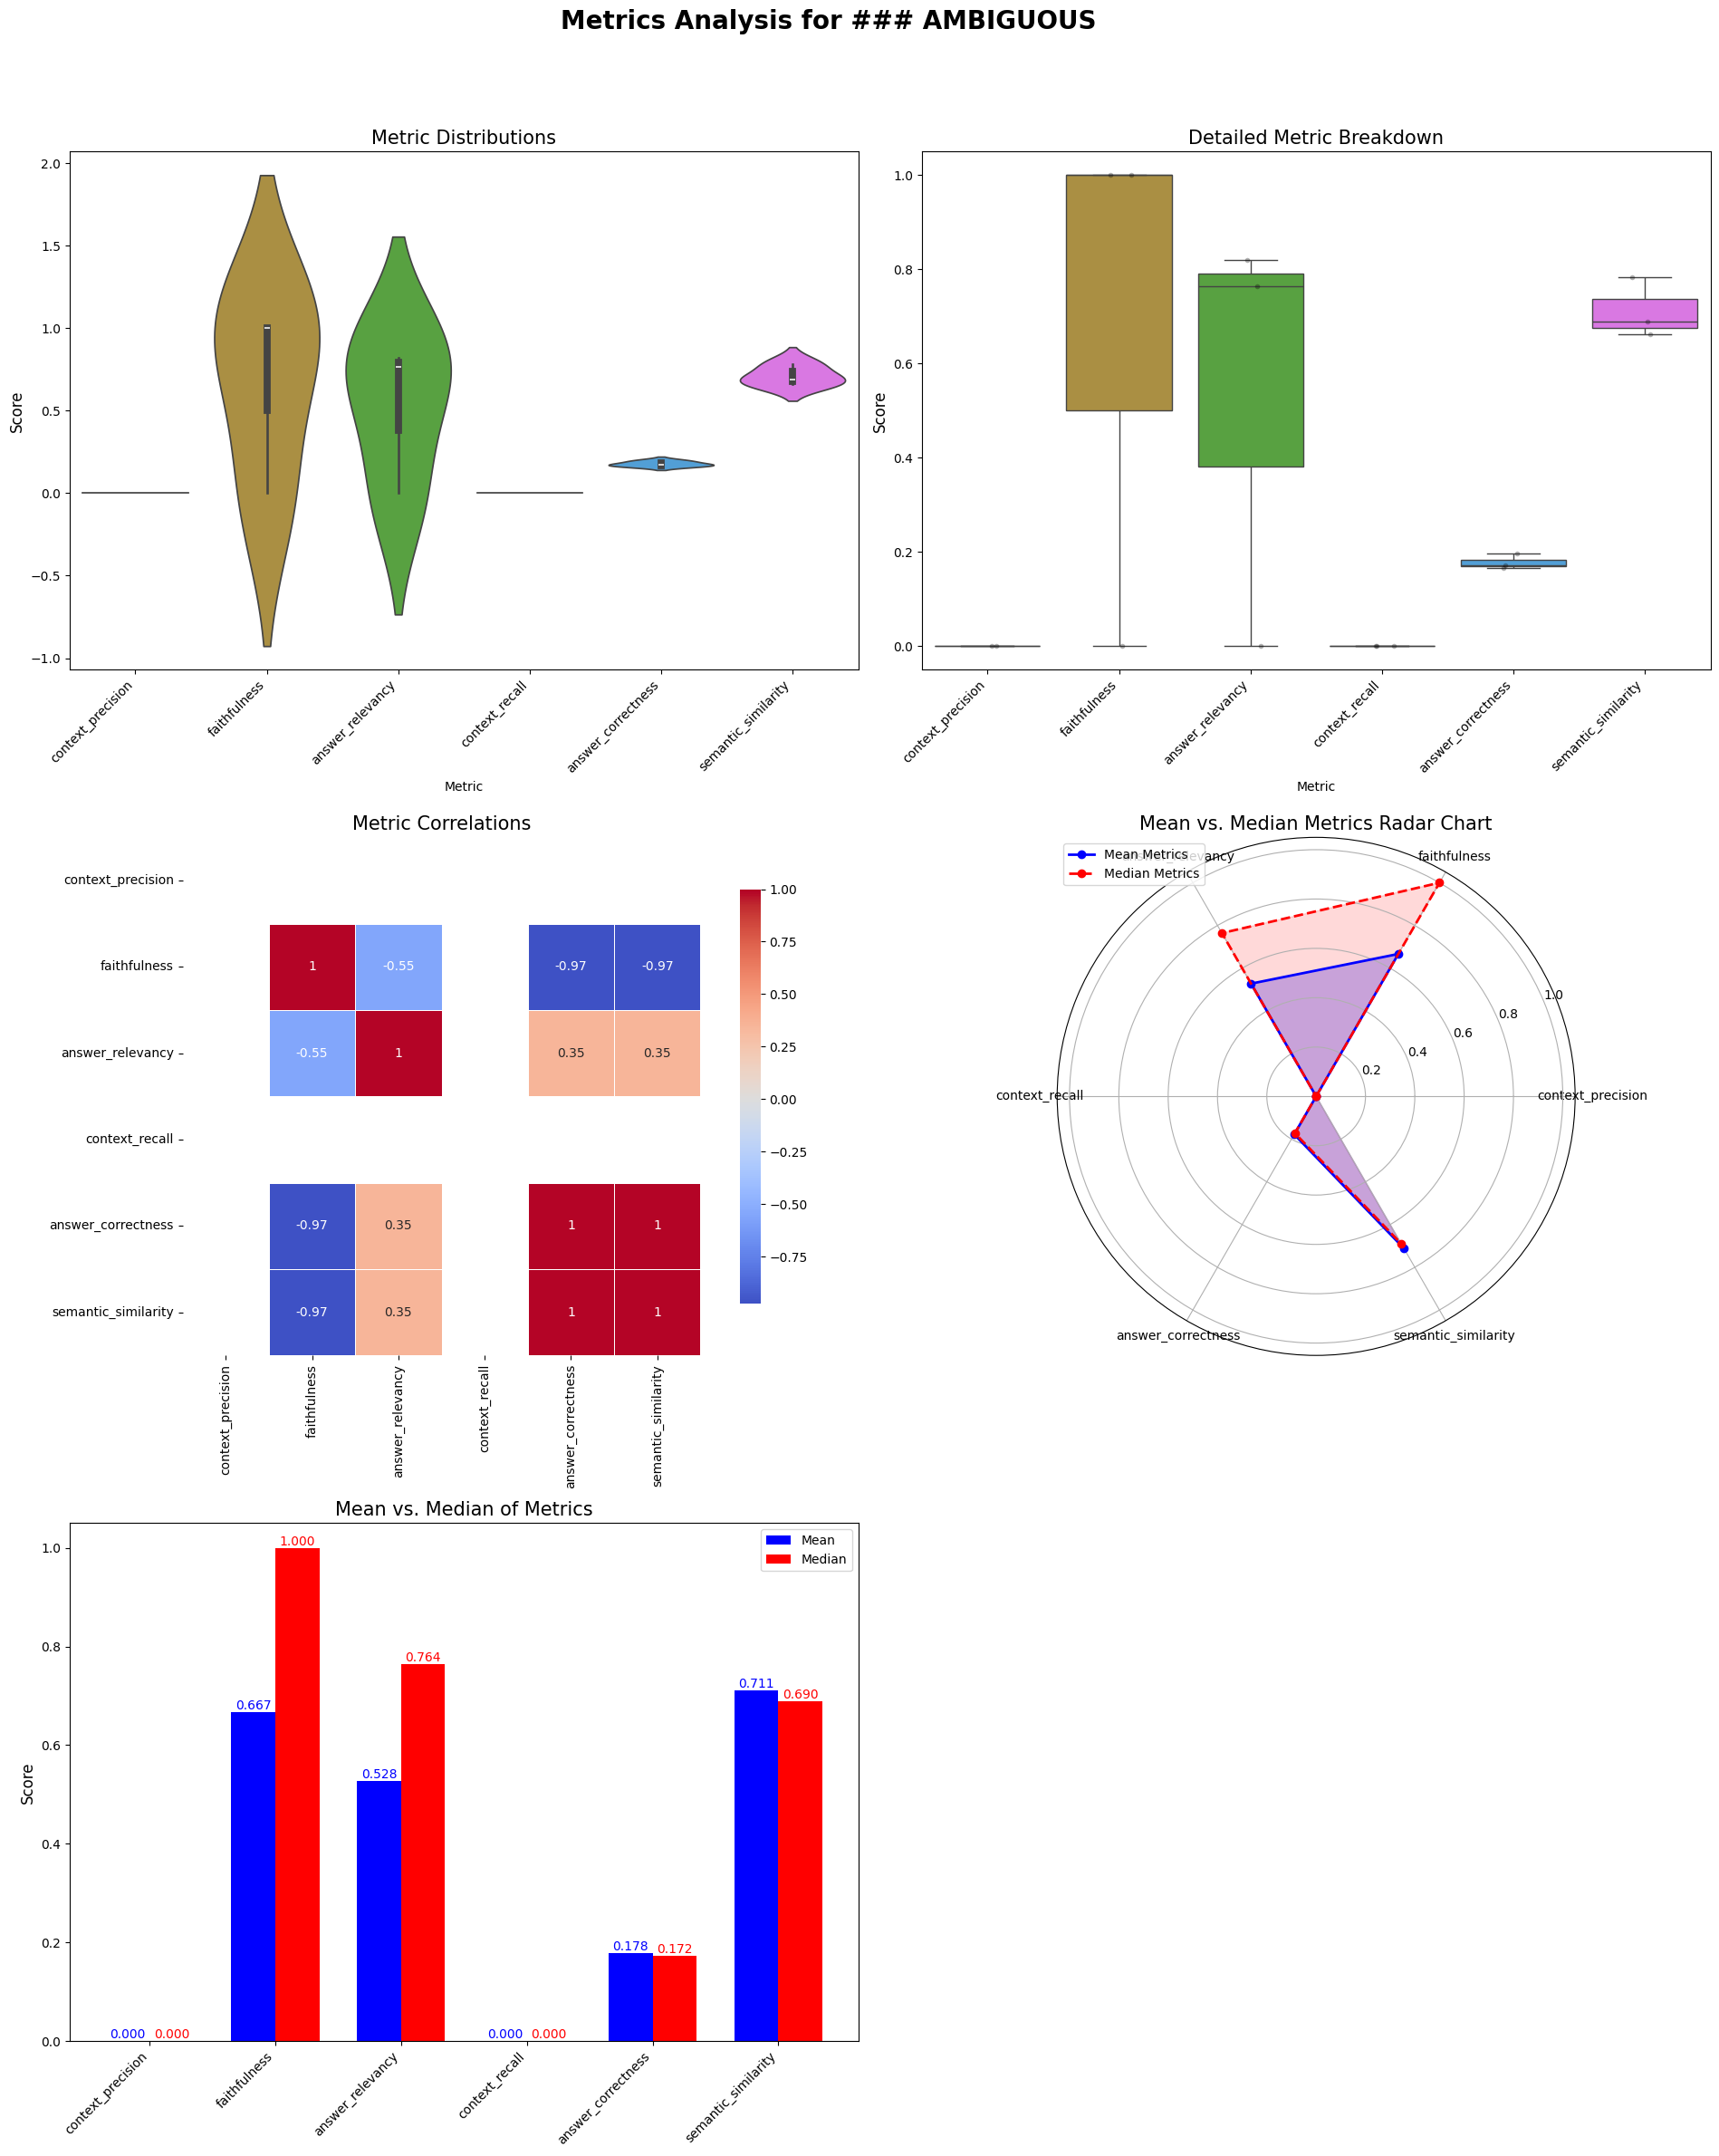


=== Processing Metrics for: ### CAUSALITY ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
c:\Users\offic\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\offic\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
C:\Users\offic\AppD

Metrics Summary for: ### CAUSALITY
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        1  1.0000  1.0000      NaN  1.0000  1.0000
faithfulness             1  0.7500  0.7500      NaN  0.7500  0.7500
answer_relevancy         1  0.0000  0.0000      NaN  0.0000  0.0000
context_recall           1  0.0000  0.0000      NaN  0.0000  0.0000
answer_correctness       1  0.1621  0.1621      NaN  0.1621  0.1621
semantic_similarity      1  0.6485  0.6485      NaN  0.6485  0.6485

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: nan
  Coefficient of Variation: nan%
Faithfulness:
  Mean: 0.7500
  Median: 0.7500
  Standard Deviation: nan
  Coefficient of Variation: nan%
Answer Relevancy:
  Mean: 0.0000
  Median: 0.0000
  Standard Deviation: nan
  Coefficient of Variation: 0.00%
Context Recall:
  Mean: 0.0000
  Median: 0.0000
  Standard Deviation: nan
  Coefficient of Variation: 0.00%
Answer Correctness:
  Mean: 0.1621

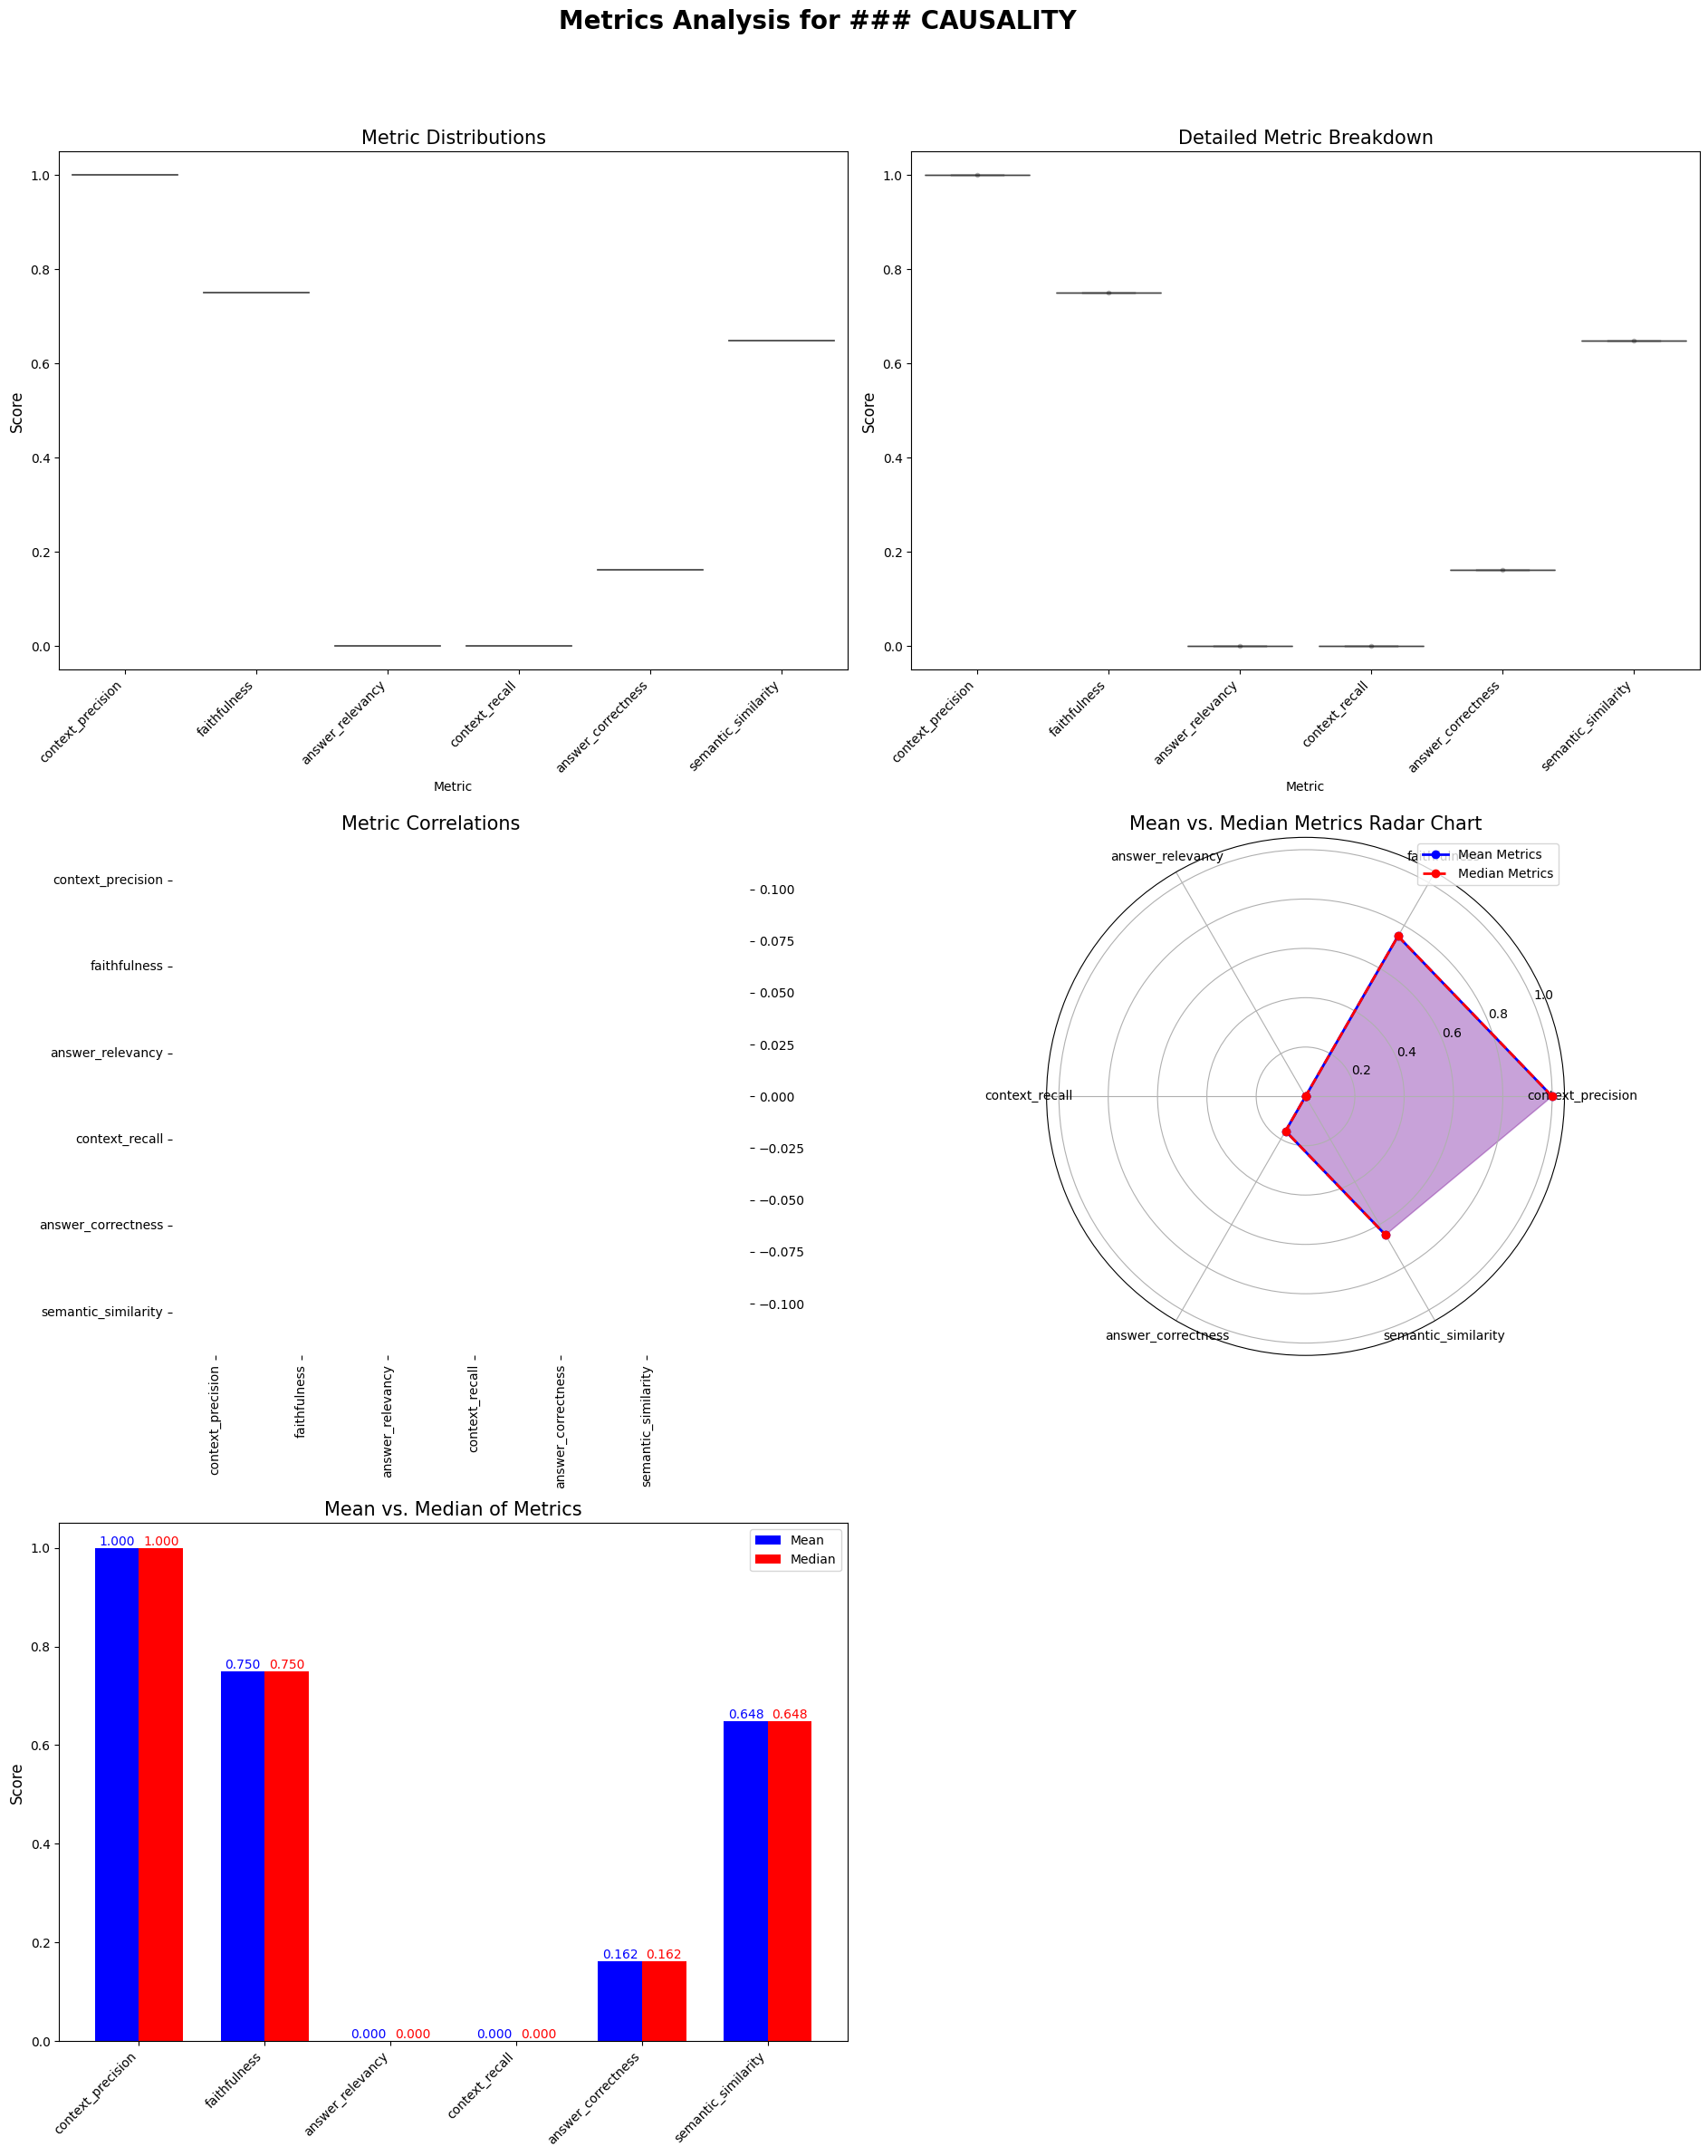


=== Processing Metrics for: ### Dialogue ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### Dialogue
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        6  1.0000  1.0000   0.0000  1.0000  1.0000
faithfulness             6  0.4667  0.5000   0.4216  0.0000  1.0000
answer_relevancy         6  0.5723  0.6173   0.3575  0.0000  0.9172
context_recall           6  1.0000  1.0000   0.0000  1.0000  1.0000
answer_correctness       6  0.2377  0.1494   0.2342  0.0904  0.7109
semantic_similarity      6  0.5509  0.5476   0.1443  0.3616  0.7738

Additional Insights:
Context Precision:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Faithfulness:
  Mean: 0.4667
  Median: 0.5000
  Standard Deviation: 0.4216
  Coefficient of Variation: 90.35%
Answer Relevancy:
  Mean: 0.5723
  Median: 0.6173
  Standard Deviation: 0.3575
  Coefficient of Variation: 62.46%
Context Recall:
  Mean: 1.0000
  Median: 1.0000
  Standard Deviation: 0.0000
  Coefficient of Variation: 0.00%
Answer Correctness:

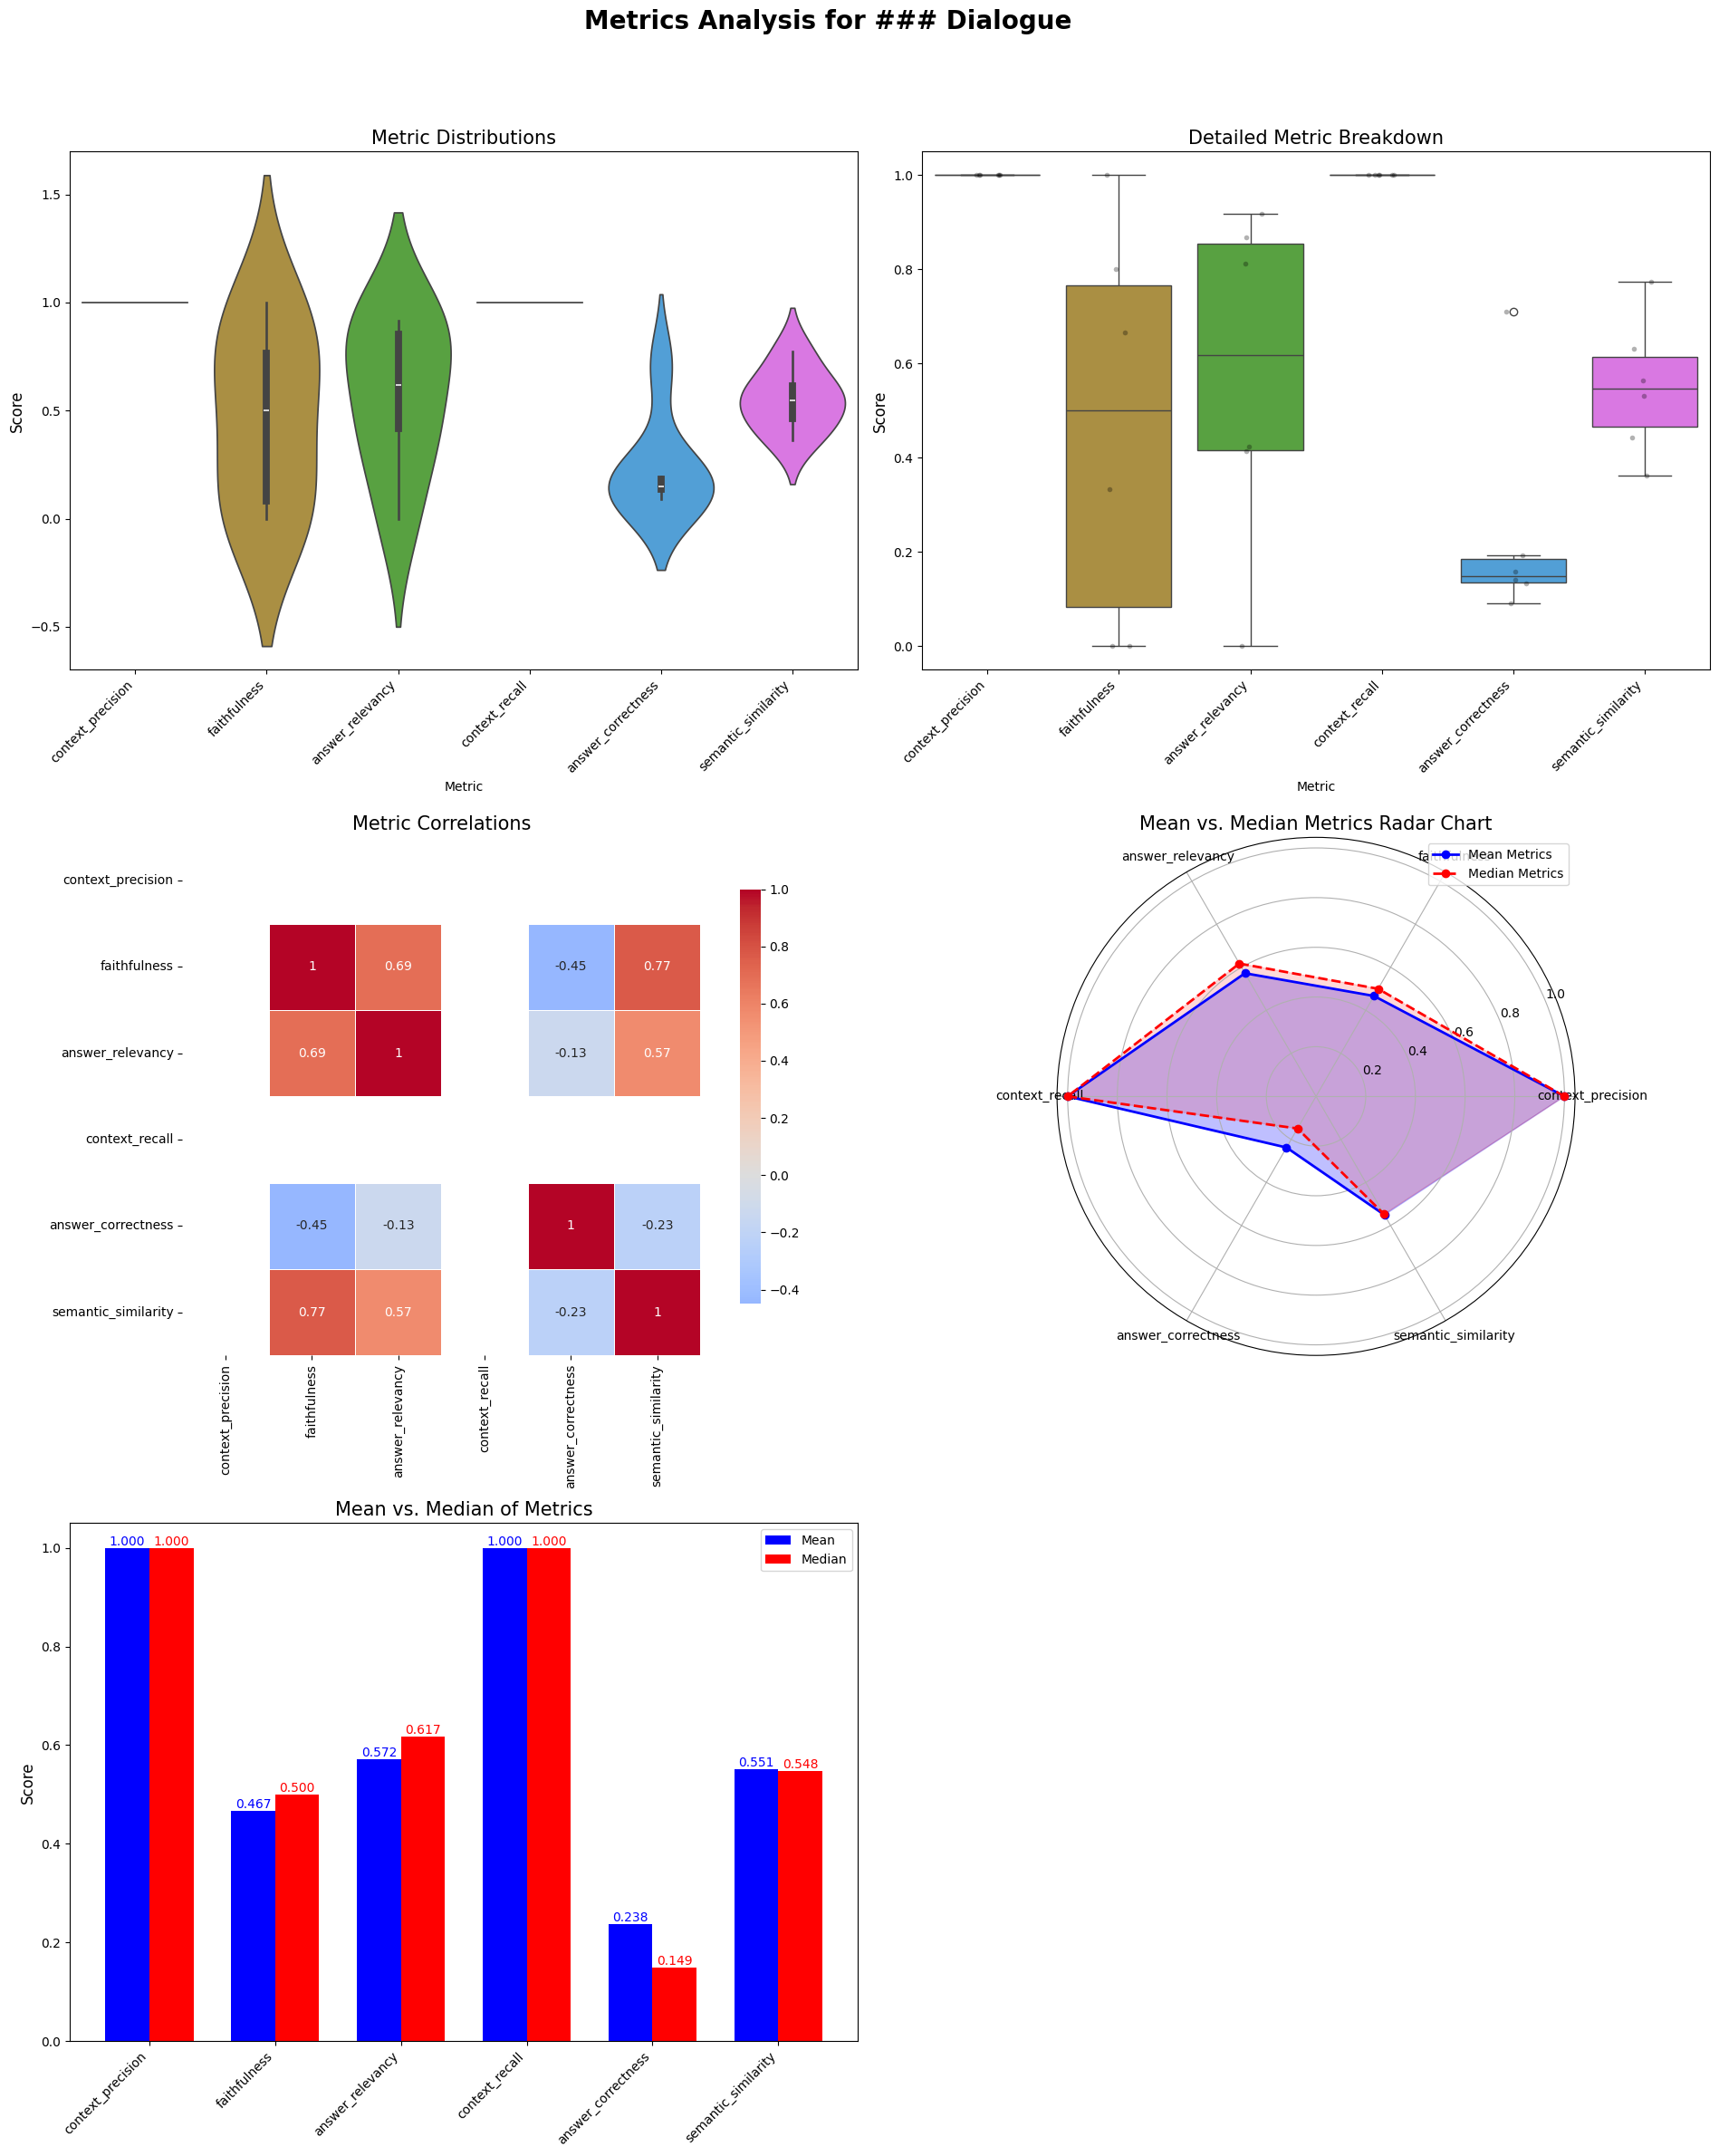


=== Processing Metrics for: ### NER ===



C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
C:\Users\offic\AppData\Local\Temp\ipykernel_12696\4261148822.py:73: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red

Metrics Summary for: ### NER
                     Count    Mean  Median  Std Dev     Min     Max
context_precision        7  0.7143  1.0000   0.4880  0.0000  1.0000
faithfulness             7  0.7262  1.0000   0.4046  0.0000  1.0000
answer_relevancy         7  0.6366  0.7098   0.2563  0.2538  0.8743
context_recall           7  0.5000  0.5000   0.5000  0.0000  1.0000
answer_correctness       7  0.1756  0.1278   0.1259  0.0819  0.4449
semantic_similarity      7  0.5595  0.5112   0.1933  0.3276  0.7904

Additional Insights:
Context Precision:
  Mean: 0.7143
  Median: 1.0000
  Standard Deviation: 0.4880
  Coefficient of Variation: 68.31%
Faithfulness:
  Mean: 0.7262
  Median: 1.0000
  Standard Deviation: 0.4046
  Coefficient of Variation: 55.71%
Answer Relevancy:
  Mean: 0.6366
  Median: 0.7098
  Standard Deviation: 0.2563
  Coefficient of Variation: 40.25%
Context Recall:
  Mean: 0.5000
  Median: 0.5000
  Standard Deviation: 0.5000
  Coefficient of Variation: 100.00%
Answer Correctness:
 

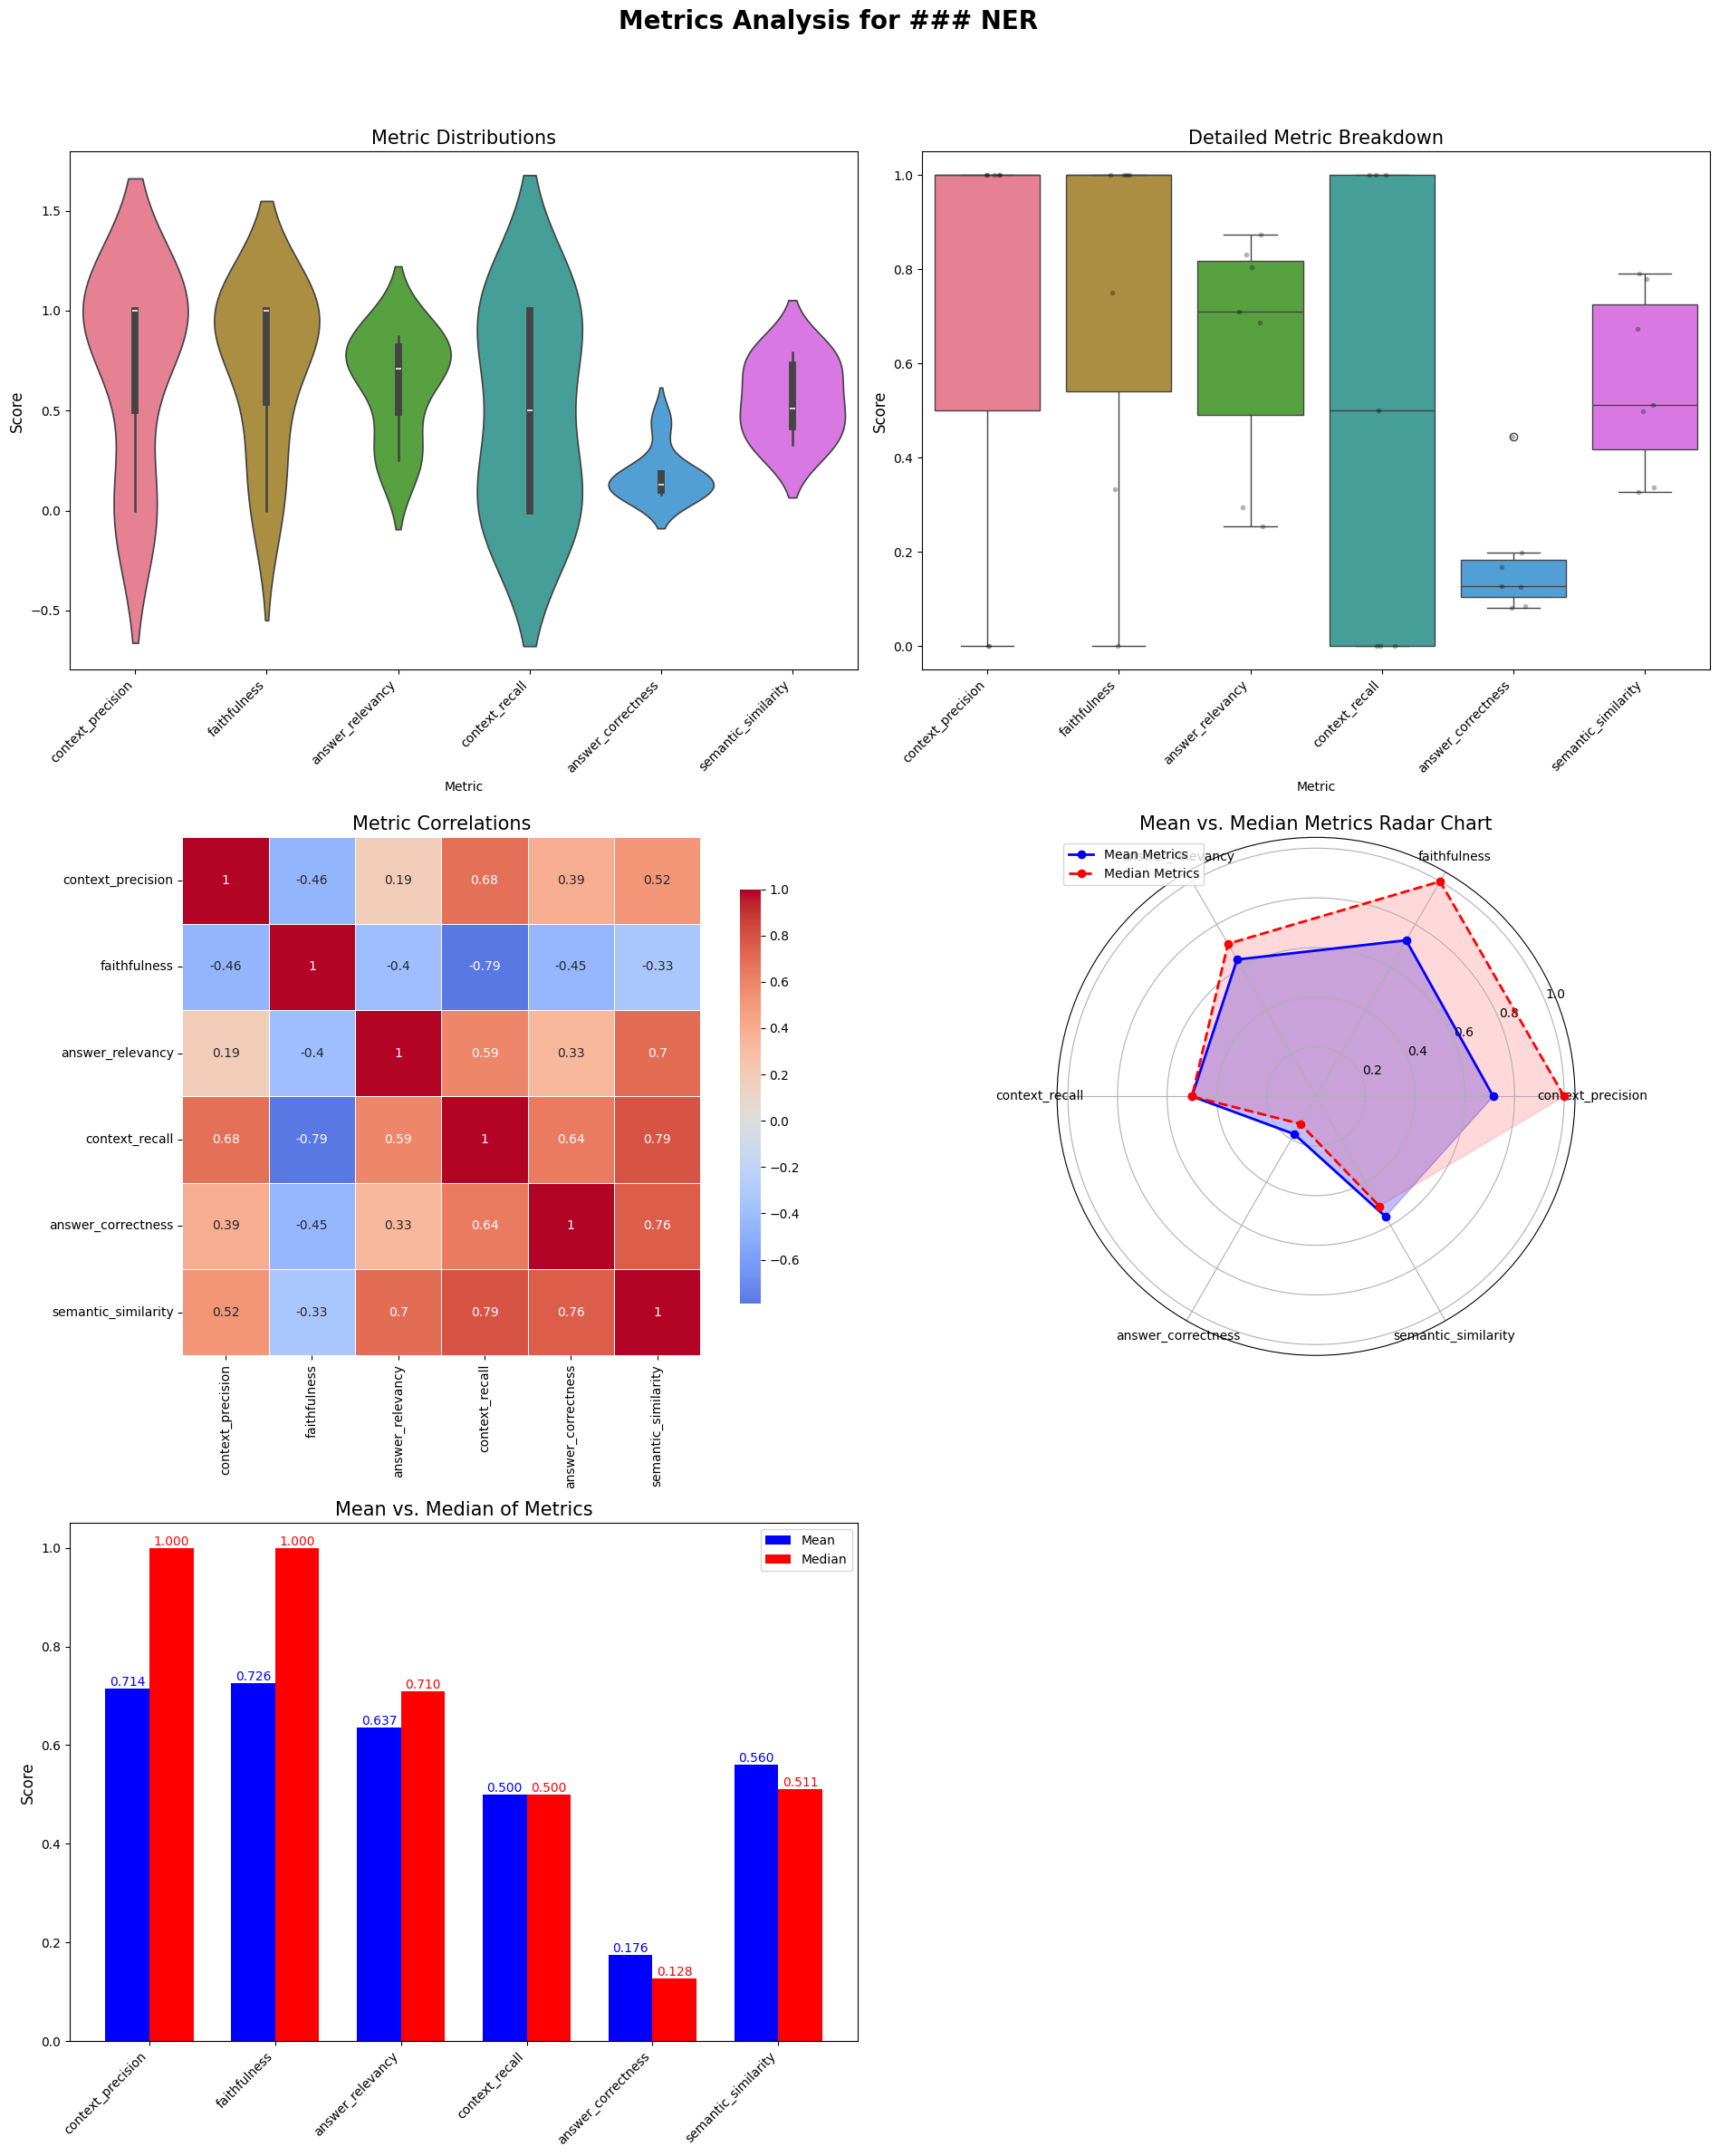

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics_by_question_type(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Identify unique question types (rows where the first column starts with ###)
    df['Question_Type'] = df.iloc[:, 0].where(df.iloc[:, 0].astype(str).str.startswith('###')).ffill()
    
    # Select metrics columns
    metrics_columns = [
        'context_precision', 'faithfulness', 'answer_relevancy', 
        'context_recall', 'answer_correctness', 'semantic_similarity'
    ]
    
    # Set up color palette
    palette = sns.color_palette("husl", 6)
    
    # Process each question type separately
    for question_type in df['Question_Type'].unique():
        subset_df = df[df['Question_Type'] == question_type]
        
        if subset_df.empty:
            continue
        
        print(f"\n=== Processing Metrics for: {question_type} ===\n")
        
        # Melt data for plots
        df_melted = subset_df[metrics_columns].melt(var_name='Metric', value_name='Score')

        # Create a figure
        plt.figure(figsize=(20, 25))
        plt.suptitle(f'Metrics Analysis for {question_type}', fontsize=20, fontweight='bold')

        # 1. Violin Plot (Distribution)
        plt.subplot(3, 2, 1)
        sns.violinplot(x='Metric', y='Score', data=df_melted, palette=palette)
        plt.title('Metric Distributions', fontsize=15)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Score', fontsize=12)

        # 2. Box Plot with Individual Points
        plt.subplot(3, 2, 2)
        sns.boxplot(x='Metric', y='Score', data=df_melted, palette=palette)
        sns.stripplot(x='Metric', y='Score', data=df_melted, color='black', size=4, alpha=0.3)
        plt.title('Detailed Metric Breakdown', fontsize=15)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Score', fontsize=12)

        # 3. Correlation Heatmap
        plt.subplot(3, 2, 3)
        correlation_matrix = subset_df[metrics_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Metric Correlations', fontsize=15)

        # 4. Radar Chart
        plt.subplot(3, 2, 4, polar=True)
        mean_metrics = subset_df[metrics_columns].mean()
        median_metrics = subset_df[metrics_columns].median()

        # Radar chart setup
        angles = [n / float(len(metrics_columns)) * 2 * np.pi for n in range(len(metrics_columns))]
        angles += angles[:1]

        mean_values = mean_metrics.tolist() + mean_metrics.tolist()[:1]
        median_values = median_metrics.tolist() + median_metrics.tolist()[:1]

        plt.polar(angles[:-1], mean_values[:-1], 'o-', linewidth=2, label='Mean Metrics', color='blue')
        plt.polar(angles[:-1], median_values[:-1], 'o-', linewidth=2, linestyle='dashed', label='Median Metrics', color='red')
        plt.fill(angles, mean_values, alpha=0.25, color='blue')
        plt.fill(angles, median_values, alpha=0.15, color='red')
        plt.xticks(angles[:-1], metrics_columns)
        plt.title('Mean vs. Median Metrics Radar Chart', fontsize=15)
        plt.legend()

        # 5. Mean & Median Bar Plot
        plt.subplot(3, 2, 5)
        mean_values = subset_df[metrics_columns].mean()
        median_values = subset_df[metrics_columns].median()

        x = np.arange(len(metrics_columns))
        width = 0.35  # Bar width

        plt.bar(x - width/2, mean_values, width, label='Mean', color='blue')
        plt.bar(x + width/2, median_values, width, label='Median', color='red')

        plt.xticks(x, metrics_columns, rotation=45, ha='right')
        plt.title('Mean vs. Median of Metrics', fontsize=15)
        plt.ylabel('Score', fontsize=12)
        plt.legend()

        # Add value labels
        for i, v in enumerate(mean_values):
            plt.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom', fontsize=10, color='blue')
        for i, v in enumerate(median_values):
            plt.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom', fontsize=10, color='red')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Detailed Summary Statistics
        print("Metrics Summary for:", question_type)
        summary = pd.DataFrame({
            'Count': subset_df[metrics_columns].count(),
            'Mean': subset_df[metrics_columns].mean(),
            'Median': subset_df[metrics_columns].median(),
            'Std Dev': subset_df[metrics_columns].std(),
            'Min': subset_df[metrics_columns].min(),
            'Max': subset_df[metrics_columns].max()
        })
        print(summary.round(4))

        # Additional Insights
        print("\nAdditional Insights:")
        for metric in metrics_columns:
            mean_val = subset_df[metric].mean()
            median_val = subset_df[metric].median()
            std_dev = subset_df[metric].std()
            coeff_var = (std_dev / mean_val * 100) if mean_val != 0 else 0
            print(f"{metric.replace('_', ' ').title()}:")
            print(f"  Mean: {mean_val:.4f}")
            print(f"  Median: {median_val:.4f}")
            print(f"  Standard Deviation: {std_dev:.4f}")
            print(f"  Coefficient of Variation: {coeff_var:.2f}%")

        plt.show()

# Usage
plot_metrics_by_question_type('seperated_bhadve.xlsx')
#plot_metrics_by_question_type('bhadve38_rag_evaluation_results_ragasNEWALL560ALL.xlsx')
